In [1]:
from IPython.display import display, HTML
import mplfinance as mpf

from scipy import stats
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from datetime import time as dttime

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,12)
pd.options.display.max_rows = 200
pd.set_option('precision', 7)

# HSI strategy analysis

#### strategy:
- Entry conditions
    - At pre-set times (9:15am and 13:45pm), we will make a bet.
    - If the price of that pre-set time is higher than previous day close, it will make a Long position; while if the price of that pre-set time is lower than previous day close, it will make a Put position.

- Exit conditions
    - If the position is winning 80 points (84 points to be exact), it will trigger a trailing stop when it drawdowns by 40 points from the max winning position.
    - If the position is not winning over 80 points, it will trigger a stop loss exit with a 40 points loss.

Multichart statistics shows that the strategy was rather unstable across the course of time of backtesting. With from 2018 to 2020H1, it is basically flat or even losing, but during 2020H2, the performance of the strategy was stunning. 

- Why is that? 
- What kind of market situations will it be flat (and losing)?
- What kind of market situations will be winning? 
- If there are chances we can have signals telling us which market is favourable to the strategy? And telling us to or not to enter the market?
- Can we decrease the volatility of the strategy, making it more stable across the course of time?

In [2]:
xmlTree = ET.parse('tradeslog.xml')
root = xmlTree.getroot()

## Load Bars

In [3]:
data = []

for bar in root.find('Prices').findall('Bar'):
    d = {}
    for p in bar.getchildren():
        if p.tag == 'Date':
            for t in p.getchildren():
                d.update({t.tag: t.text})
        else:
            d.update({p.tag: p.text})
    data.append(d)
    
col = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Open', 'High', 'Low', 'Close', 'Volumen'] 
df_bar = pd.DataFrame(data=data, columns=col)

time_col = ['Year','Month','Day','Hour','Minute','Second']
df_bar['Time'] = pd.to_datetime(df_bar[time_col])
df_bar.drop(time_col, axis=1, inplace=True)
df_bar = df_bar.set_index('Time')

price_col = ['Open', 'High', 'Low', 'Close', 'Volumen']
df_bar[price_col] = df_bar[price_col].astype(float)
df_bar = df_bar.sort_index()

In [4]:
df_bar.head(10)

Open     High      Low    Close  Volumen
Time                                                            
2018-06-28 09:16:00  28200.0  28239.0  28175.0  28220.0   1399.0
2018-06-28 09:17:00  28219.0  28240.0  28199.0  28203.0    867.0
2018-06-28 09:18:00  28202.0  28204.0  28128.0  28131.0   1638.0
2018-06-28 09:19:00  28131.0  28165.0  28124.0  28142.0    850.0
2018-06-28 09:20:00  28143.0  28147.0  28104.0  28144.0    849.0
2018-06-28 09:21:00  28142.0  28146.0  28099.0  28123.0   1137.0
2018-06-28 09:22:00  28122.0  28134.0  28104.0  28121.0    576.0
2018-06-28 09:23:00  28121.0  28130.0  28109.0  28116.0    770.0
2018-06-28 09:24:00  28116.0  28122.0  28102.0  28105.0    375.0
2018-06-28 09:25:00  28105.0  28117.0  28102.0  28111.0    405.0

In [5]:
print(mpf.available_styles()) 

['binance', 'blueskies', 'brasil', 'charles', 'checkers', 'classic', 'default', 'mike', 'nightclouds', 'sas', 'starsandstripes', 'yahoo']


In [6]:
my_color = mpf.make_marketcolors(up='cyan', down='red', edge='black', wick='i',volume={'up': 'blue', 'down': 'orange'}, ohlc='cyan')
my_style = mpf.make_mpf_style(base_mpf_style='nightclouds', marketcolors=my_color, gridaxis='both',gridstyle='-.', y_on_right=True)


In [7]:
# mpf.plot(df_bar.tail(1000),type='candle', style=my_style, figsize=(15,5))#, mav=(50,150,200))

## Load Trades

In [8]:
data = []

for trade in root.find('Trades').findall('Trade'):
    d = {}
    for x in trade.getchildren():
        if x.tag == 'Date':
            for i in x.getchildren():
                d.update({i.tag: i.text})
        else:
            d.update({x.tag: x.text})
    data.append(d)
    
col = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Type', 'Quantity', 'Price', 'Signal', 'Profit'] 
df_trade = pd.DataFrame(data=data, columns=col)
df_trade['Signal'] = df_trade['Signal'].apply(lambda x: x.replace('"',''))

time_col = ['Year','Month','Day','Hour','Minute','Second']
df_trade['Time'] = pd.to_datetime(df_trade[time_col])
df_trade['Quantity'] = df_trade['Quantity'].astype(int)
df_trade['Price'] = df_trade['Price'].astype(float)
df_trade.drop(time_col, axis=1, inplace=True)

In [9]:
df_trade.head(6)

Type  Quantity    Price     Signal Profit                Time
0    Buy         2  28401.0         LE    NaN 2018-06-29 09:46:00
1  LExit         2  28361.0  Stop Loss  -4120 2018-06-29 09:49:00
2    Buy         2  28634.0       LEpm    NaN 2018-06-29 13:46:00
3  LExit         2  28697.0       Sell   6180 2018-06-29 14:08:00
4   Sell         2  28021.0         SE    NaN 2018-07-03 09:46:00
5  SExit         2  27941.0      Cover   7880 2018-07-03 09:47:00

In [10]:
df_trade['Signal'].unique()

array(['LE', 'Stop Loss', 'LEpm', 'Sell', 'SE', 'Cover', 'SEpm',
       'End of Day Exit'], dtype=object)

In [11]:
df_entry = df_trade.iloc[::2].reset_index(drop=True)
df_exit = df_trade.iloc[1::2].reset_index(drop=True)

In [12]:
assert set(df_entry['Signal'].unique().tolist()) - set(['LE', 'LEpm', 'SE', 'SEpm']) == set()
assert set(df_exit['Signal'].unique().tolist()) - set(['Stop Loss', 'Sell', 'Cover', 'End of Day Exit']) == set()

### Trades samples 

In [13]:
df_trades = pd.concat([df_entry.add_prefix('entry_'), df_exit.add_prefix('exit_')],axis=1)
df_trades['exit_Profit'] = df_trades['exit_Profit'].astype(float)
df_trades

entry_Type  entry_Quantity  entry_Price entry_Signal entry_Profit  \
0           Buy               2      28401.0           LE          NaN   
1           Buy               2      28634.0         LEpm          NaN   
2          Sell               2      28021.0           SE          NaN   
3          Sell               2      28189.0         SEpm          NaN   
4           Buy               2      28350.0           LE          NaN   
...         ...             ...          ...          ...          ...   
1345        Buy               2      28664.0         LEpm          NaN   
1346        Buy               2      28875.0           LE          NaN   
1347        Buy               2      28733.0         LEpm          NaN   
1348        Buy               2      28860.0           LE          NaN   
1349        Buy               2      28812.0         LEpm          NaN   

              entry_Time exit_Type  exit_Quantity  exit_Price exit_Signal  \
0    2018-06-29 09:46:00     LExit              2     28361.0   Stop Loss   
1    2018-06-29 13:46:00     LExit              2     28697.0        Sell   
2    2018-07-03 09:46:00     SExit              2     27941.0       Cover   
3    2018-07-03 13:46:00     SExit              2     28141.0       Cover   
4    2018-07-04 09:46:00     LExit              2     28310.0   Stop Loss   
...                  ...       ...            ...         ...         ...   
1345 2021-06-09 13:46:00     LExit              2     28624.0   Stop Loss   
1346 2021-06-10 09:46:00     LExit              2     28835.0   Stop Loss   
1347 2021-06-10 13:46:00     LExit              2     28693.0   Stop Loss   
1348 2021-06-11 09:46:00     LExit              2     28820.0   Stop Loss   
1349 2021-06-11 13:46:00     LExit              2     28772.0   Stop Loss   

      exit_Profit           exit_Time  
0         -4120.0 2018-06-29 09:49:00  
1          6180.0 2018-06-29 14:08:00  
2          7880.0 2018-07-03 09:47:00  
3          4680.0 2018-07-03 14:04:00  
4         -4120.0 2018-07-04 09:58:00  
...           ...                 ...  
1345      -4120.0 2021-06-09 14:11:00  
1346      -4120.0 2021-06-10 09:52:00  
1347      -4120.0 2021-06-10 14:42:00  
1348      -4120.0 2021-06-11 09:50:00  
1349      -4120.0 2021-06-11 14:48:00  

[1350 rows x 12 columns]

## Overview: What's the win rate of the strategy?

In [14]:
df_trades['exit_Signal'].value_counts().sum()

1350

- Over 1000 trades are analysed here.

In [15]:
df_ = df_trades['exit_Signal'].value_counts().rename('trades by exit type').to_frame()
df_['% of trades by exit type'] = (100.0*df_/df_trades['exit_Signal'].count()).round(2)


In [16]:
df_

trades by exit type  % of trades by exit type
Stop Loss                        869                     64.37
Sell                             264                     19.56
Cover                            206                     15.26
End of Day Exit                   11                      0.81

- Overall, 64% of the trades had stopped-loss and only 35% of the trades were winning. 

### Were short entries more profitable than long entries? No.

In [17]:
def calc_percentage(df):
    df_ = pd.concat([
                    df, 
                    df.sum(axis=1).rename('Total Trades').to_frame(),  
                    100.0*df.divide(df.sum(axis=1),axis=0).add_prefix('% ').round(2)
                ],axis=1).fillna(0).astype(int)
    return df_

In [18]:
df_exit_entry_stat = df_trades.assign(year_month = lambda x: x.entry_Time.apply(lambda y: y.strftime('%Y-%m')) )\
                        .groupby(['year_month', 'entry_Type','exit_Signal'])['entry_Quantity'].count().unstack(level=-1)

df_exit_entry_stat = calc_percentage(df_exit_entry_stat)

df_ = df_exit_entry_stat.drop('2018-06')['% Stop Loss'].unstack(level=-1)

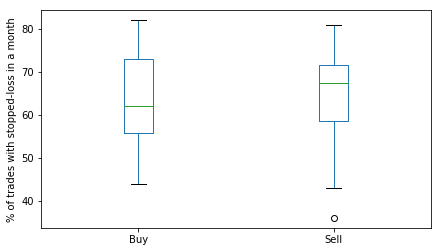

In [19]:
ax = df_.plot.box(figsize=(7,4))
plt.ylabel('% of trades with stopped-loss in a month');

In [20]:
df_e = df_trades.groupby(['entry_Type','exit_Signal'])['entry_Quantity'].count().unstack(level=-1)
df_e = calc_percentage(df_e)

In [21]:
df_e

Cover  End of Day Exit  Sell  Stop Loss  Total Trades  % Cover  \
entry_Type                                                                   
Buy             0                6   264        463           733        0   
Sell          206                5     0        406           617       33   

            % End of Day Exit  % Sell  % Stop Loss  
entry_Type                                          
Buy                         1      36           63  
Sell                        1       0           66

- The percentage of stopped-loss trades do not seem to differ much by whether the trades were long or short entries. 

In [22]:
stats.ttest_ind(df_.Buy, df_.Sell)

Ttest_indResult(statistic=-0.9417184689593945, pvalue=0.34957549118006104)

- From t-test, there is no evidence that the long and short entries differ in % of trades with stopped-loss 

### Confirm Multichart results: Did the months in 2020-H2 made more profit?

In [23]:
df_monthly_profit = df_trades.assign(year_month = lambda x: x.entry_Time.apply(lambda y: y.strftime('%Y-%m')) )\
                        .groupby(['year_month'])['exit_Profit'].sum().to_frame()
df_monthly_profit.T

year_month   2018-06  2018-07  2018-08  2018-09  2018-10  2018-11  2018-12  \
exit_Profit   2060.0  30180.0   -520.0  26200.0  37240.0 -40940.0 -50460.0   

year_month   2019-01  2019-02  2019-03  ...  2020-09  2020-10  2020-11  \
exit_Profit  42300.0 -18740.0 -18140.0  ...  22540.0  -6120.0  44940.0   

year_month   2020-12   2021-01  2021-02  2021-03  2021-04  2021-05  2021-06  
exit_Profit  36420.0  103040.0  10860.0  29480.0   9440.0 -19900.0  -2440.0  

[1 rows x 37 columns]

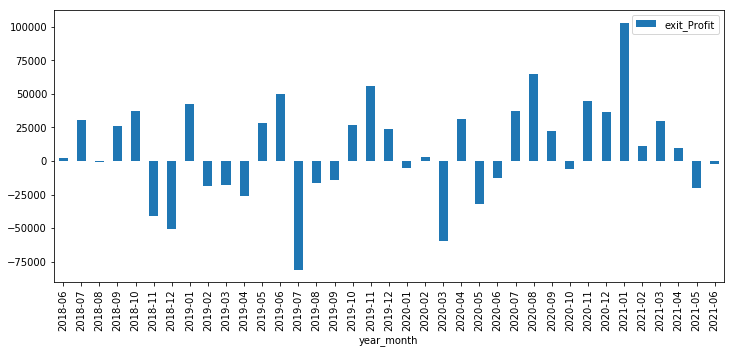

In [24]:
df_monthly_profit.plot.bar( figsize=(12,5) ); 

- YES. 2020 H2 had more profits compared to periods before and after; only 2020-10 had a loss.
- 2021 Jan had the largest gain
- 2019 Jul had the largest loss

### Confirm Multichart results: Did 2020-H2 have less losing trades per month compared to other periods? 

In [25]:
df_exit_stat = df_trades.assign(year_month = lambda x: x.entry_Time.apply(lambda y: y.strftime('%Y-%m')) )\
                .groupby(['year_month','exit_Signal'])['entry_Quantity'].count().unstack(level=-1)

df_exit_stat = calc_percentage(df_exit_stat)

In [26]:
def get_half_year(timestamp):
    return str(timestamp.year) + ('-H1' if 1 <= timestamp.month <= 6 else '-H2')

In [27]:
df_exit_halfyear_stat = df_trades.assign(half_year = lambda x: x.entry_Time.apply(lambda y: get_half_year(y)) )\
                .assign(year_month = lambda x: x.entry_Time.apply(lambda y: y.strftime('%Y-%m')) )\
                .groupby(['half_year', 'year_month', 'exit_Signal'])['entry_Quantity'].count().unstack(level=-1)

df_exit_halfyear_stat = calc_percentage(df_exit_halfyear_stat)

In [28]:
# plt.style.available
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [29]:
df_ = df_exit_halfyear_stat['% Stop Loss'].unstack(level=0)

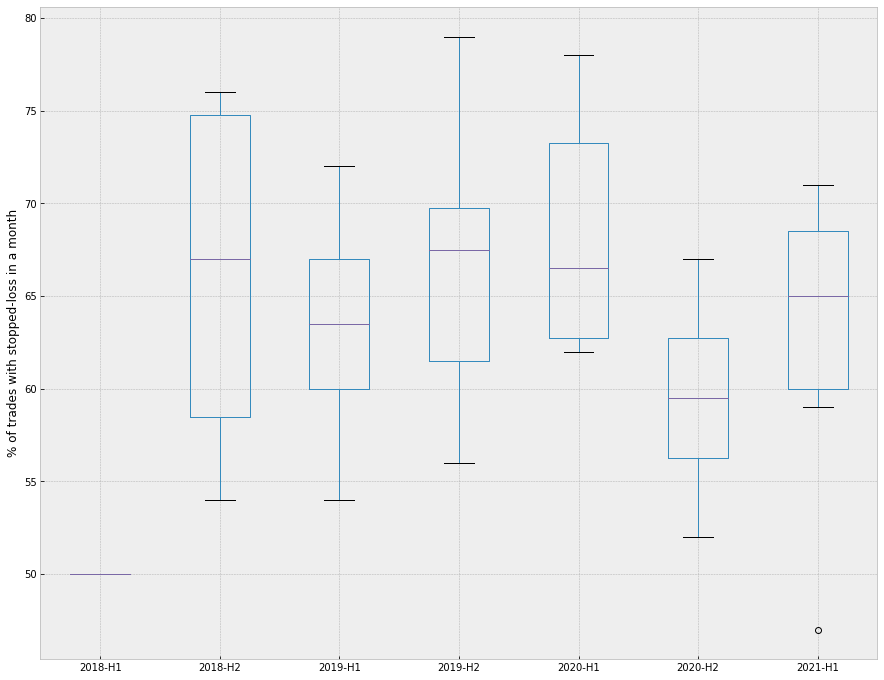

In [30]:
plt.style.use('bmh')
ax = df_.plot.box()
plt.ylabel('% of trades with stopped-loss in a month');

- YES. 2020 H2 had a lower percentage of trades with stopped-loss in a month.

P.S. 2018 H1 only had 1 monthly data point.

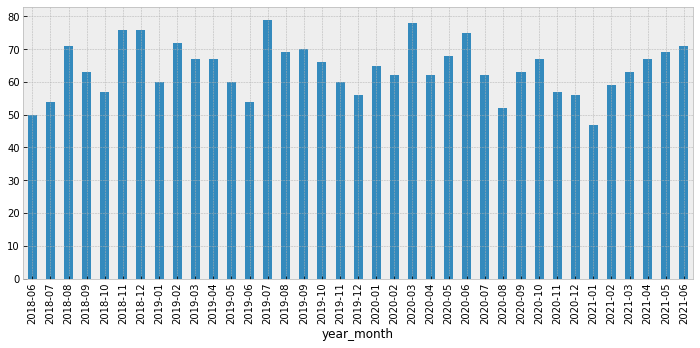

In [31]:
df_exit_stat['% Stop Loss'].plot.bar( figsize=(12,5) );

- The particularly low % of trades with stopped loss in 2020-H2 was not due to any outlier in a particular month, although 2020-Aug was lower in % of trades with stopped loss. So the outperformance of 2020-H2 was not a skewed result.

## Investigate trades in 2019-July, which had many losses
- Trades in 2019-Jul should indicate more strongly as to what caused the poor performance of the strategy.

Note: 
Entries are shown as triangles; stop-losses are crosses; short-cover and long-sell are pointers; end of day exits are pentagons

In [32]:
df_trades['entry_Signal'].unique() #Long, Short

array(['LE', 'LEpm', 'SE', 'SEpm'], dtype=object)

In [33]:
df_trades['exit_Signal'].unique() # Cover, Sell, Stop, EoD

array(['Stop Loss', 'Sell', 'Cover', 'End of Day Exit'], dtype=object)

In [34]:
def get_bars_for_a_trade(trade, df_bar):
    dt = trade.entry_Time
    bar_start_time = datetime.combine(dt.date(), datetime.min.time())
    bar_end_time = bar_start_time + timedelta(hours=23,minutes=59, seconds=59)
    return df_bar.loc[bar_start_time:bar_end_time]


def get_trade_bars(trade, df_bar):    
    index = ['Time', 'long_price', 'short_price', 'cover_price', 'sell_price', 'stoploss_price', 'eod_price']
    t1 = pd.Series(len(index)*[np.nan],index=index)
    t2 = pd.Series(len(index)*[np.nan],index=index)

    entry_map = {
        'LE' : 'long',
        'LEpm' : 'long',
        'SE' : 'short',
        'SEpm' : 'short'
    }
    exit_map = {
        'Cover' : 'cover',
        'Sell'  : 'sell',
        'Stop Loss' : 'stoploss',
        'End of Day Exit' : 'eod'
    }

    t1.loc['Time'] = trade.entry_Time
    if trade.entry_Signal in entry_map.keys():
        t1.loc[entry_map[trade.entry_Signal] + '_price'] = trade.entry_Price
    
    if trade.entry_Time == trade.exit_Time:
        if trade.exit_Signal in exit_map.keys():
            t1.loc[exit_map[trade.exit_Signal] + '_price'] = trade.exit_Price
        df_ = t1.to_frame().T.set_index('Time')
    else:
        t2.loc['Time'] = trade.exit_Time        
        if trade.exit_Signal in exit_map.keys():
            t2.loc[exit_map[trade.exit_Signal] + '_price'] = trade.exit_Price
        df_ = pd.concat([t1, t2], axis=1).T.set_index('Time')
        
    return pd.concat([ get_bars_for_a_trade(trade, df_bar), df_ ],axis=1)

def plot_trade(trade, df_bar, style, plot_till_hour=15):
    df = get_trade_bars(trade, df_bar)
    df = df.loc[datetime.combine(df.index[0].date(), dttime(0)):datetime.combine(df.index[0].date(), dttime(plot_till_hour)) ]
        
    marker_map = {
        'long' : '^',
        'short' : 'v',
        'cover' : '2',
        'sell' : '1', 
        'stoploss' : 'x',
        'eod' : 'p'
    } 
    apds = []
    for c in marker_map.keys():
        s_ = df[c+'_price']
        if s_.any():
            apds.append(mpf.make_addplot(s_.tolist(),type='scatter',markersize=20,marker=marker_map[c]))
    
    display( HTML('<b>{} # {} > {}: {}</b>'.format(trade.entry_Time, trade.entry_Signal, trade.exit_Signal, trade.exit_Profit)) )
    display(trade.to_frame().T)
    mpf.plot(df[['Open','High','Low','Close']],type='candle', style=my_style, figsize=(15,7), addplot=apds, ylim=(trade.entry_Price-400,trade.entry_Price+400))
    display( HTML('<br>') )

In [35]:
def quantify_pullback(trade, recent_max_price, recent_min_price):    
    if trade.entry_Signal in ('LE', 'LEpm') and recent_max_price > trade.entry_Price:
        return recent_max_price - trade.entry_Price
    if trade.entry_Signal in ('SE', 'SEpm') and recent_min_price < trade.entry_Price:
        return trade.entry_Price - recent_min_price
    return

def quantify_1st_pullback(trade, bars):
    if trade.entry_Signal in ('LE', 'LEpm'):
        time_high = bars['High'].idxmax()
        if (time_high != bars.index[-1]) and (bars.loc[time_high]['High'] > trade.entry_Price):
            time_low = bars.loc[time_high:]['Low'].idxmin()
            if (time_low != bars.index[-1]) and (bars.loc[time_low]['Low'] < trade.entry_Price):
                time_high2 = bars.loc[time_low:]['High'].idxmax()
                if bars.loc[time_high2]['High'] > trade.entry_Price:
                    return bars.loc[time_high2]['High'] - trade.entry_Price        
        return bars.loc[time_high]['High'] - trade.entry_Price
    
    if trade.entry_Signal in ('SE', 'SEpm'):
        time_low = bars['Low'].idxmin()
        if (time_low != bars.index[-1]) and (bars.loc[time_low]['Low'] < trade.entry_Price):
            time_high = bars.loc[time_low:]['High'].idxmax()
            if (time_high != bars.index[-1]) and (bars.loc[time_high]['High'] > trade.entry_Price):
                time_low2 = bars.loc[time_high:]['Low'].idxmin()
                if bars.loc[time_low2]['Low'] < trade.entry_Price:
                    return trade.entry_Price - bars.loc[time_low2]['Low']
        return trade.entry_Price - bars.loc[time_low]['Low']
    return

In [36]:
df_trades['pullback_at_entry'] = df_trades.apply(
        lambda t: quantify_pullback(
            t,
            df_bar.loc[t.entry_Time - timedelta(minutes=10) : t.entry_Time - timedelta(minutes=1)]['High'].max(),
            df_bar.loc[t.entry_Time - timedelta(minutes=10) : t.entry_Time - timedelta(minutes=1)]['Low'].min()
        ), axis=1)

df_trades['win_loss'] = df_trades['exit_Profit'].apply(lambda x: 'win' if x > 0 else 'loss')

# df_trades['first_pullback_at_entry'] = df_trades.apply(
#         lambda t: quantify_1st_pullback(
#             t,
#             df_bar.loc[t.entry_Time - timedelta(minutes=10) : t.entry_Time - timedelta(minutes=1)]
#         ), axis=1)

In [37]:
str_201907 = '(entry_Time >= datetime(2019,7,1,0,0,0)) & (entry_Time < datetime(2019,8,1,0,0,0))'
str_202008 = '(entry_Time >= datetime(2020,8,1,0,0,0)) & (entry_Time < datetime(2020,9,1,0,0,0))'

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
449        Buy              2       28984           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
449 2019-07-02 09:46:00     LExit             2      28944   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
449       -4120 2019-07-02 10:13:00                13     loss

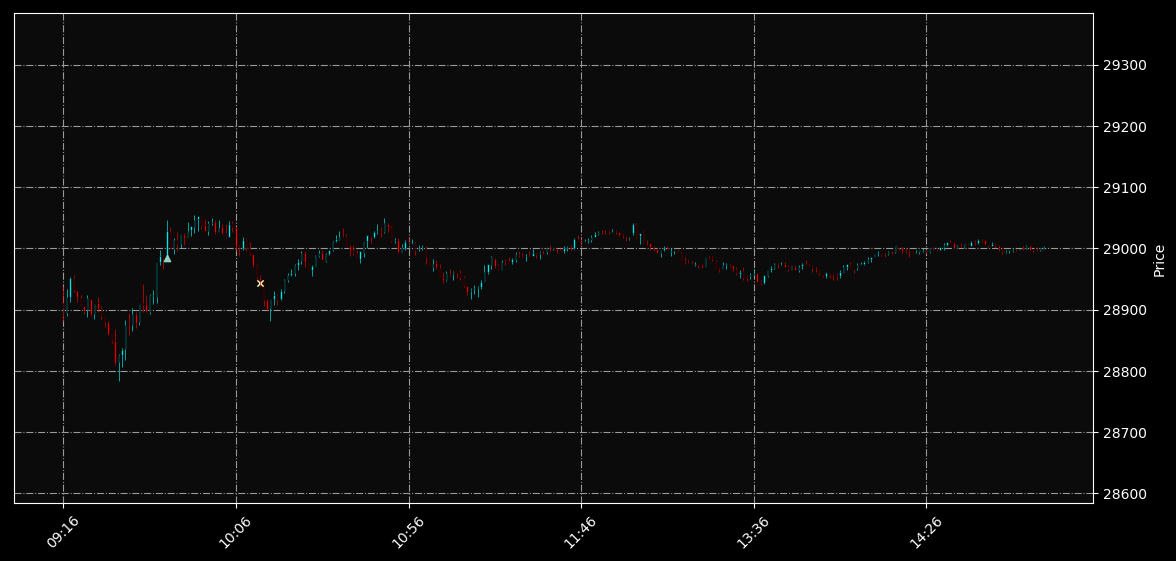

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
450        Buy              2       28971         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
450 2019-07-02 13:46:00     LExit             2      28931   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
450       -4120 2019-07-02 15:59:00                 7     loss

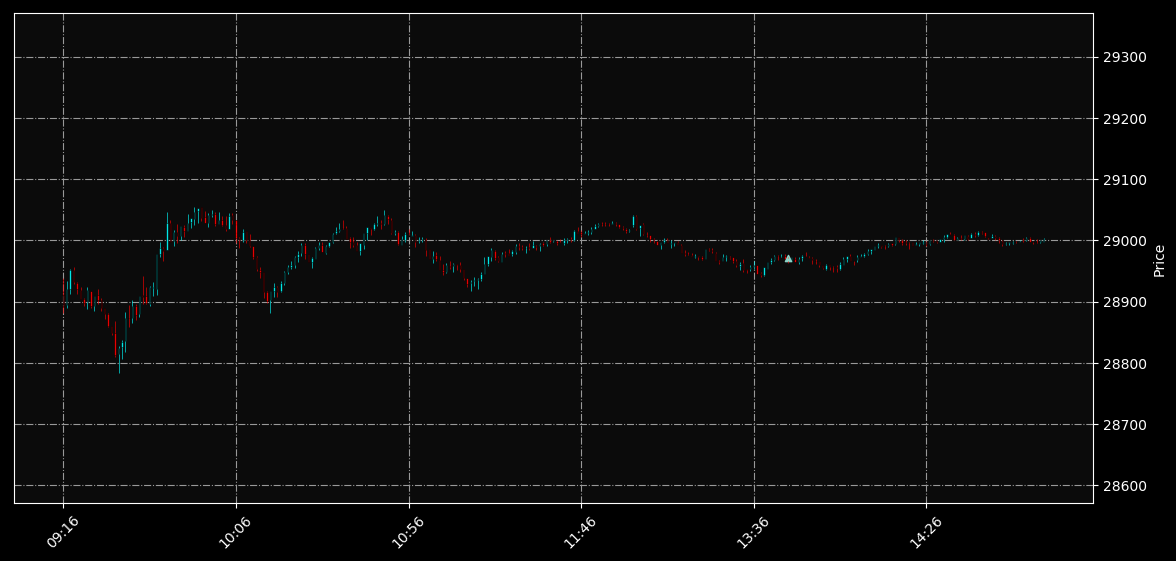

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
451       Sell              2       28851           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
451 2019-07-03 09:46:00     SExit             2      28891   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
451       -4120 2019-07-03 10:07:00                65     loss

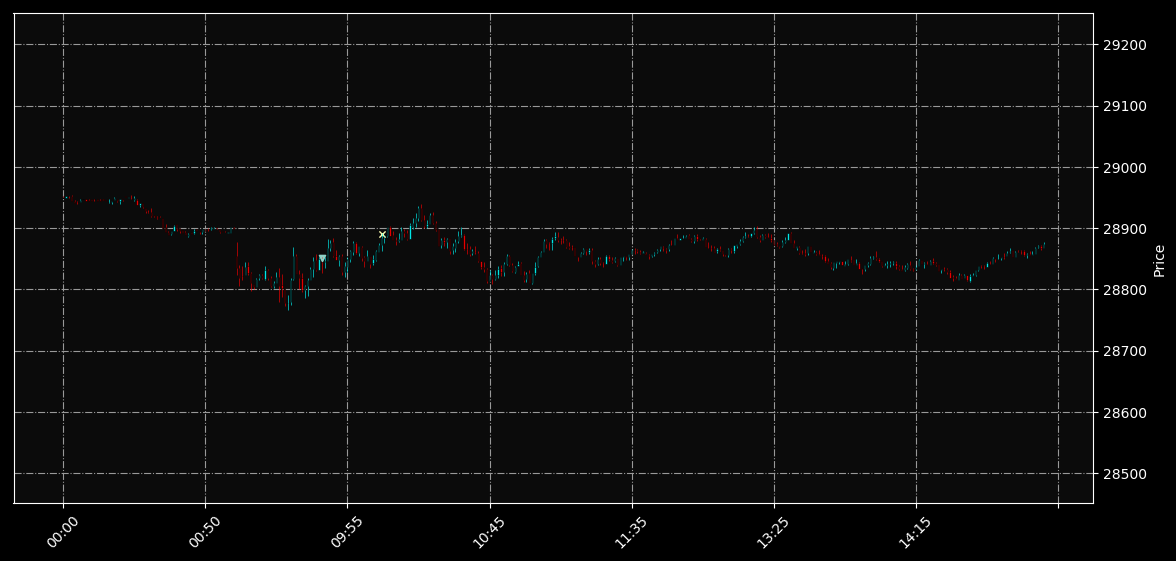

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
452       Sell              2       28835         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
452 2019-07-03 13:46:00     SExit             2      28875   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
452       -4120 2019-07-03 15:00:00                 1     loss

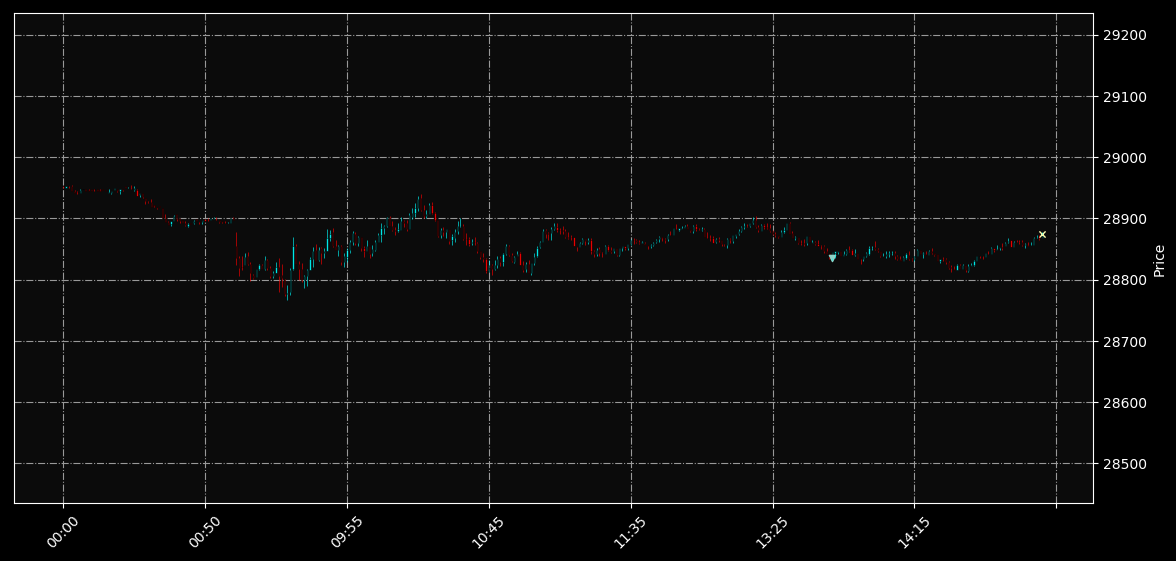

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
453        Buy              2       29030           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
453 2019-07-04 09:46:00     LExit             2      28990   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
453       -4120 2019-07-04 09:51:00                 5     loss

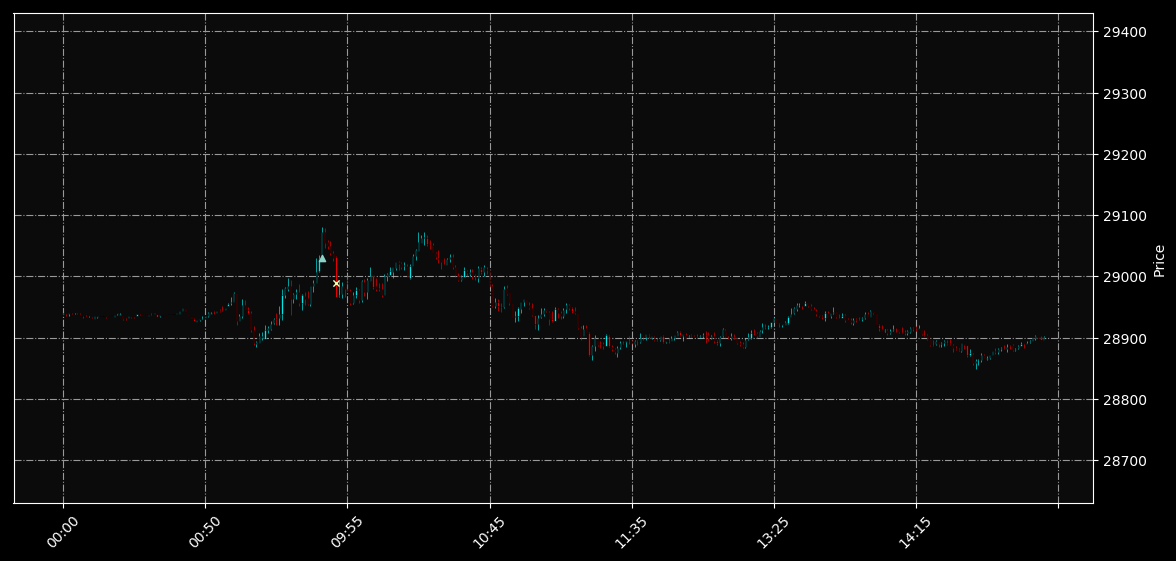

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
454        Buy              2       28940         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
454 2019-07-04 13:46:00     LExit             2      28900   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
454       -4120 2019-07-04 14:19:00                20     loss

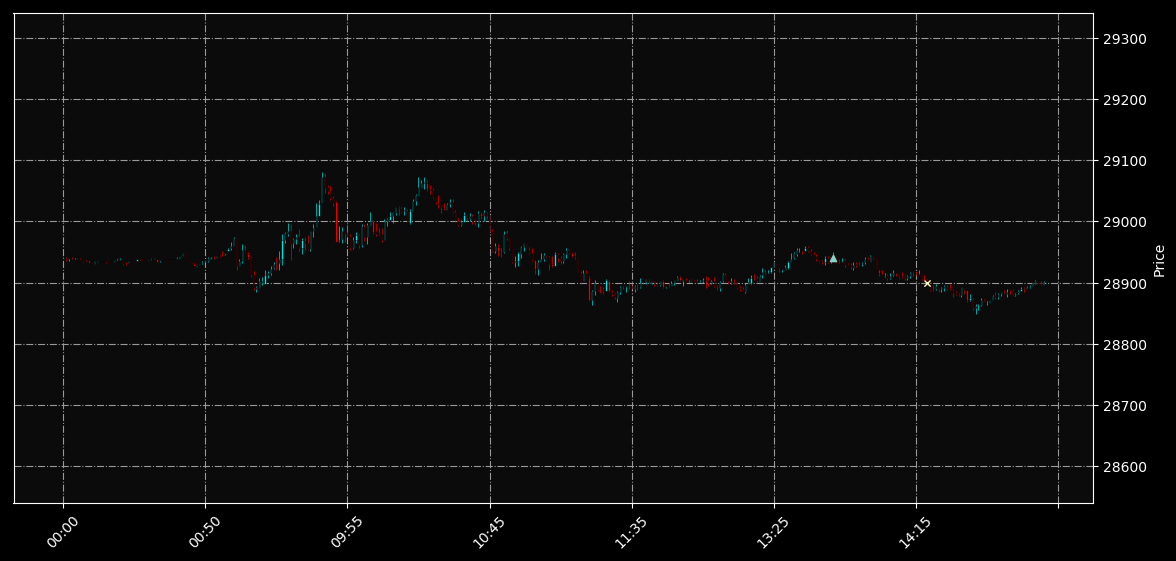

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
455       Sell              2       28802           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
455 2019-07-05 09:46:00     SExit             2      28842   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
455       -4120 2019-07-05 09:47:00                14     loss

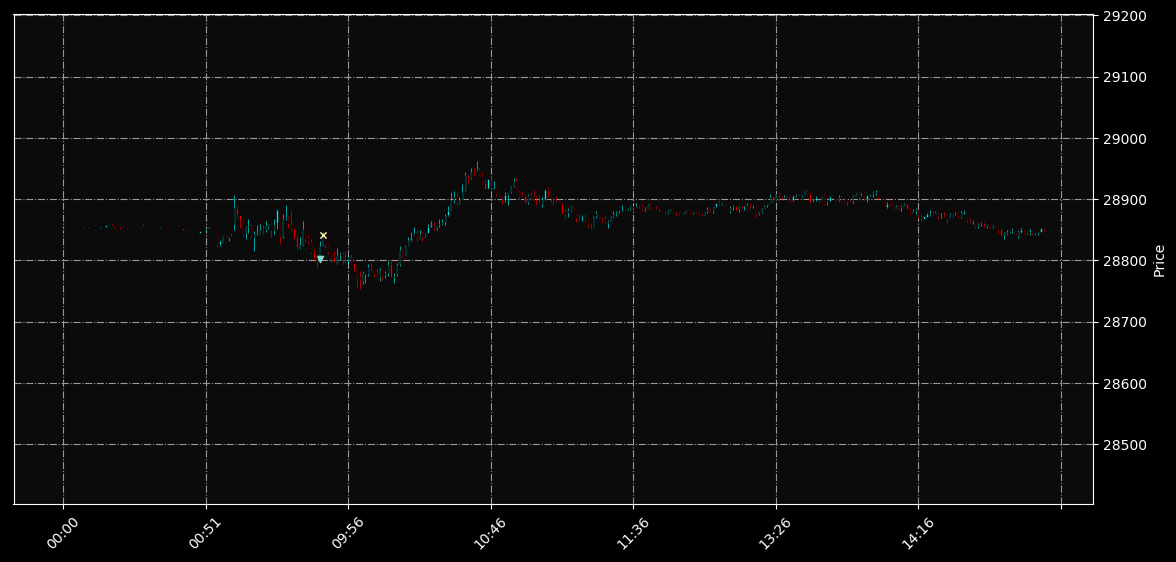

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
456        Buy              2       28903         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
456 2019-07-05 13:46:00     LExit             2      28863   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
456       -4120 2019-07-05 14:26:00                14     loss

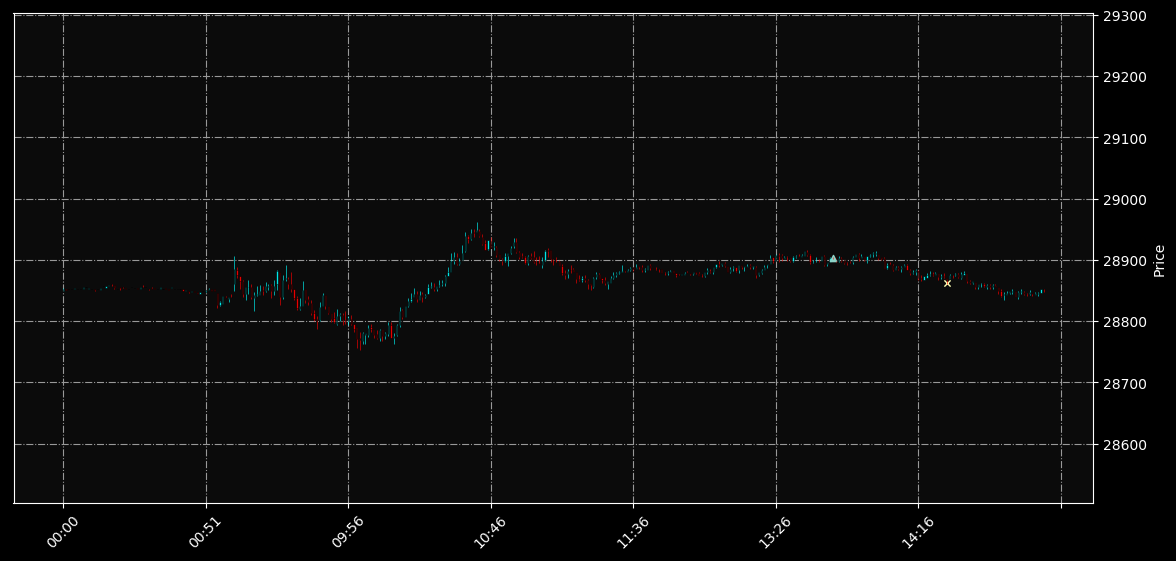

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
457       Sell              2       28409           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
457 2019-07-08 09:46:00     SExit             2      28449   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
457       -4120 2019-07-08 09:52:00                70     loss

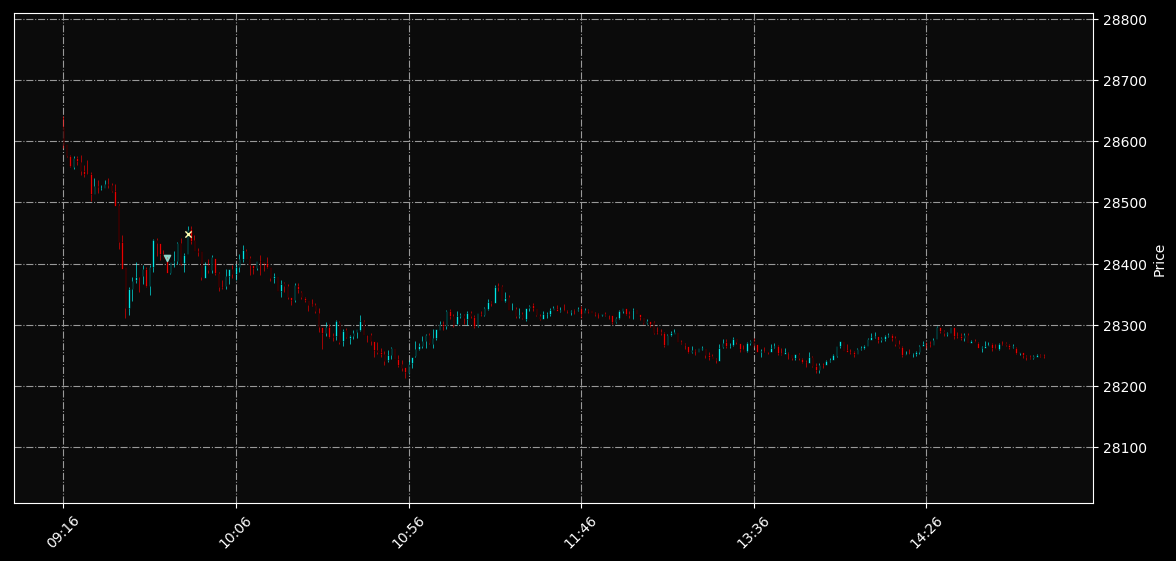

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
458       Sell              2       28254         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
458 2019-07-08 13:46:00     SExit             2      28294   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
458       -4120 2019-07-08 14:29:00                 7     loss

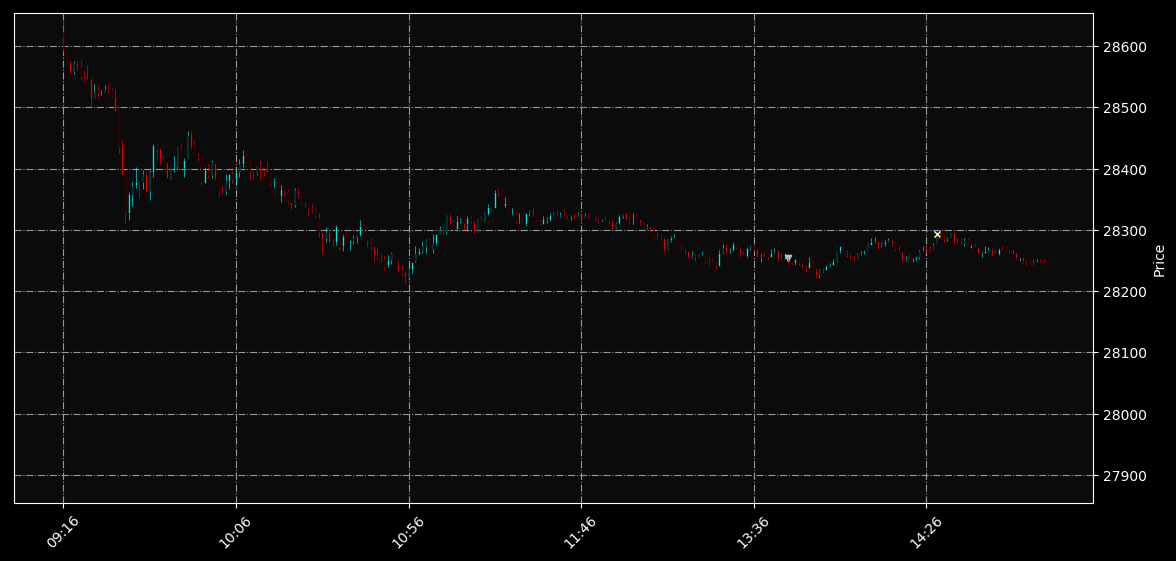

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
459       Sell              2       28151         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
459 2019-07-09 13:46:00     SExit             2      28191   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
459       -4120 2019-07-09 13:57:00                19     loss

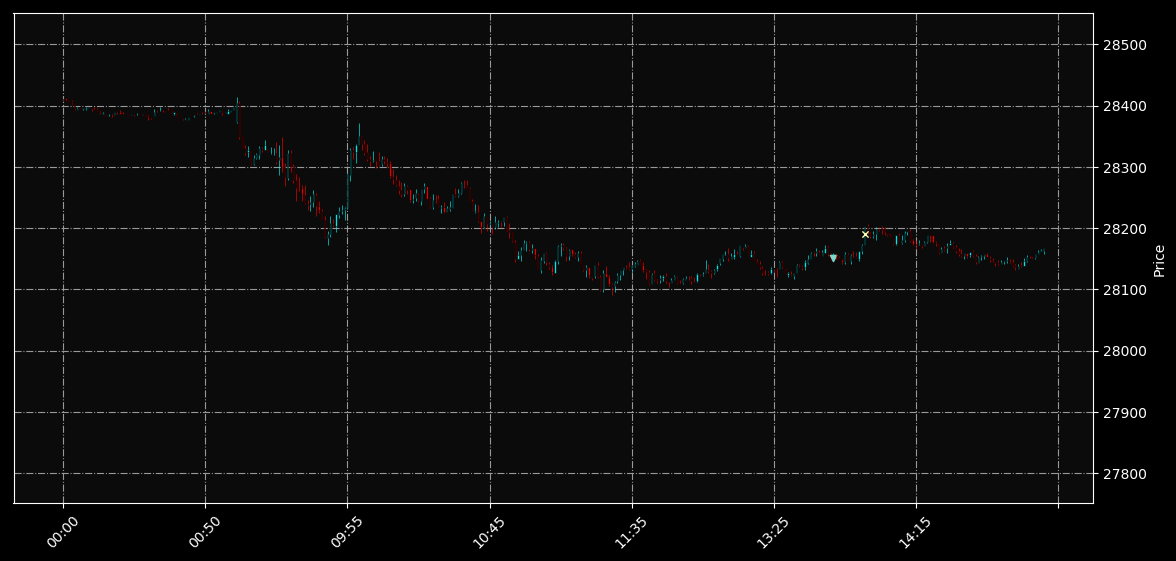

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
460        Buy              2       28265           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
460 2019-07-10 09:46:00     LExit             2      28225   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
460       -4120 2019-07-10 09:53:00                36     loss

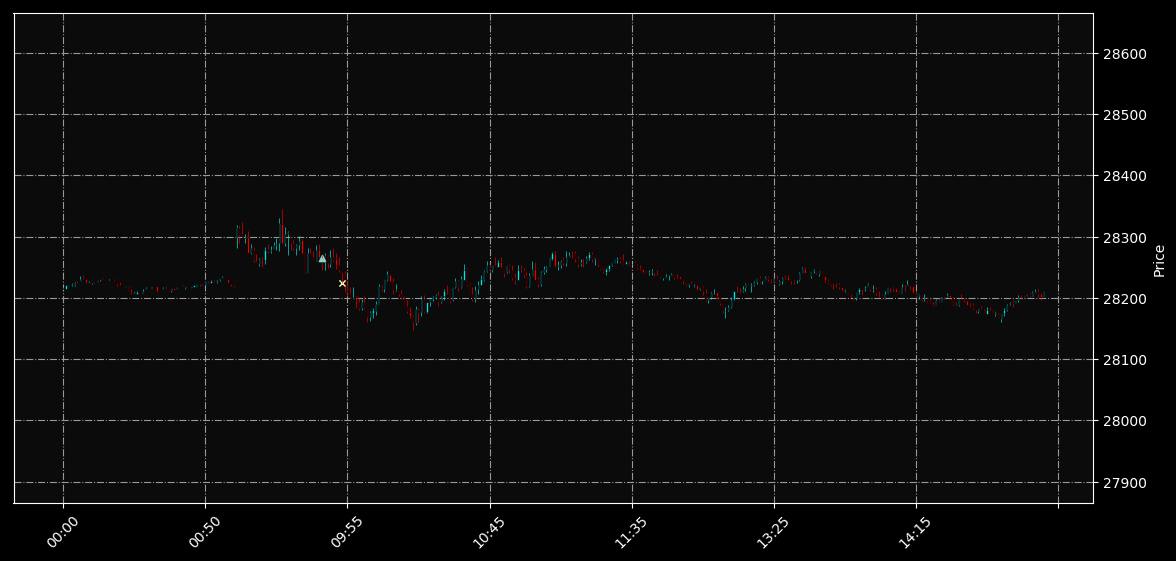

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
461        Buy              2       28222         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
461 2019-07-10 13:46:00     LExit             2      28182   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
461       -4120 2019-07-10 14:35:00                28     loss

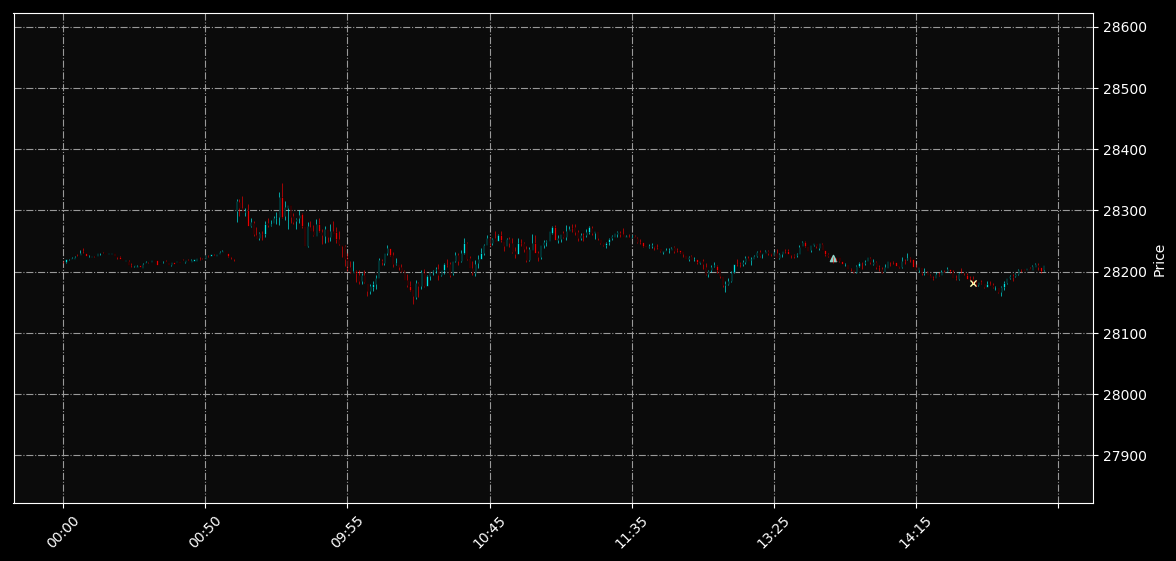

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
462        Buy              2       28501           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
462 2019-07-11 09:46:00     LExit             2      28573        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
462        7080 2019-07-11 10:07:00                49      win

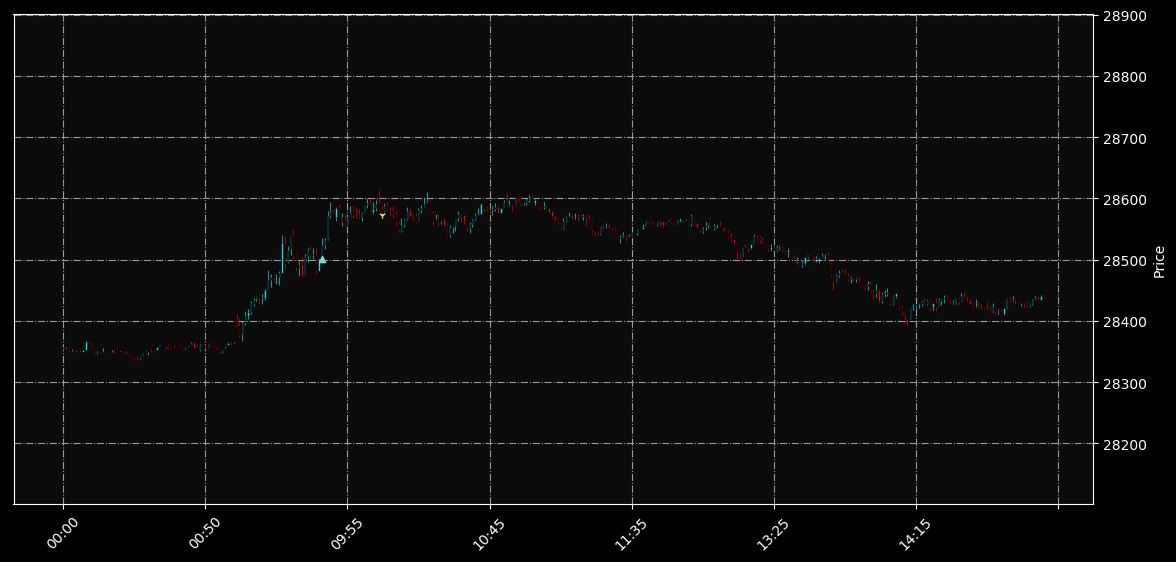

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
463        Buy              2       28476         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
463 2019-07-11 13:46:00     LExit             2      28436   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
463       -4120 2019-07-11 14:00:00                37     loss

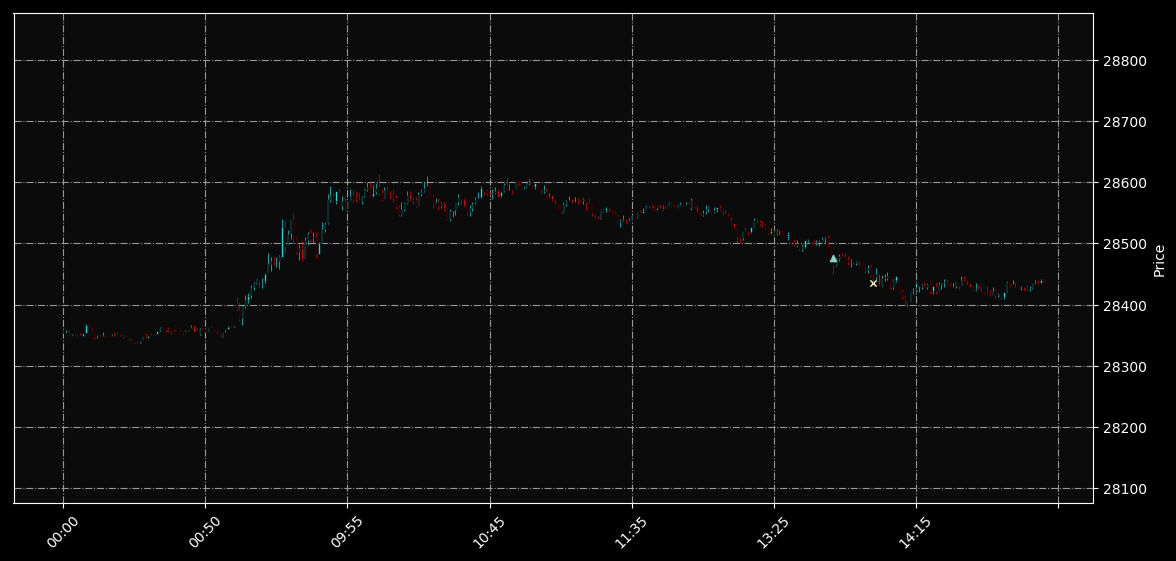

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
464        Buy              2       28479           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
464 2019-07-12 09:46:00     LExit             2      28439   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
464       -4120 2019-07-12 09:47:00                22     loss

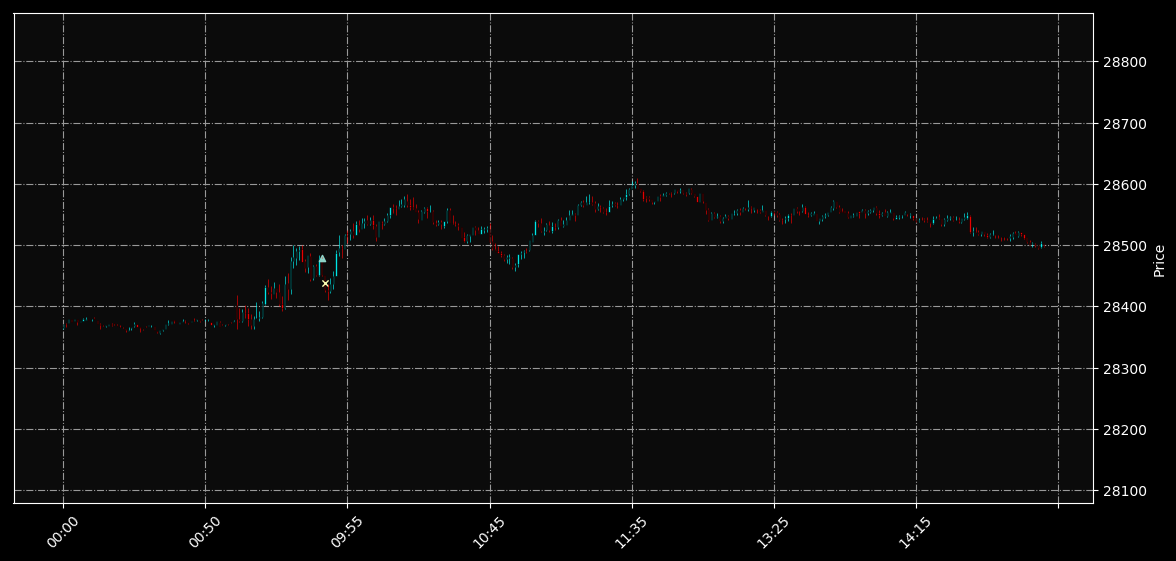

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
465        Buy              2       28561         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
465 2019-07-12 13:46:00     LExit             2      28521   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
465       -4120 2019-07-12 14:34:00                 3     loss

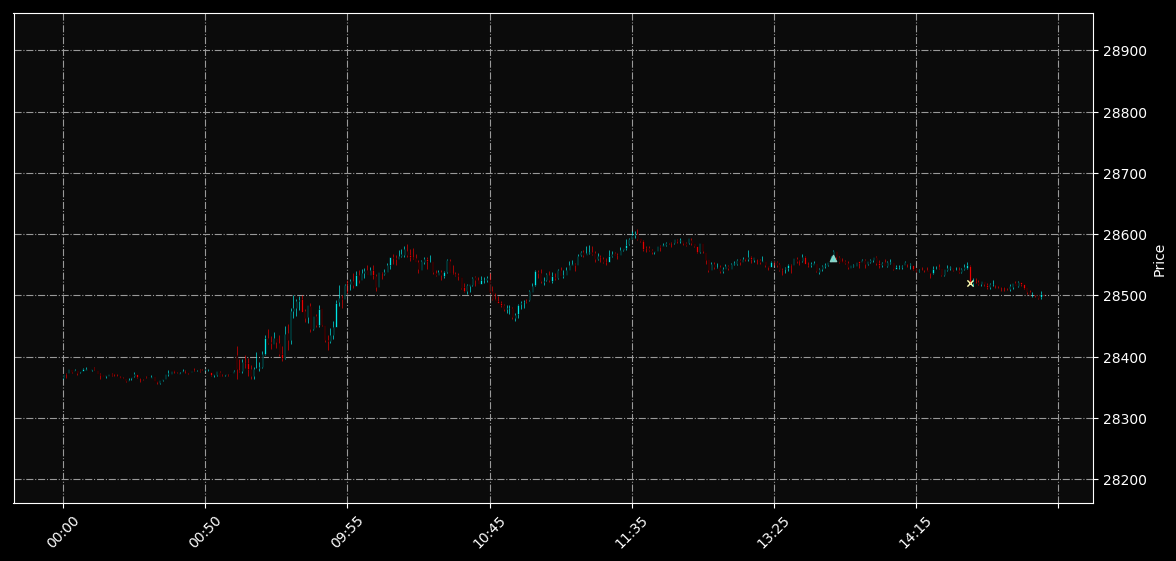

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
466       Sell              2       28136           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
466 2019-07-15 09:46:00     SExit             2      28176   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
466       -4120 2019-07-15 09:53:00                84     loss

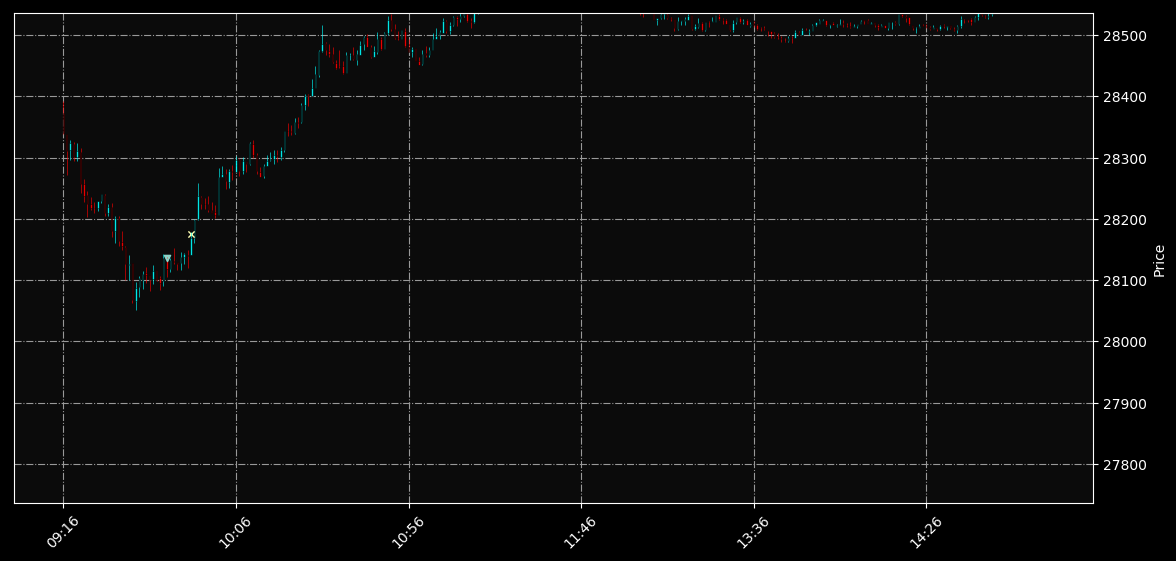

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
467        Buy              2       28491         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
467 2019-07-15 13:46:00     LExit             2      28543        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
467        5080 2019-07-15 16:07:00                32      win

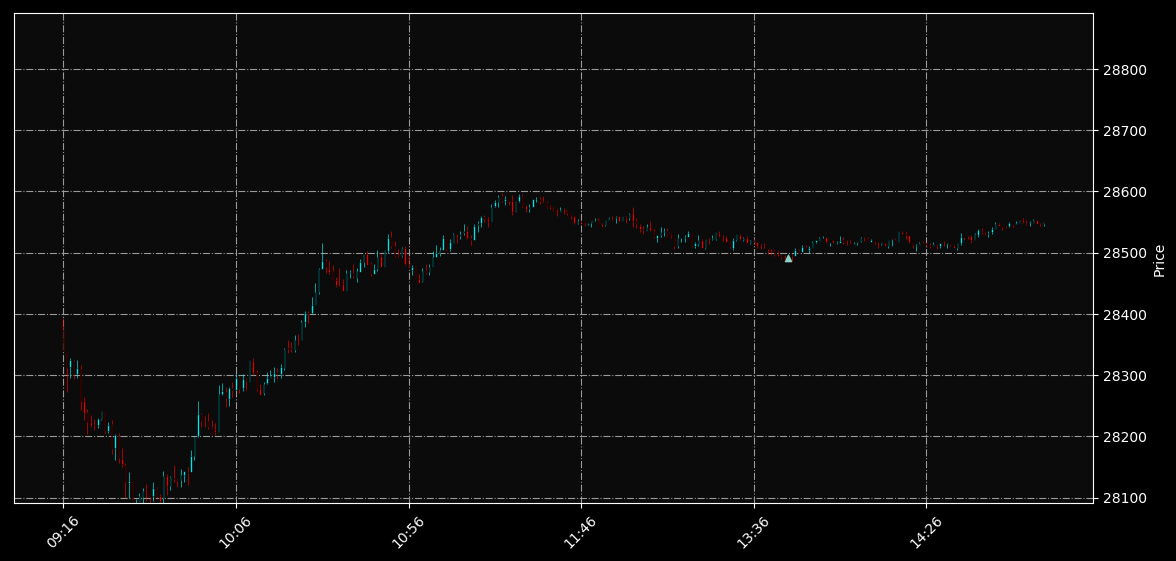

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
468        Buy              2       28597           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
468 2019-07-16 09:46:00     LExit             2      28557   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
468       -4120 2019-07-16 09:47:00                 5     loss

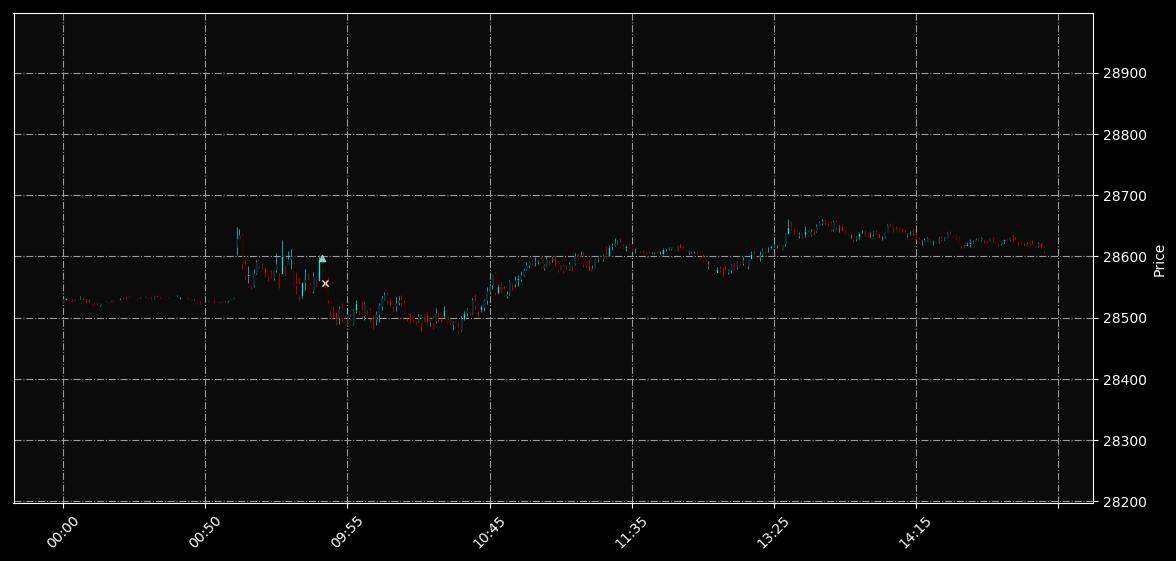

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
469        Buy              2       28645         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
469 2019-07-16 13:46:00     LExit             2      28605   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
469       -4120 2019-07-16 15:01:00                16     loss

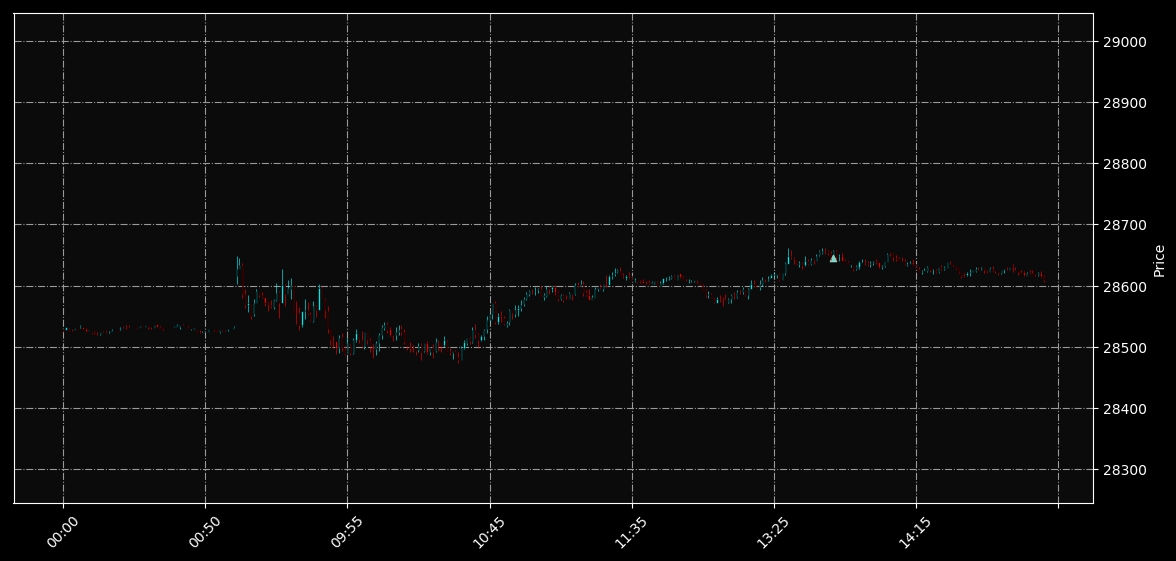

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
470       Sell              2       28486           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
470 2019-07-17 09:46:00     SExit             2      28526   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
470       -4120 2019-07-17 09:48:00               105     loss

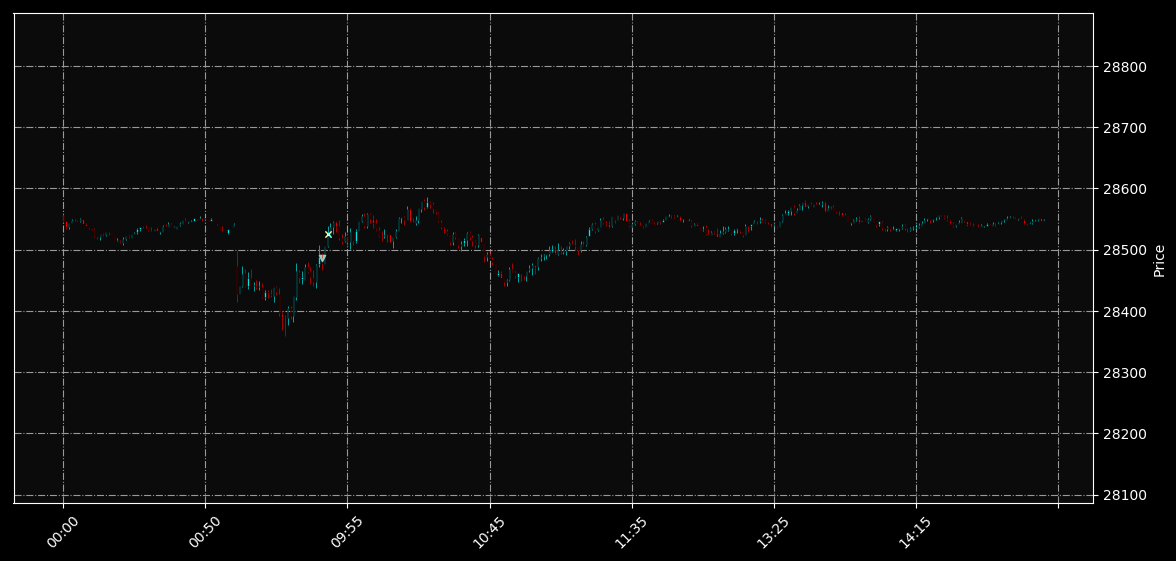

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
471        Buy              2       28569         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
471 2019-07-17 13:46:00     LExit             2      28529   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
471       -4120 2019-07-17 14:12:00                12     loss

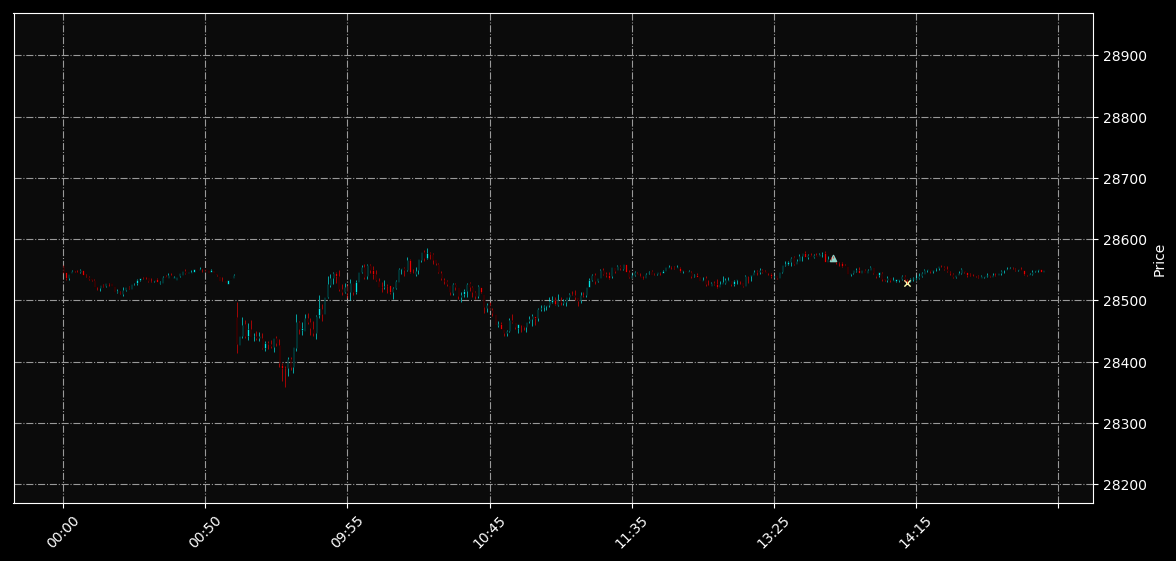

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
472       Sell              2       28442           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
472 2019-07-18 09:46:00     SExit             2      28482   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
472       -4120 2019-07-18 10:40:00                10     loss

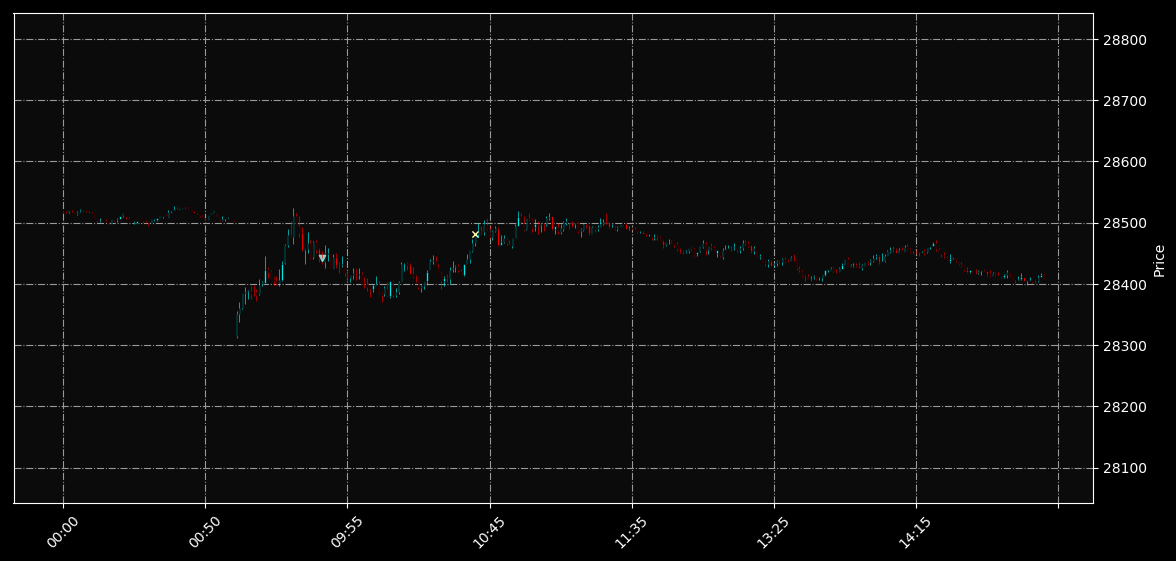

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
473       Sell              2       28426         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
473 2019-07-18 13:46:00     SExit             2      28466   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
473       -4120 2019-07-18 14:21:00                21     loss

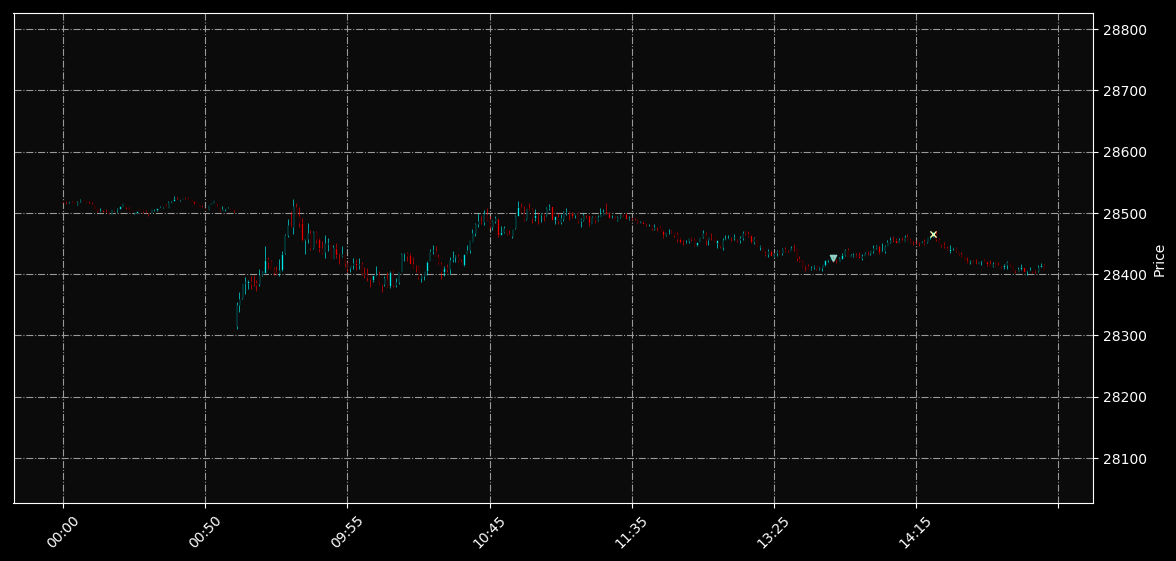

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
474        Buy              2       28716           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
474 2019-07-19 09:46:00     LExit             2      28789        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
474        7180 2019-07-19 10:19:00                36      win

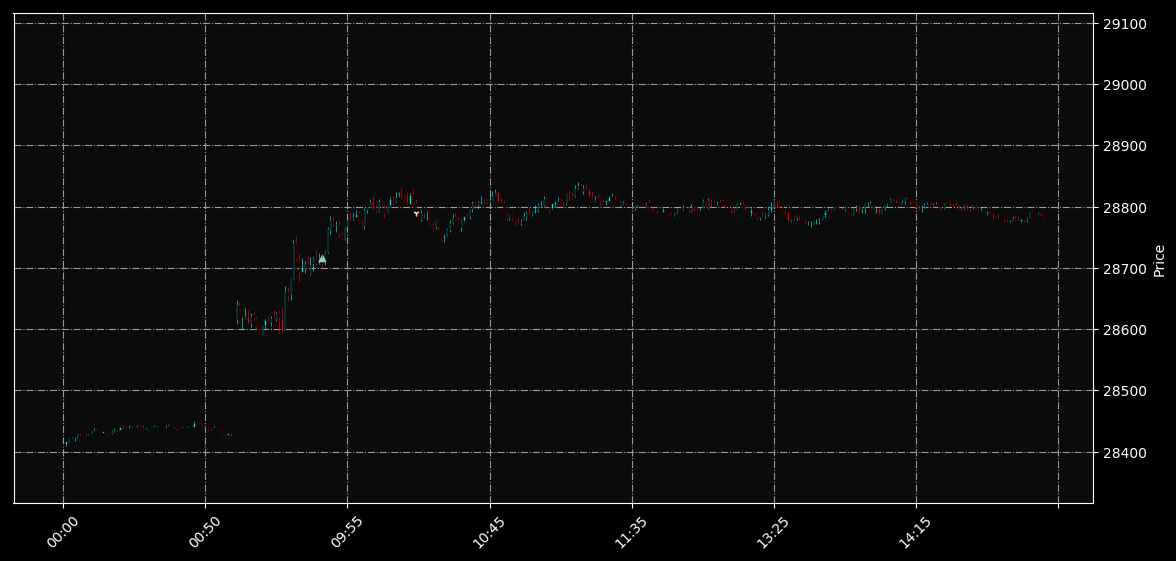

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
475        Buy              2       28795         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
475 2019-07-19 13:46:00     LExit             2      28755   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
475       -4120 2019-07-19 17:54:00                 3     loss

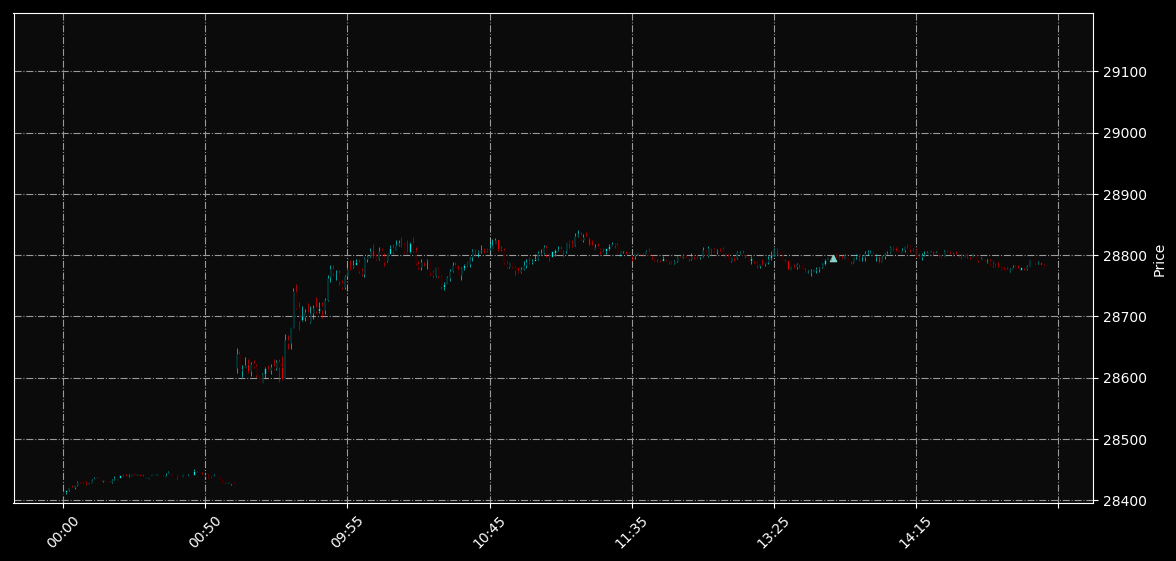

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
476       Sell              2       28565         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
476 2019-07-22 13:46:00     SExit             2      28445       Cover   

    exit_Profit           exit_Time pullback_at_entry win_loss  
476       11880 2019-07-22 14:47:00                 7      win

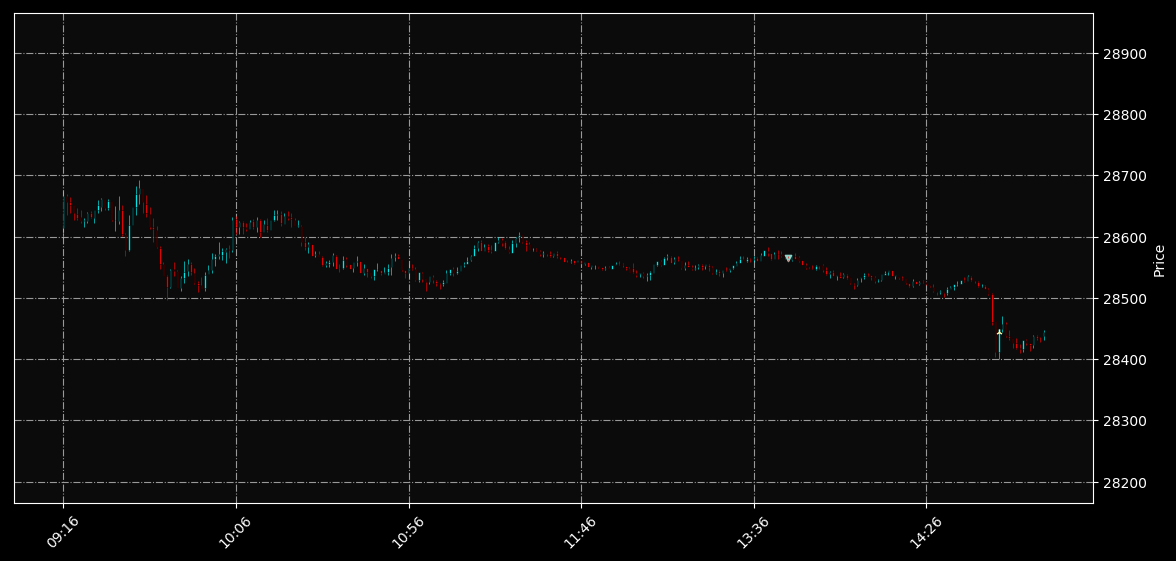

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
477        Buy              2       28397           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
477 2019-07-23 09:46:00     LExit             2      28441        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
477        4280 2019-07-23 10:22:00                 2      win

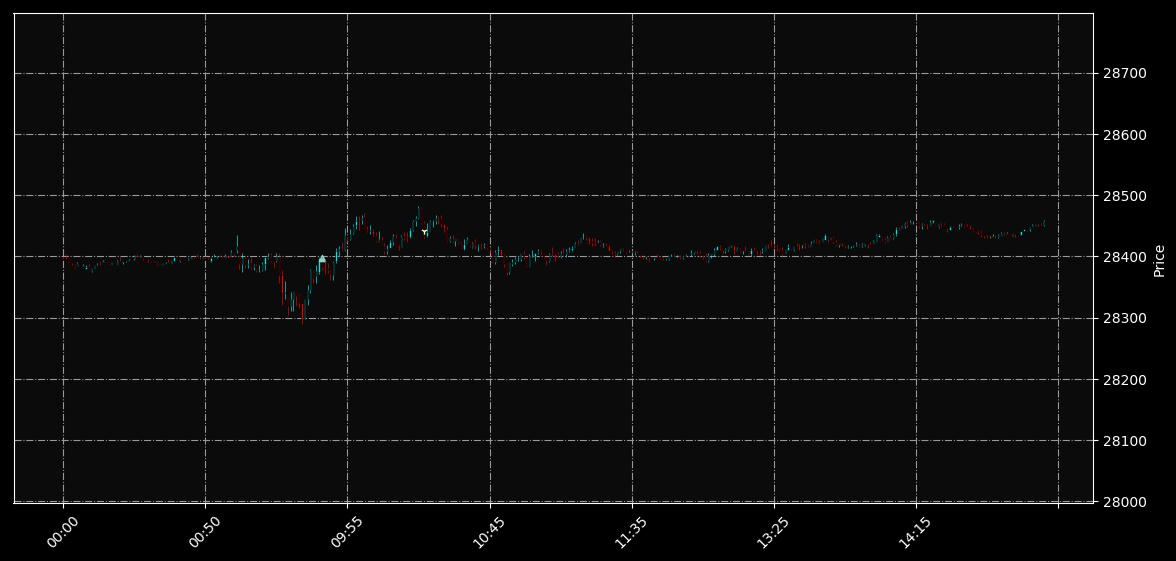

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
478        Buy              2       28431         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
478 2019-07-23 13:46:00     LExit             2      28495        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
478        6280 2019-07-23 21:36:00                 5      win

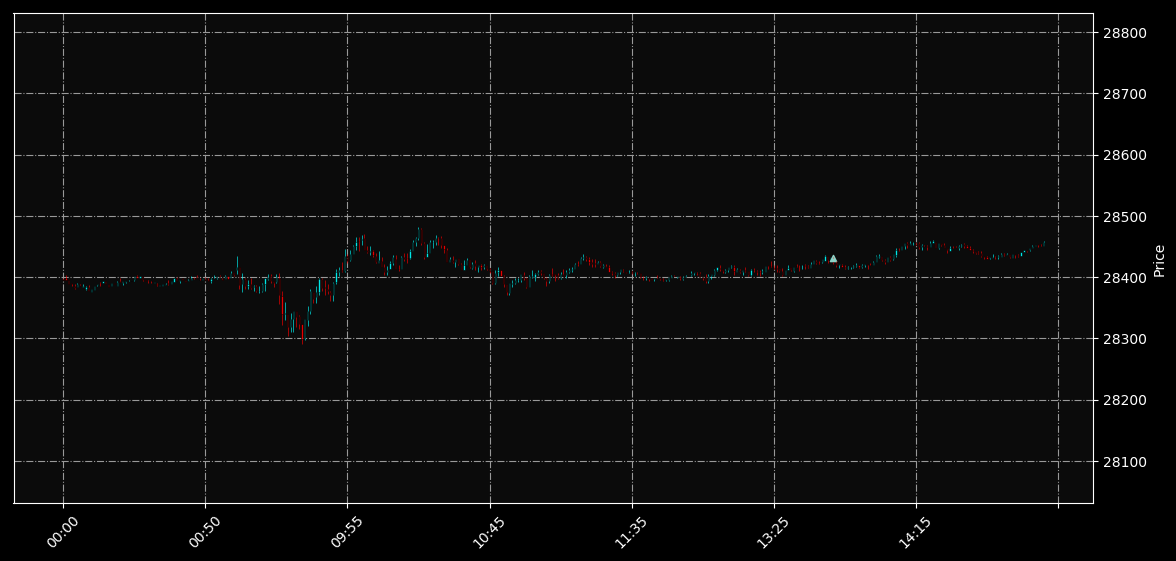

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
479        Buy              2       28686           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
479 2019-07-24 09:46:00     LExit             2      28730        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
479        4280 2019-07-24 10:13:00                43      win

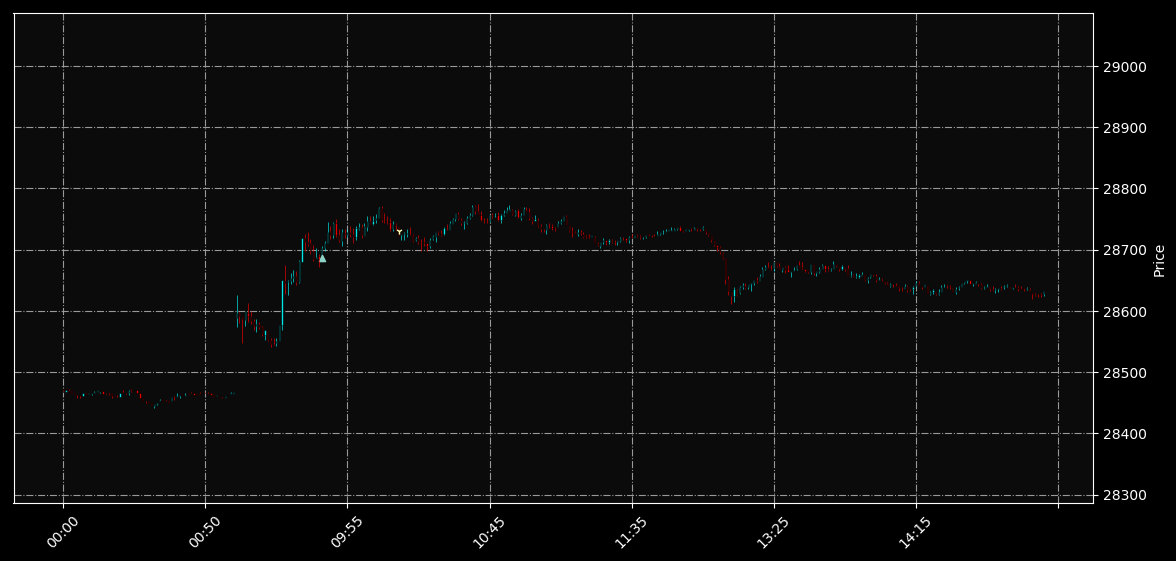

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
480        Buy              2       28669         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
480 2019-07-24 13:46:00     LExit             2      28629   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
480       -4120 2019-07-24 14:14:00                 8     loss

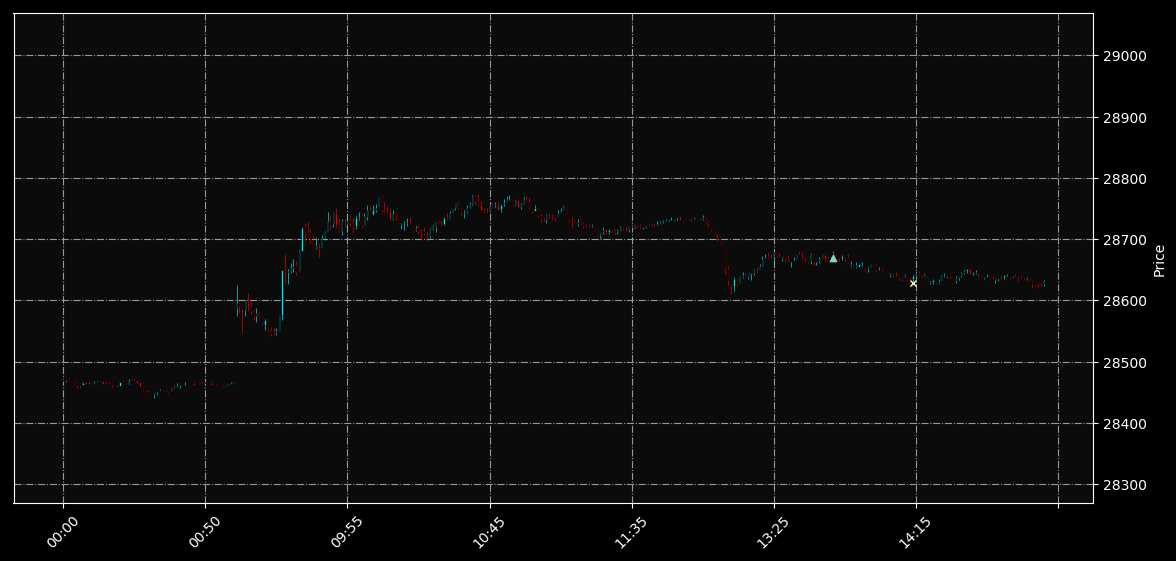

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
481        Buy              2       28576           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
481 2019-07-25 09:46:00     LExit             2      28536   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
481       -4120 2019-07-25 10:00:00                64     loss

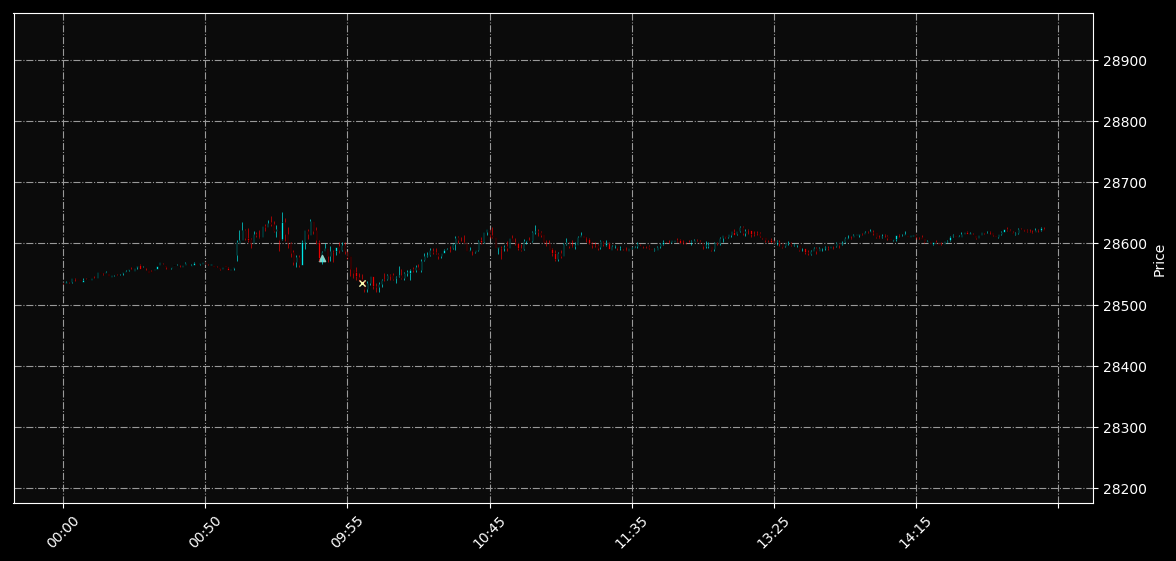

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
482        Buy              2       28595         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
482 2019-07-25 13:46:00     LExit             2      28555   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
482       -4120 2019-07-25 21:25:00                 1     loss

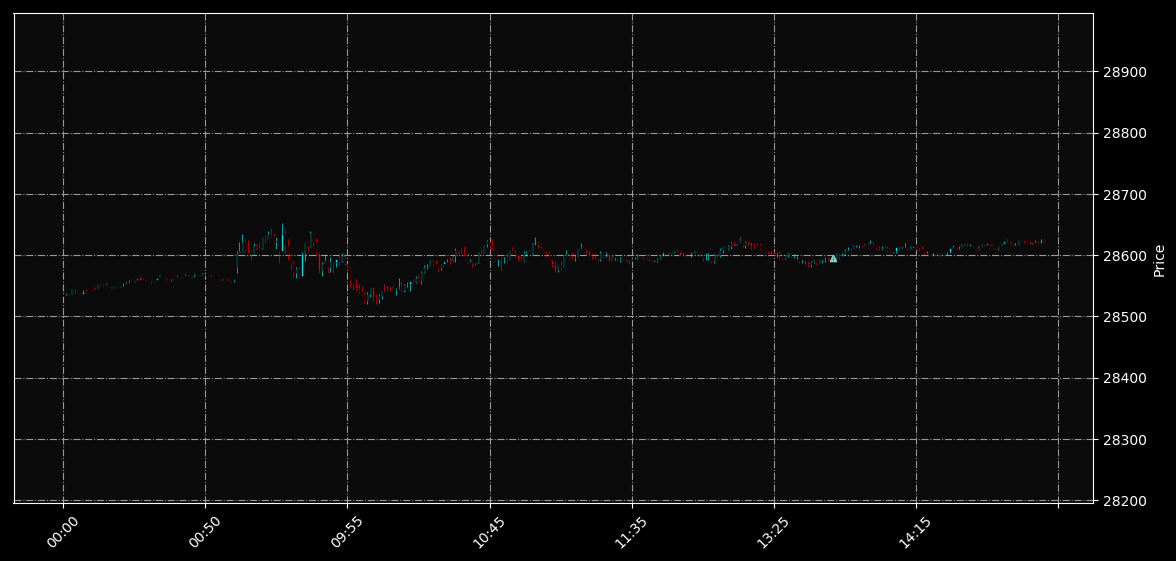

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
483        Buy              2       28411           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
483 2019-07-26 09:46:00     LExit             2      28371   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
483       -4120 2019-07-26 09:48:00                 9     loss

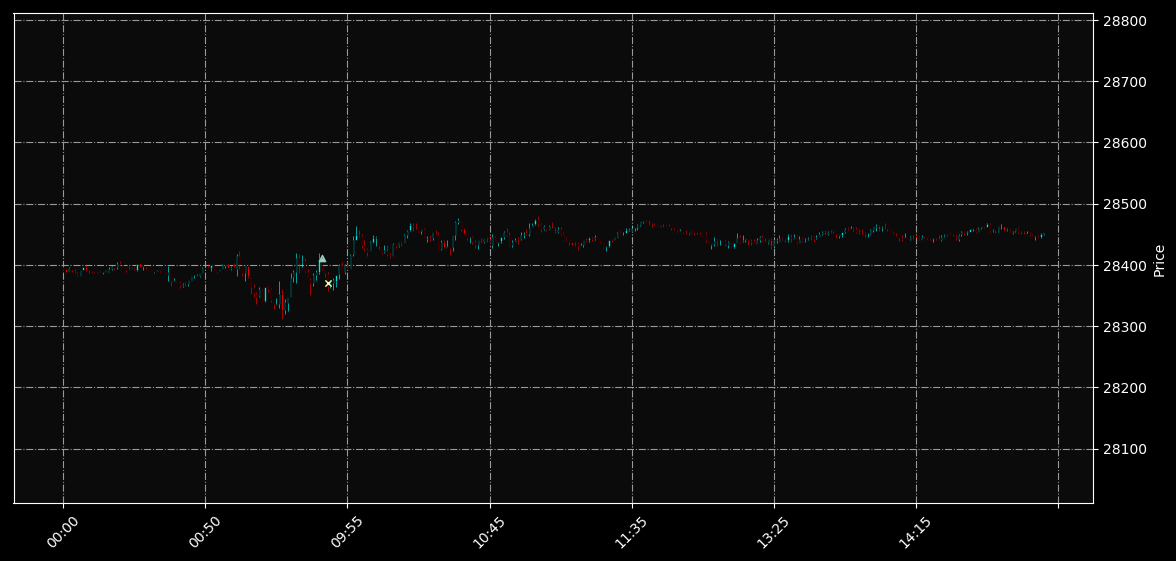

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
484        Buy              2       28452         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
484 2019-07-26 13:46:00     LExit             2      28412   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
484       -4120 2019-07-26 15:15:00                 5     loss

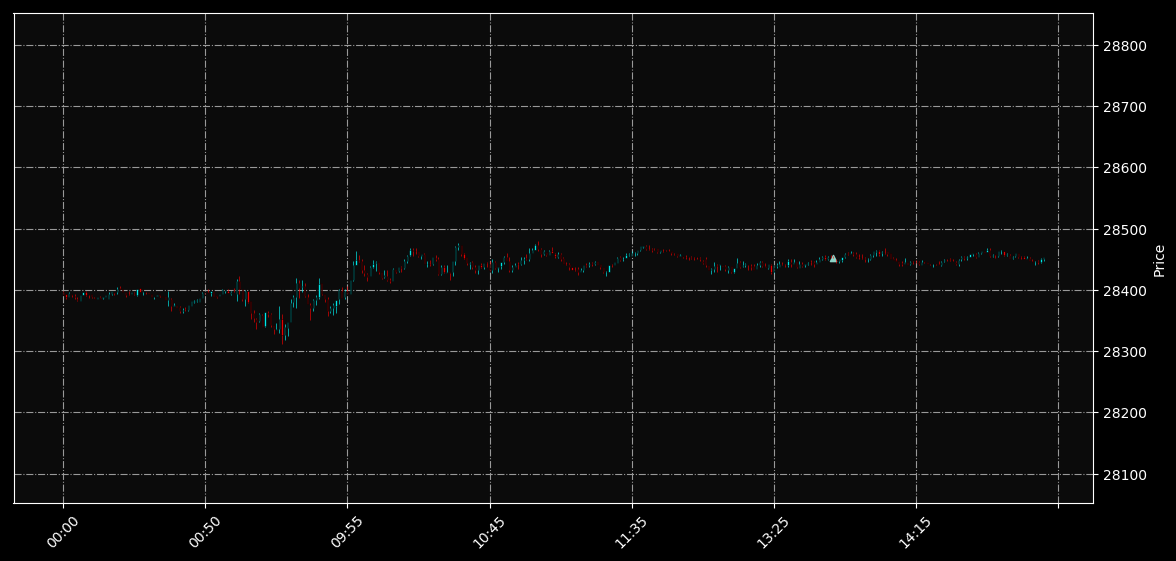

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
485       Sell              2       28221           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
485 2019-07-29 09:46:00     SExit             2      28261   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
485       -4120 2019-07-29 09:47:00                34     loss

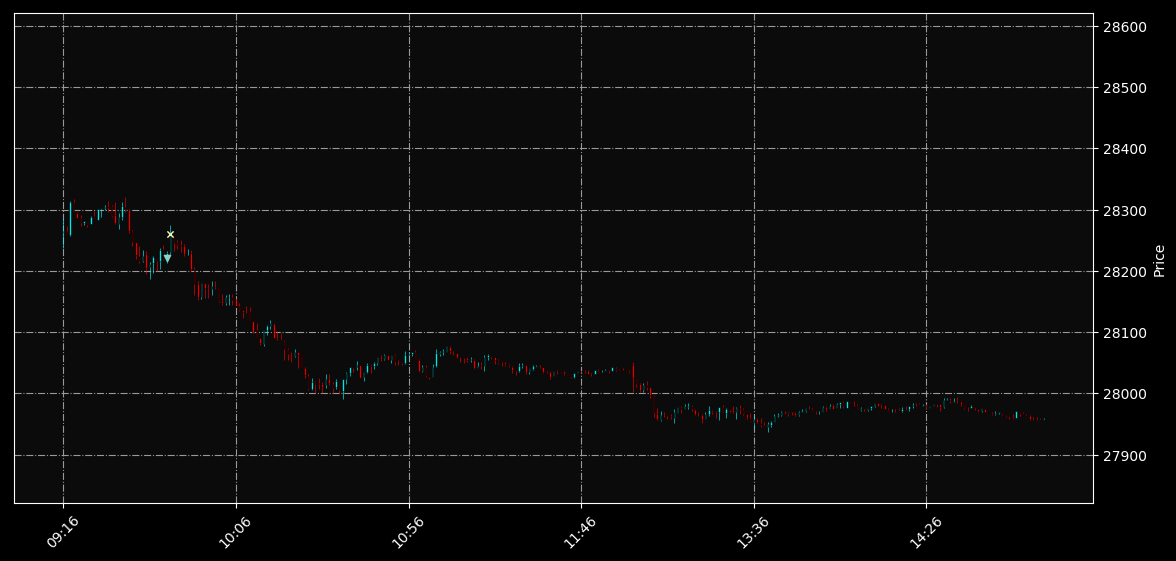

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
486       Sell              2       27968         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
486 2019-07-29 13:46:00     SExit             2      28008   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
486       -4120 2019-07-29 15:13:00                31     loss

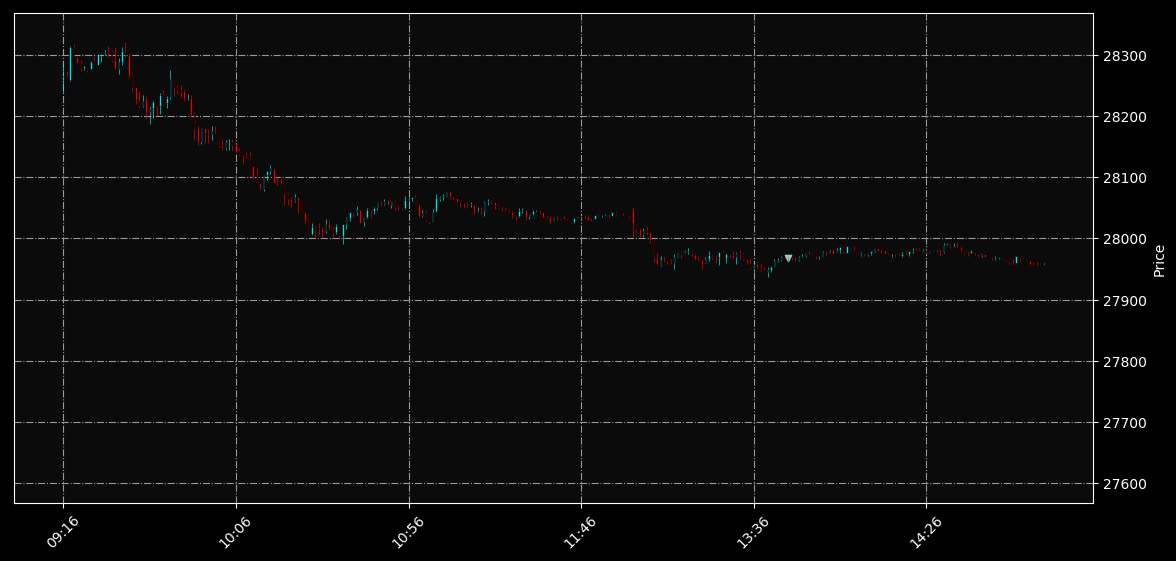

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
487        Buy              2       28168           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
487 2019-07-30 09:46:00     LExit             2      28128   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
487       -4120 2019-07-30 09:52:00                 2     loss

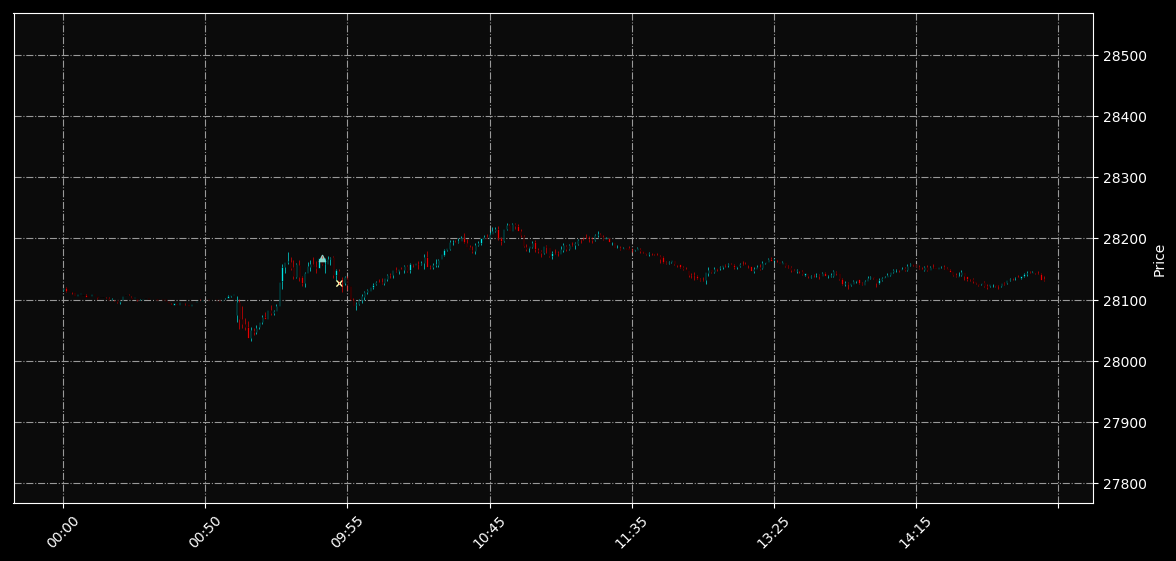

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
488        Buy              2       28139         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
488 2019-07-30 13:46:00     LExit             2      28099   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
488       -4120 2019-07-30 17:16:00                 7     loss

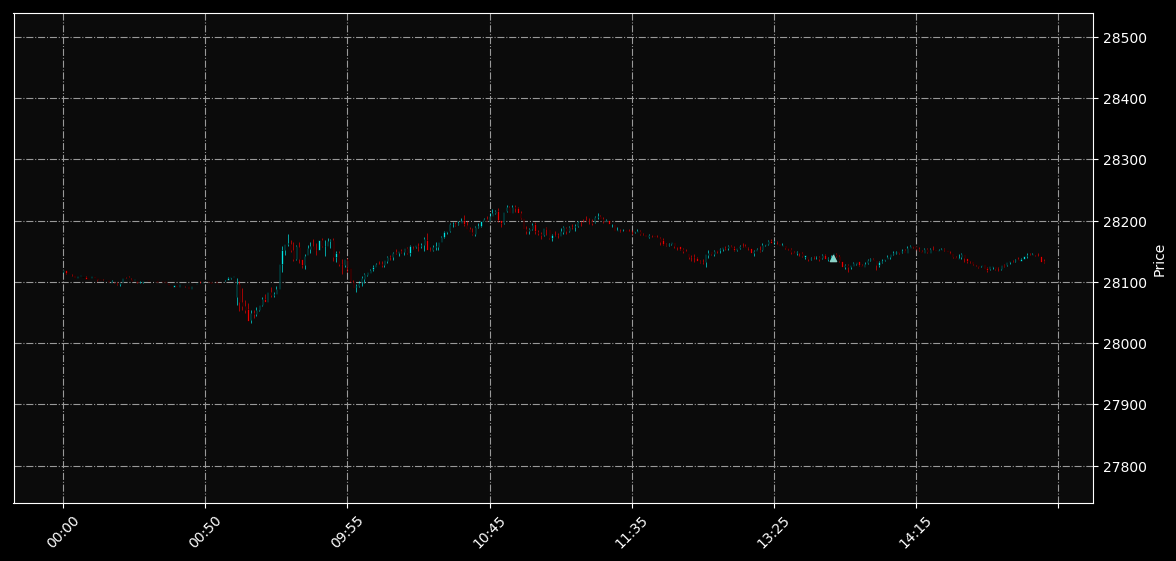

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
489       Sell              2       27813           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
489 2019-07-31 09:46:00     SExit             2      27708       Cover   

    exit_Profit           exit_Time pullback_at_entry win_loss  
489       10380 2019-07-31 10:17:00                24      win

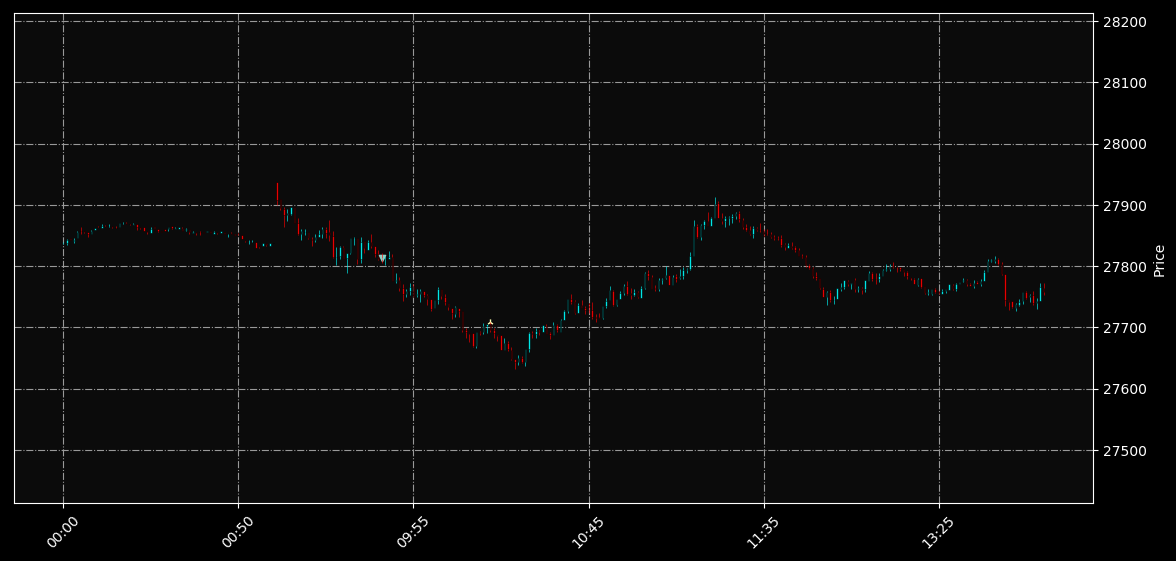

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
490       Sell              2       27743         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price      exit_Signal  \
490 2019-07-31 13:46:00     SExit             2      27757  End of Day Exit   

    exit_Profit           exit_Time pullback_at_entry win_loss  
490       -1520 2019-07-31 13:55:00                14     loss

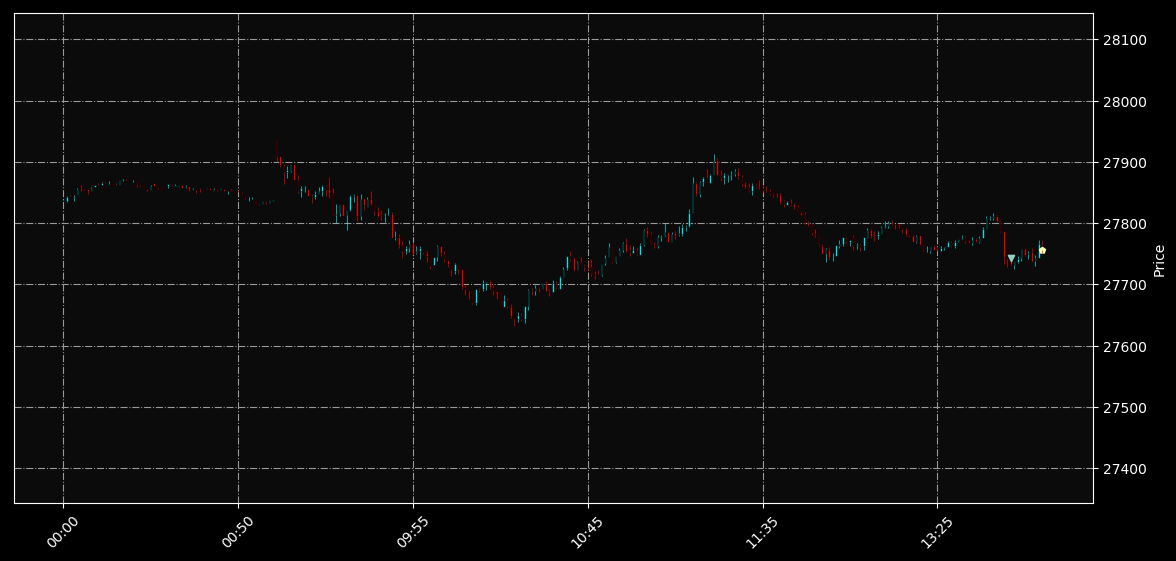

In [38]:
for i, trade in df_trades.query(str_201907).iterrows():
    plot_trade(trade, df_bar, my_style)

## Investigate trades in 2020-Aug, which had a good number of winning trades.
- Trades in 2020-Aug should indicate more strongly as to what caused the better performance of the strategy.

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
958       Sell              2       24450           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
958 2020-08-03 09:46:00     SExit             2      24490   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
958       -4120 2020-08-03 09:46:00                77     loss

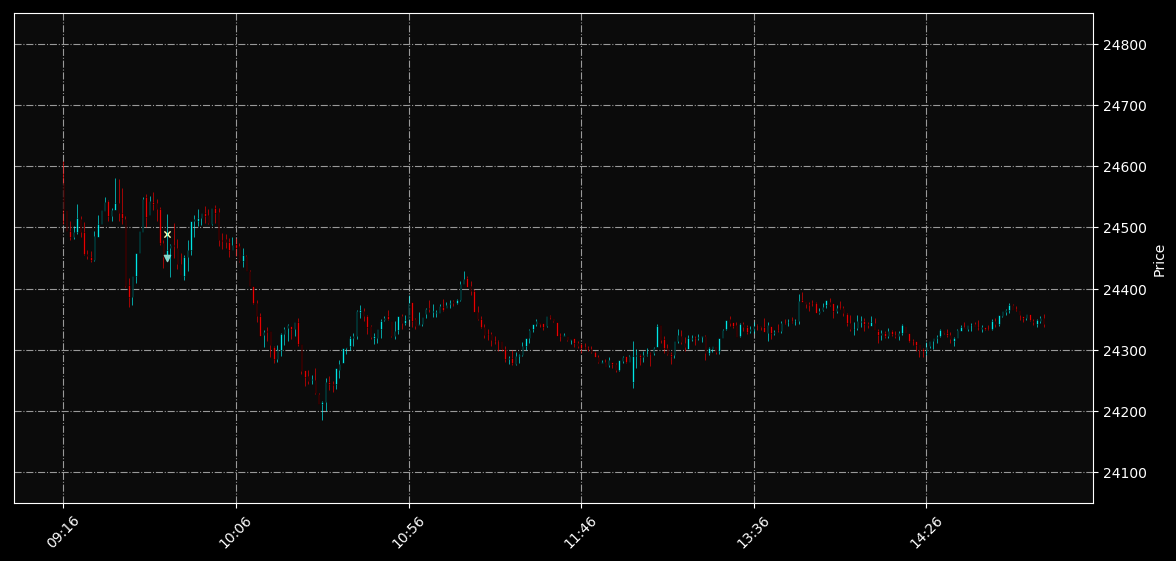

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
959       Sell              2       24345         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
959 2020-08-03 13:46:00     SExit             2      24385   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
959       -4120 2020-08-03 13:49:00                31     loss

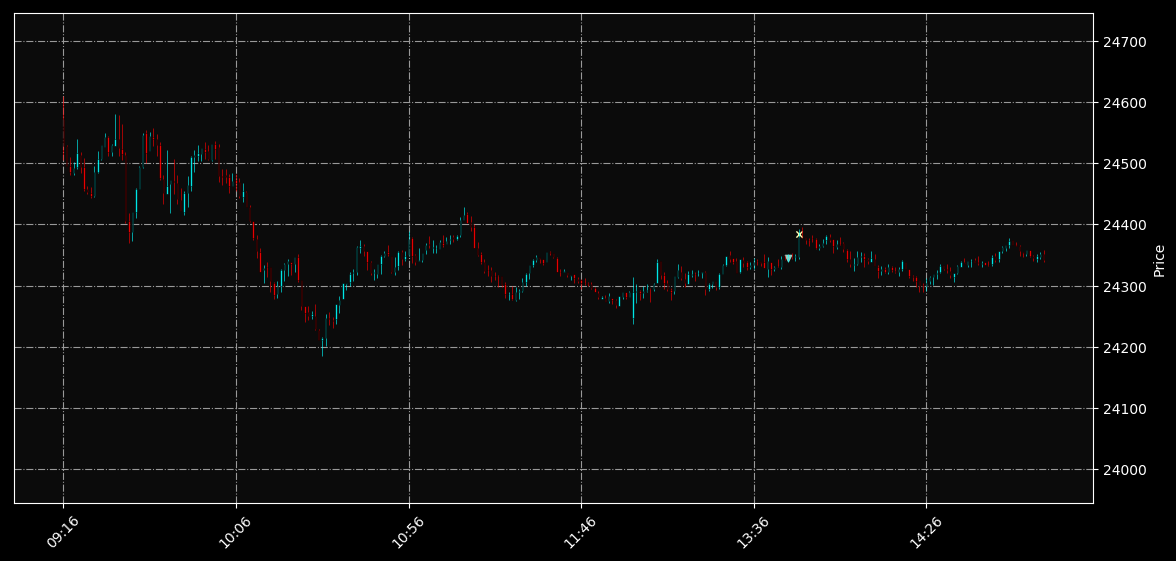

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
960        Buy              2       24552           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
960 2020-08-04 09:46:00     LExit             2      24609        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
960        5580 2020-08-04 10:18:00                78      win

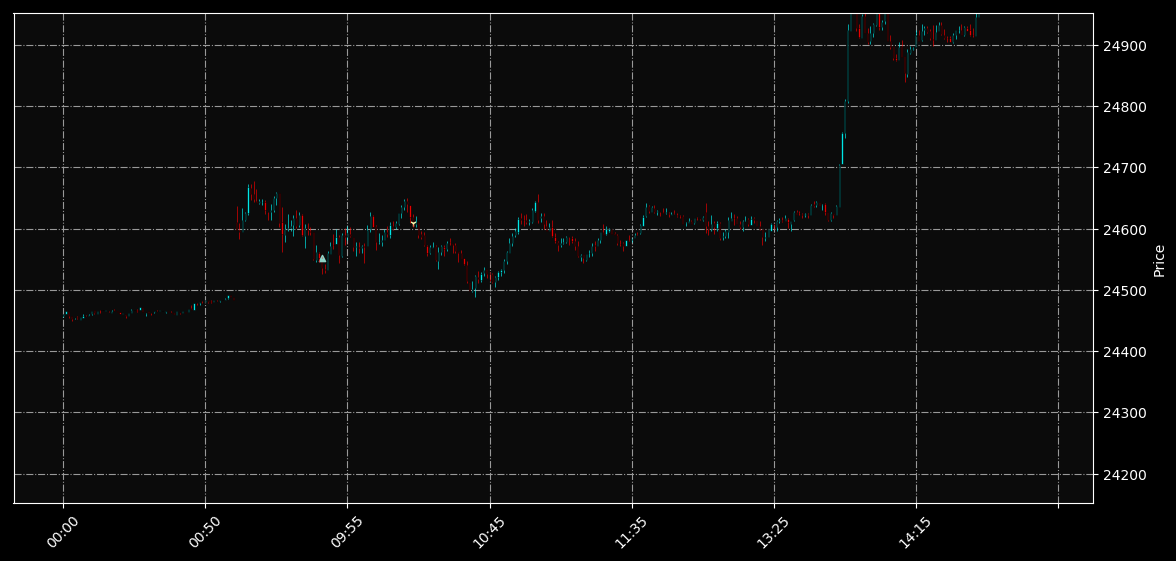

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
961        Buy              2       24625         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
961 2020-08-04 13:46:00     LExit             2      24965        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
961       33880 2020-08-04 13:53:00                21      win

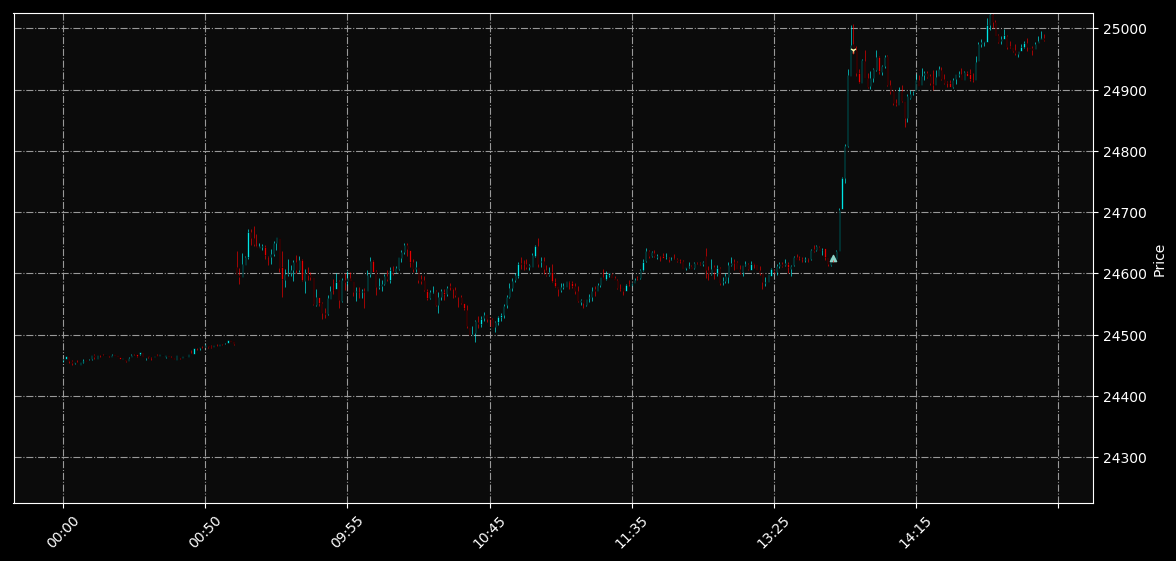

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
962        Buy              2       24962           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
962 2020-08-05 09:46:00     LExit             2      24922   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
962       -4120 2020-08-05 09:46:00                 7     loss

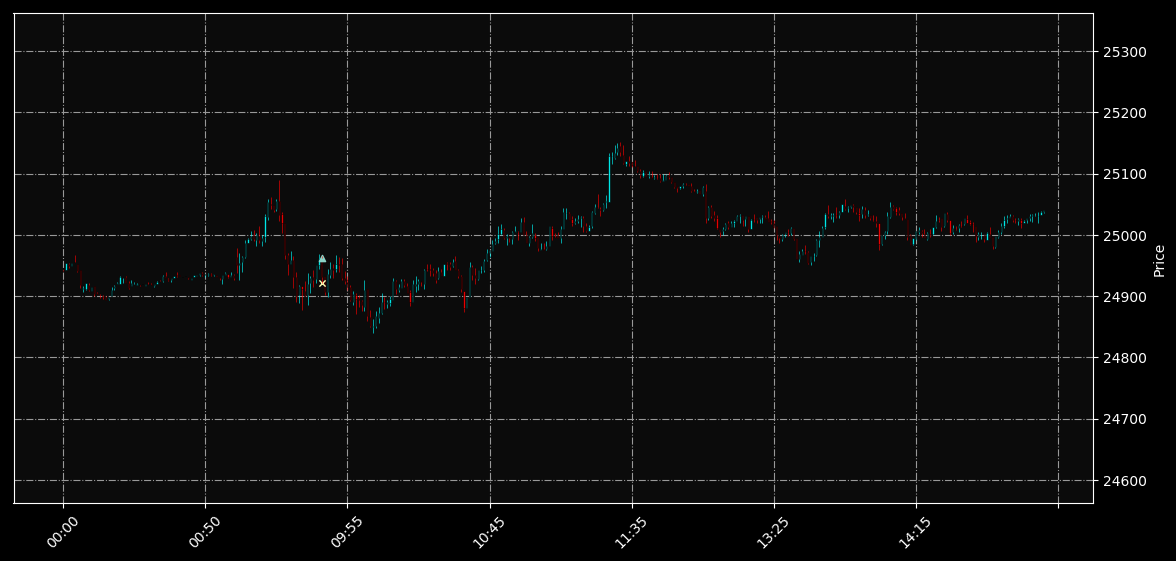

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
963        Buy              2       25031         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
963 2020-08-05 13:46:00     LExit             2      24991   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
963       -4120 2020-08-05 14:02:00                17     loss

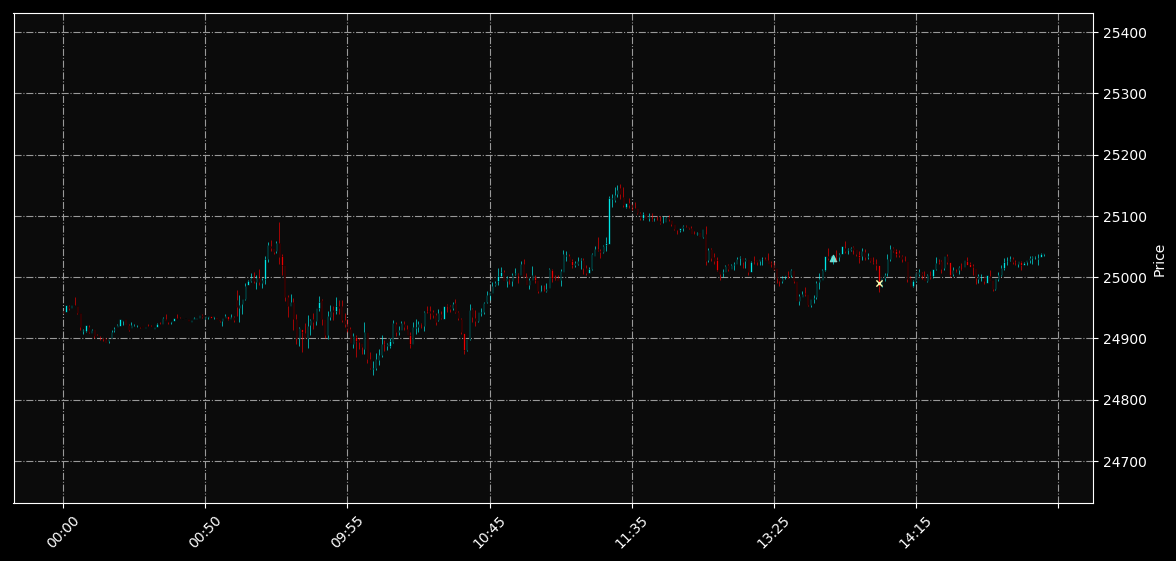

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
964       Sell              2       24686         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
964 2020-08-06 13:46:00     SExit             2      24726   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
964       -4120 2020-08-06 14:06:00                19     loss

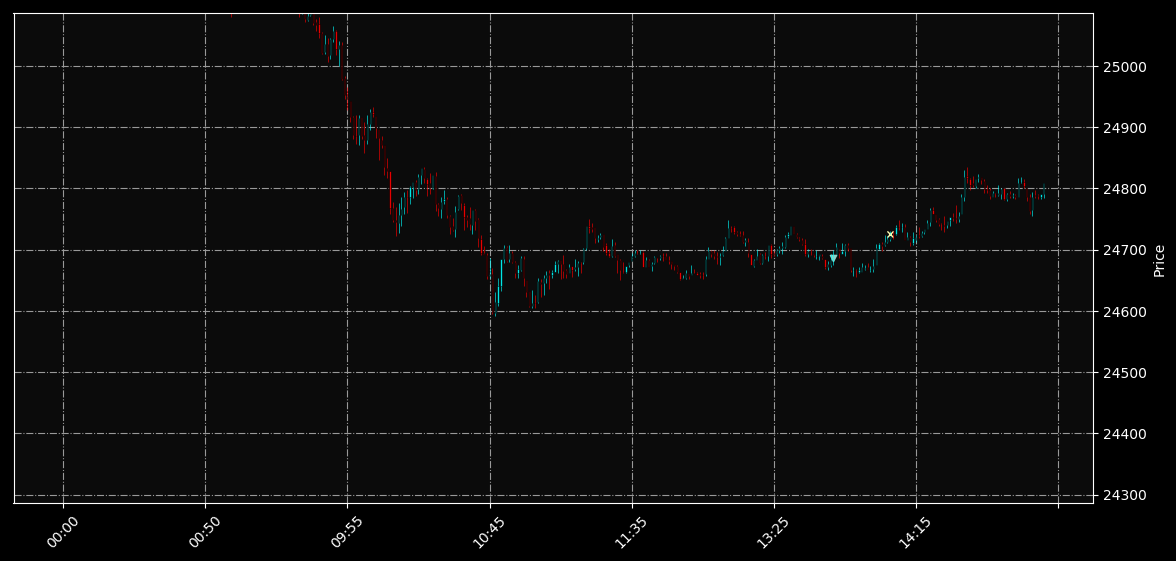

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
965       Sell              2       24732           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
965 2020-08-07 09:46:00     SExit             2      24772   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
965       -4120 2020-08-07 09:47:00                20     loss

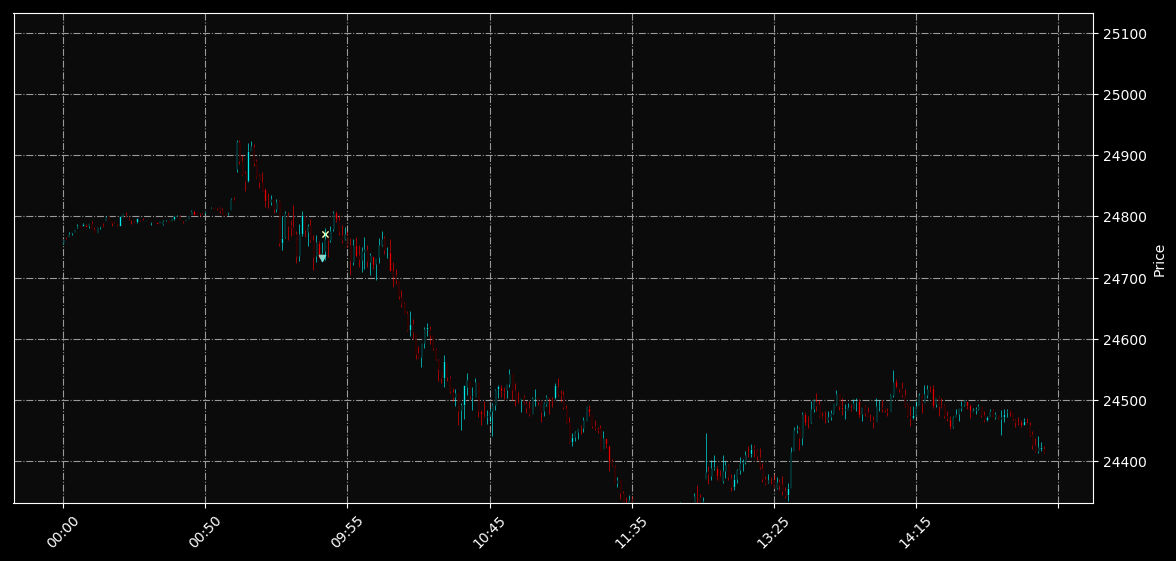

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
966       Sell              2       24479         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
966 2020-08-07 13:46:00     SExit             2      24519   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
966       -4120 2020-08-07 14:07:00                25     loss

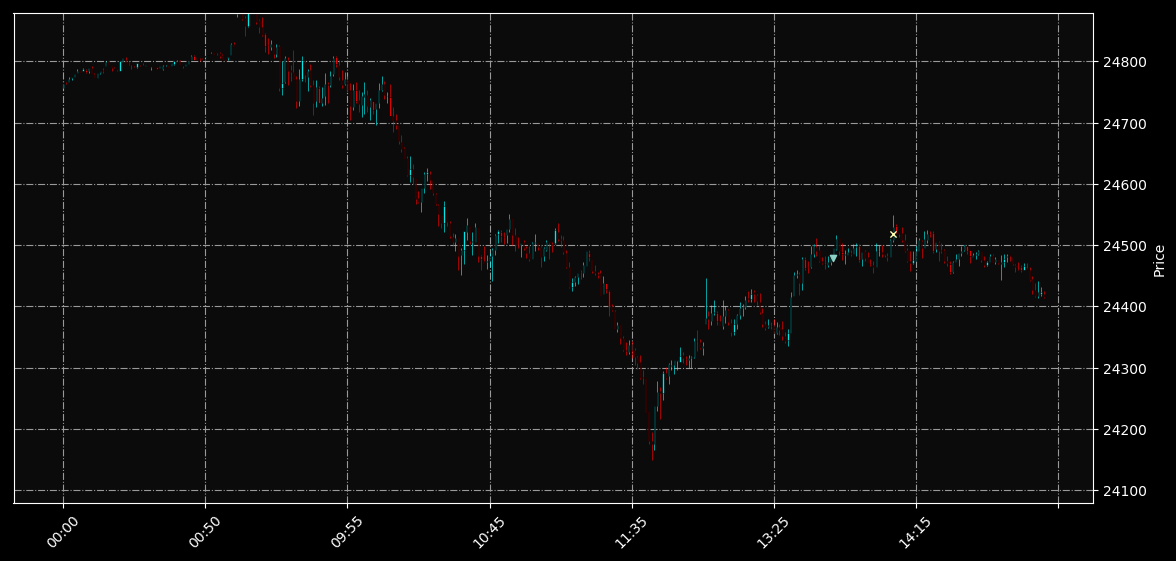

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
967        Buy              2       24368           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
967 2020-08-10 09:46:00     LExit             2      24328   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
967       -4120 2020-08-10 09:46:00                53     loss

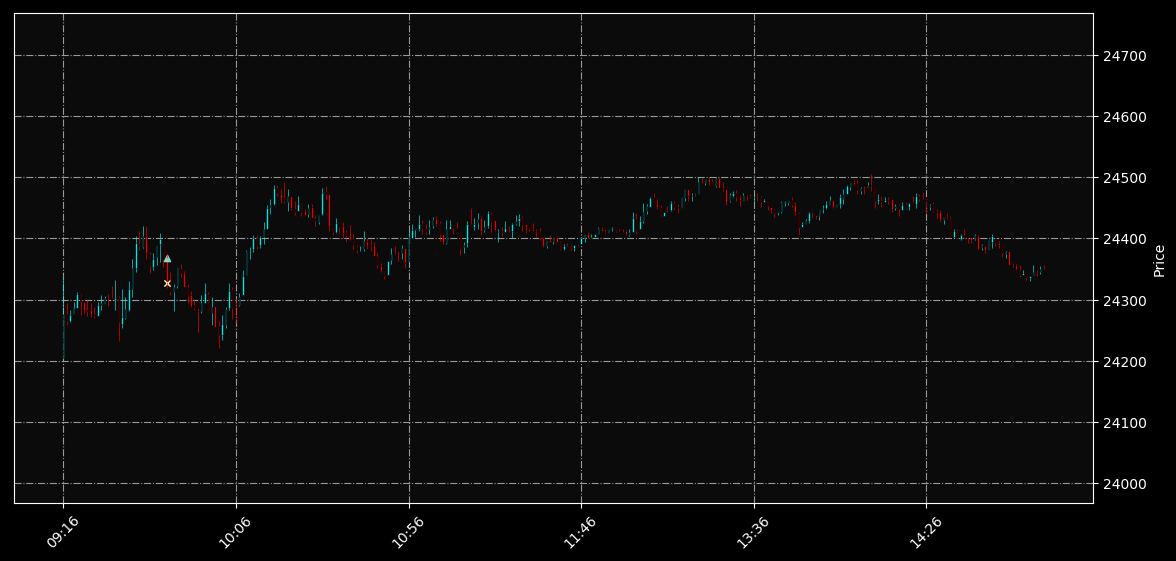

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
968        Buy              2       24458         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
968 2020-08-10 13:46:00     LExit             2      24418   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
968       -4120 2020-08-10 13:49:00                16     loss

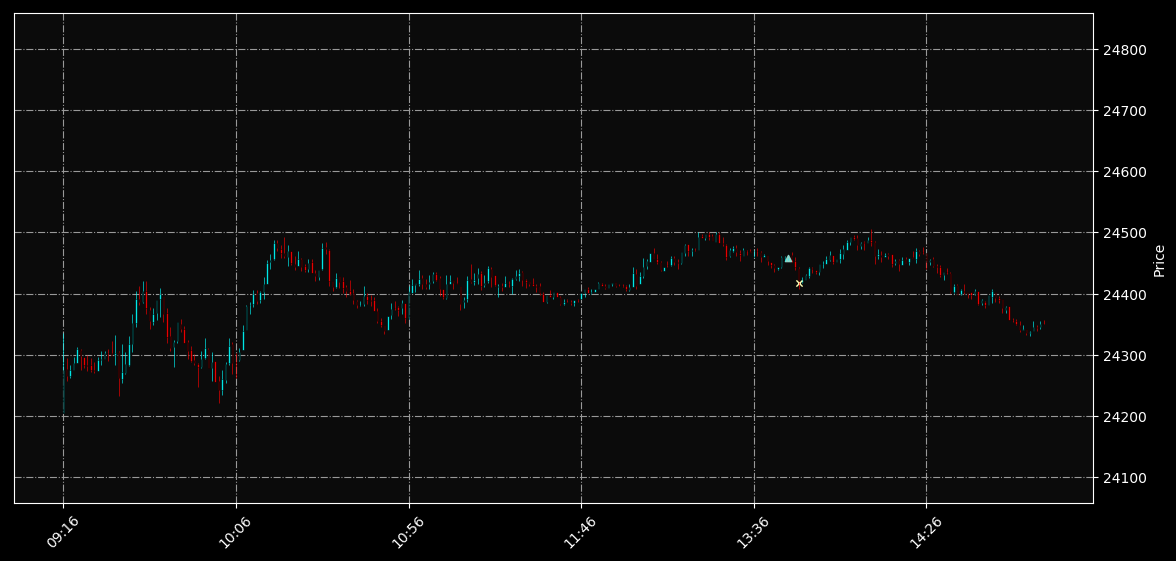

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
969        Buy              2       24780           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
969 2020-08-11 09:46:00     LExit             2      24863        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
969        8180 2020-08-11 09:55:00                75      win

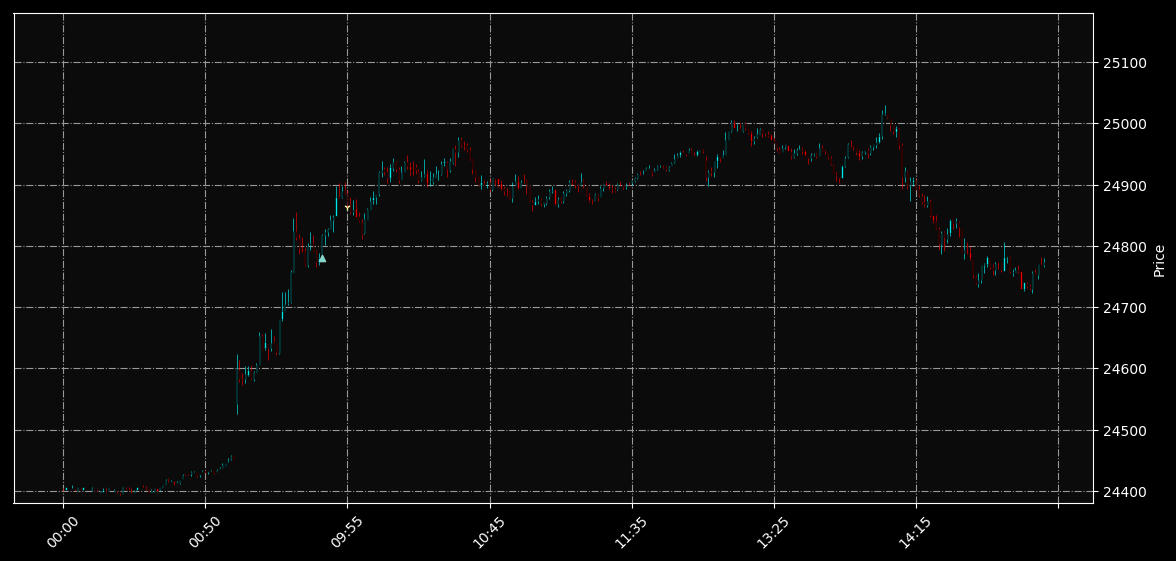

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
970        Buy              2       24932         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
970 2020-08-11 13:46:00     LExit             2      24989        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
970        5580 2020-08-11 14:06:00                36      win

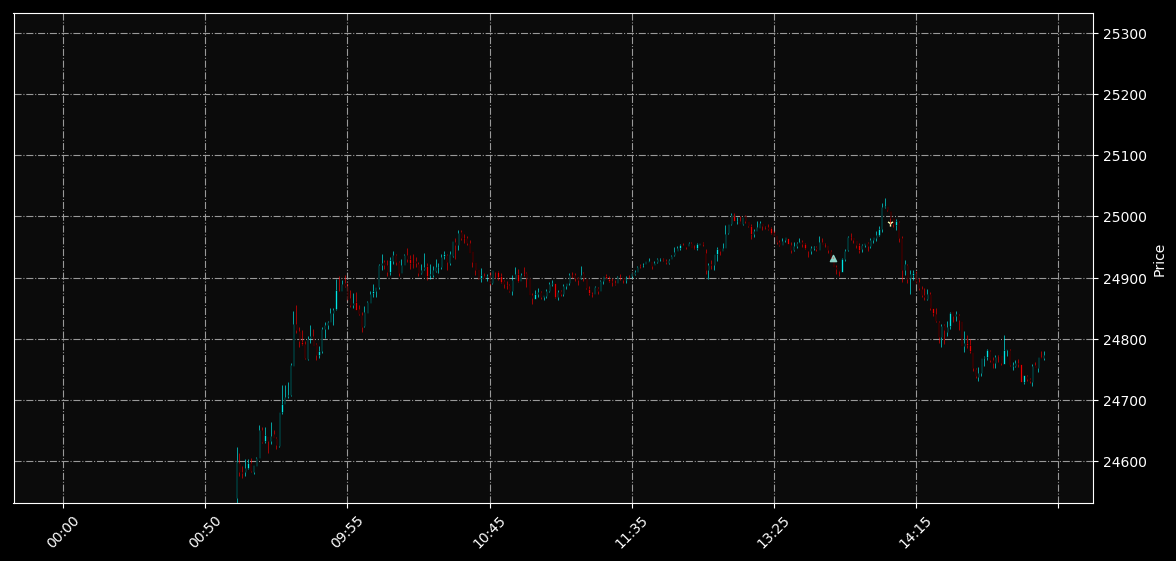

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
971       Sell              2       24752           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
971 2020-08-12 09:46:00     SExit             2      24694       Cover   

    exit_Profit           exit_Time pullback_at_entry win_loss  
971        5680 2020-08-12 09:54:00                 1      win

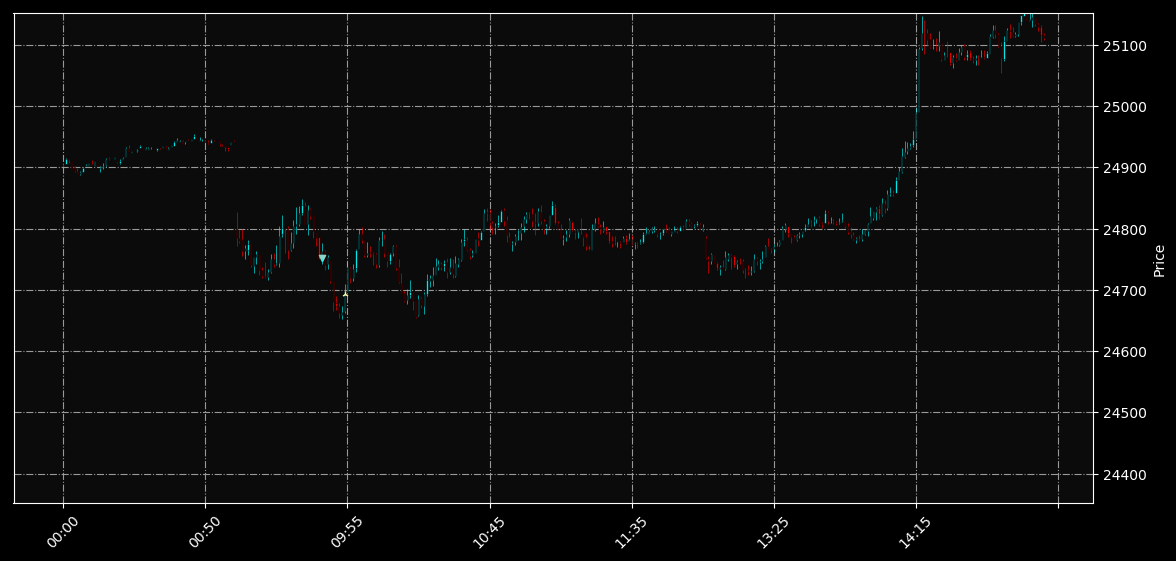

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
972       Sell              2       24812         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
972 2020-08-12 13:46:00     SExit             2      24852   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
972       -4120 2020-08-12 14:05:00                15     loss

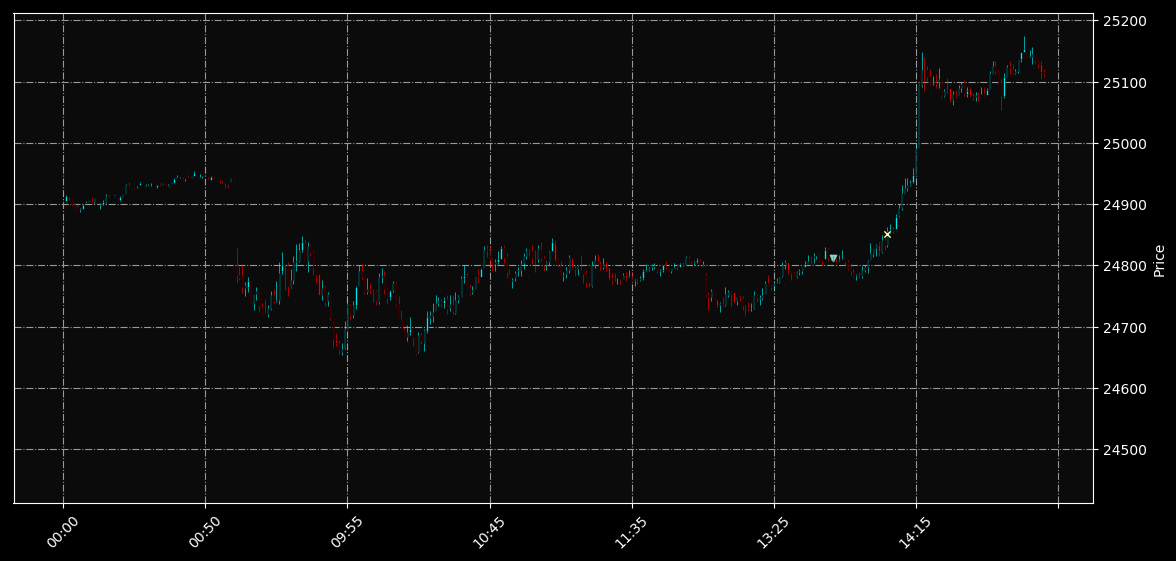

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
973       Sell              2       25303           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
973 2020-08-13 09:46:00     SExit             2      25253       Cover   

    exit_Profit           exit_Time pullback_at_entry win_loss  
973        4880 2020-08-13 09:57:00                17      win

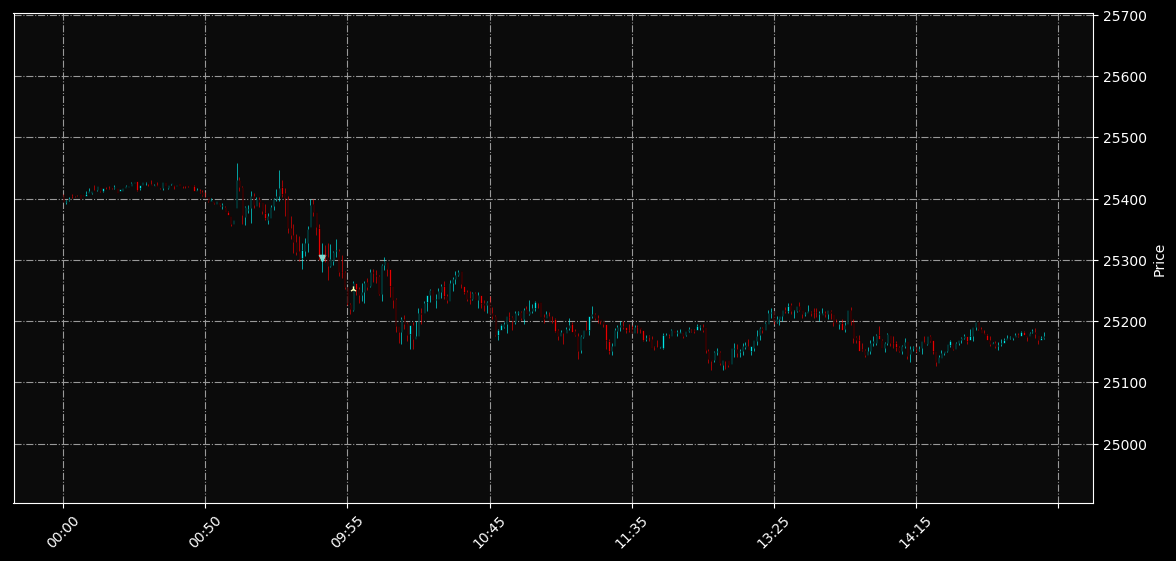

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
974       Sell              2       25212         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
974 2020-08-13 13:46:00     SExit             2      25168       Cover   

    exit_Profit           exit_Time pullback_at_entry win_loss  
974        4280 2020-08-13 14:27:00                11      win

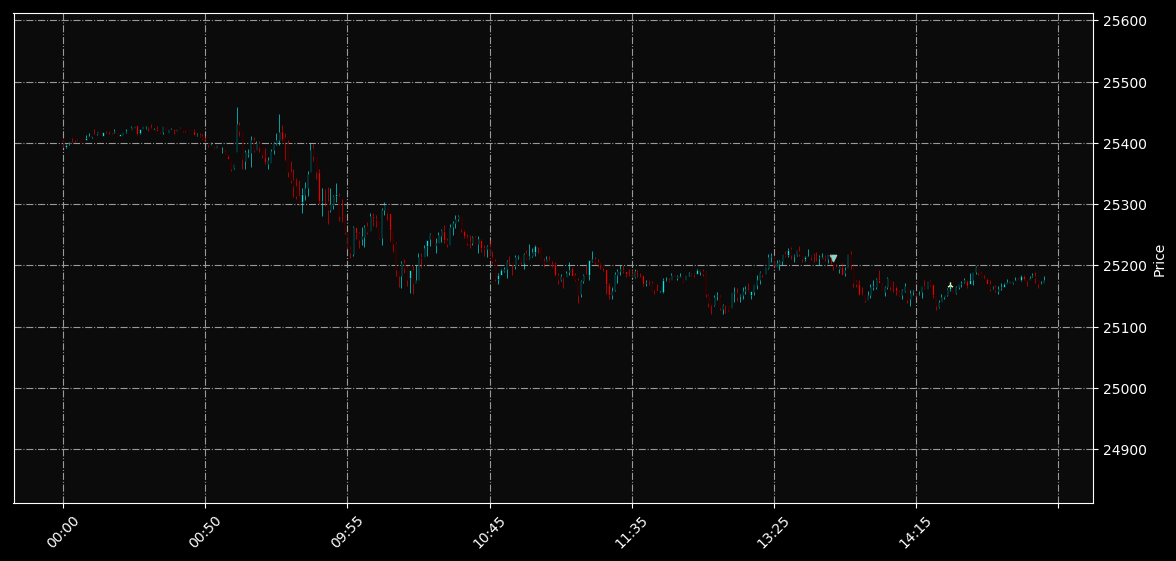

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
975        Buy              2       25172           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
975 2020-08-14 09:46:00     LExit             2      25132   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
975       -4120 2020-08-14 10:00:00                16     loss

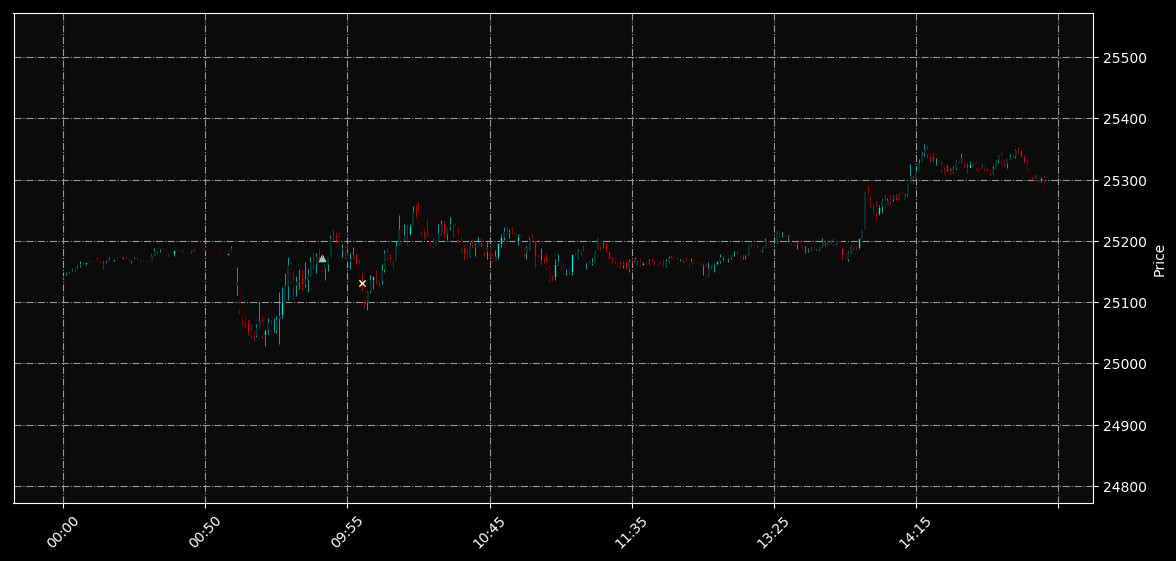

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
976        Buy              2       25200         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
976 2020-08-14 13:46:00     LExit             2      25249        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
976        4780 2020-08-14 14:00:00                 5      win

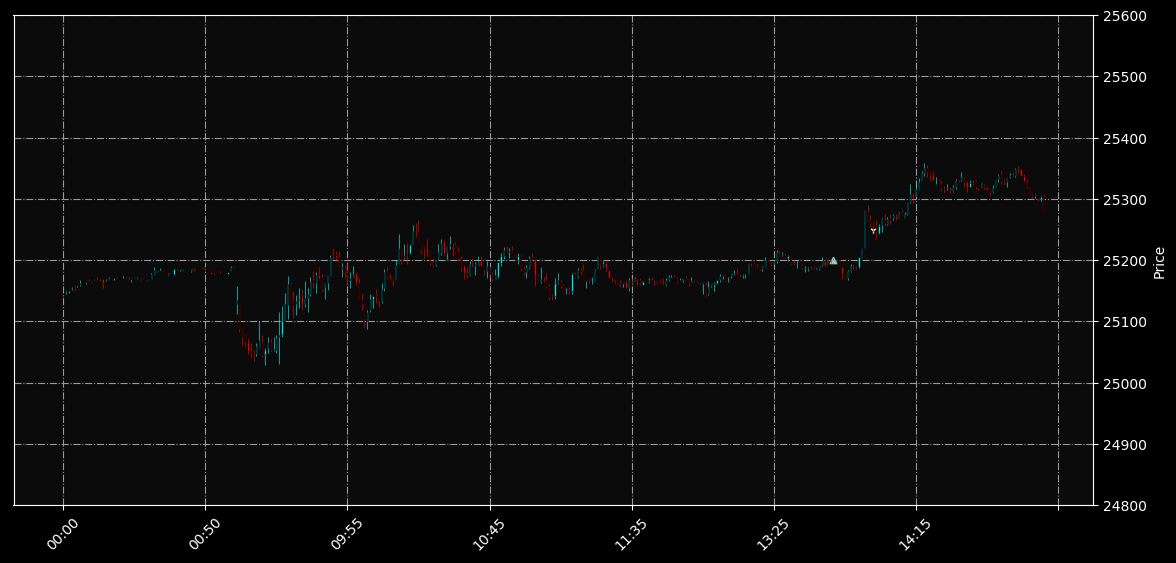

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
977        Buy              2       25293           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
977 2020-08-17 09:46:00     LExit             2      25253   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
977       -4120 2020-08-17 09:58:00                27     loss

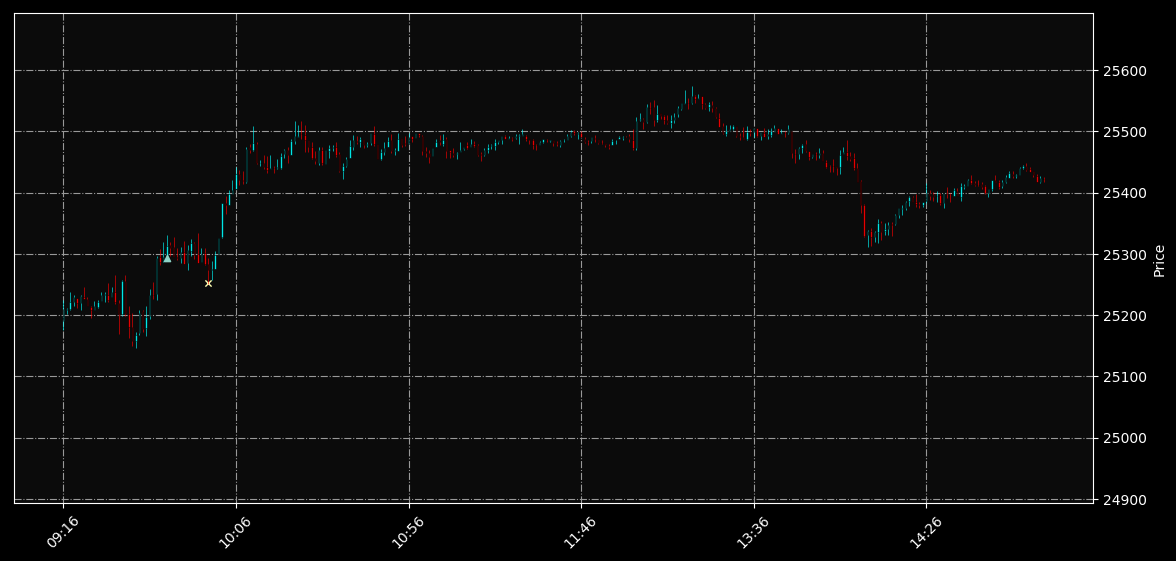

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
978        Buy              2       25498         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
978 2020-08-17 13:46:00     LExit             2      25458   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
978       -4120 2020-08-17 13:47:00                13     loss

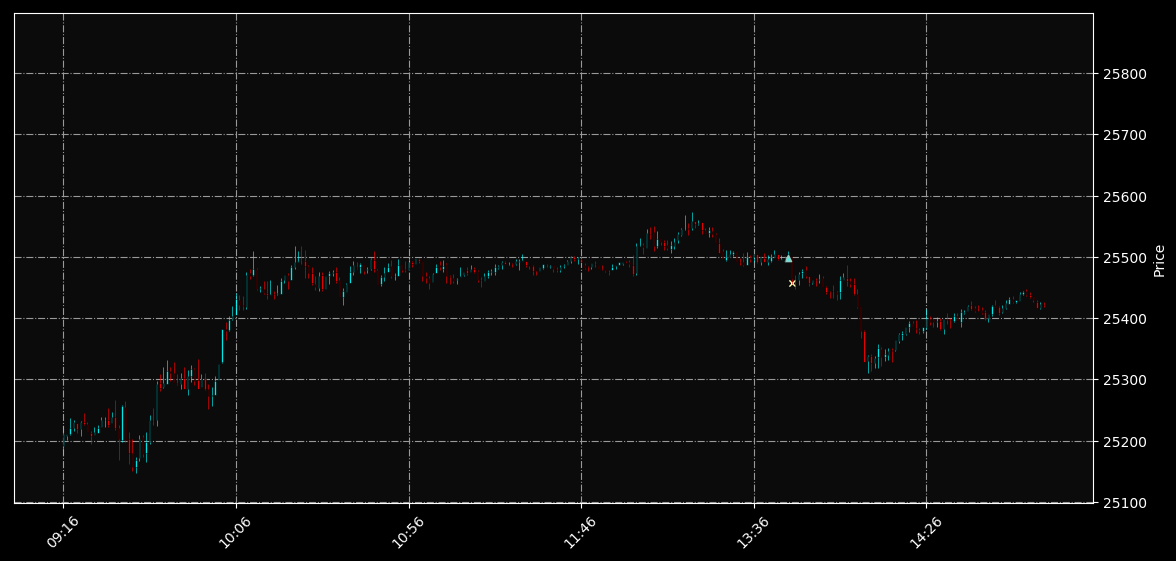

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
979       Sell              2       25318           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
979 2020-08-18 09:46:00     SExit             2      25358   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
979       -4120 2020-08-18 09:50:00                27     loss

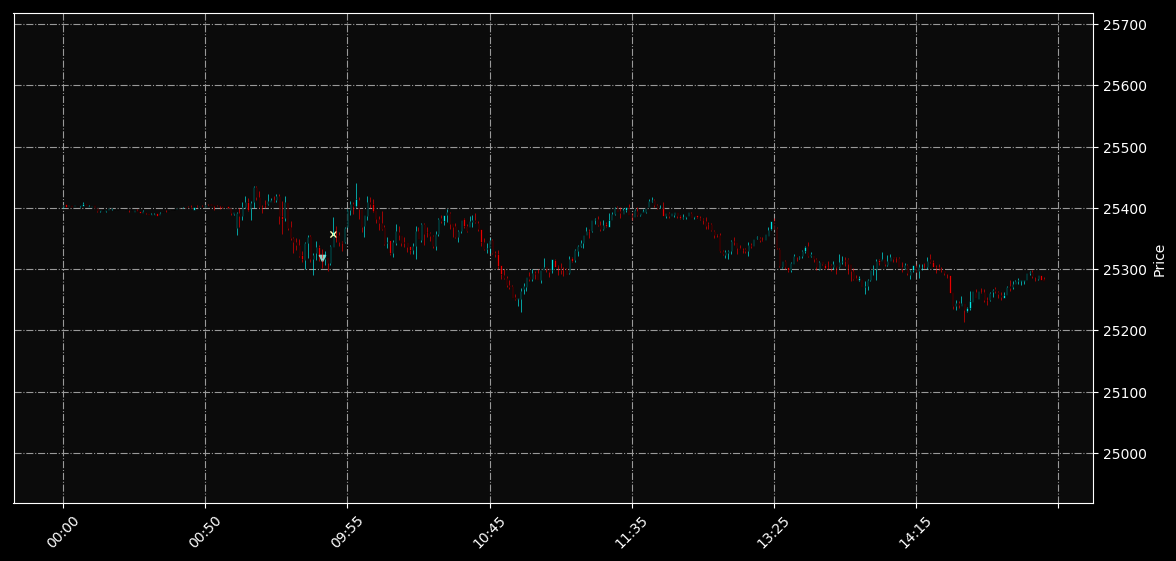

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
980       Sell              2       25303         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
980 2020-08-18 13:46:00     SExit             2      25254       Cover   

    exit_Profit           exit_Time pullback_at_entry win_loss  
980        4780 2020-08-18 14:34:00                 6      win

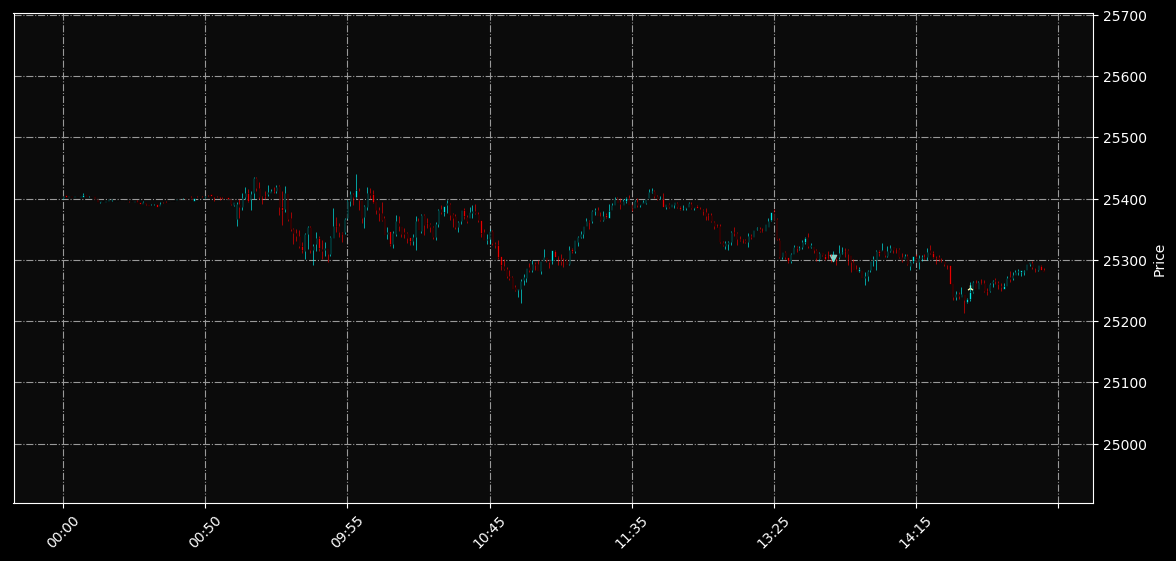

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
981       Sell              2       25092         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
981 2020-08-19 13:46:00     SExit             2      25132   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
981       -4120 2020-08-19 13:52:00                27     loss

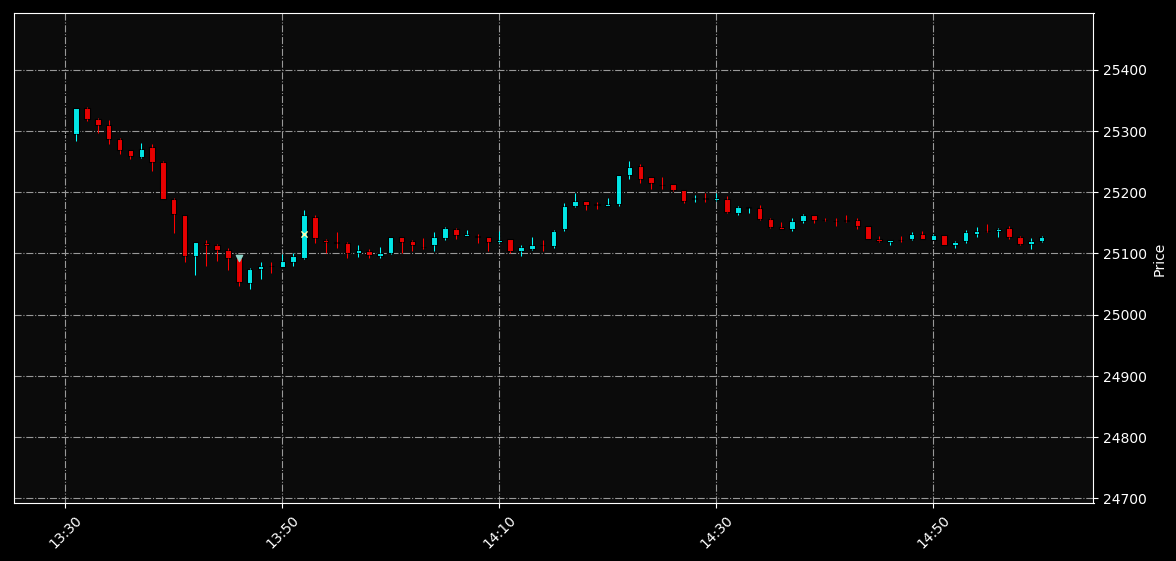

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
982       Sell              2       24744           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
982 2020-08-20 09:46:00     SExit             2      24677       Cover   

    exit_Profit           exit_Time pullback_at_entry win_loss  
982        6580 2020-08-20 10:22:00                59      win

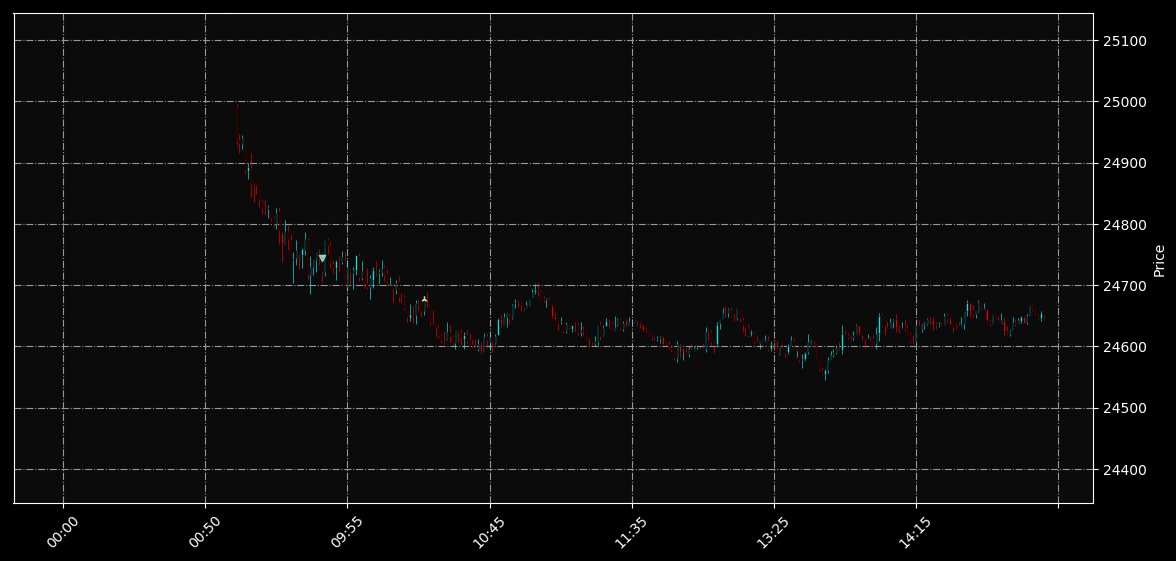

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
983       Sell              2       24586         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
983 2020-08-20 13:46:00     SExit             2      24626   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
983       -4120 2020-08-20 13:49:00                41     loss

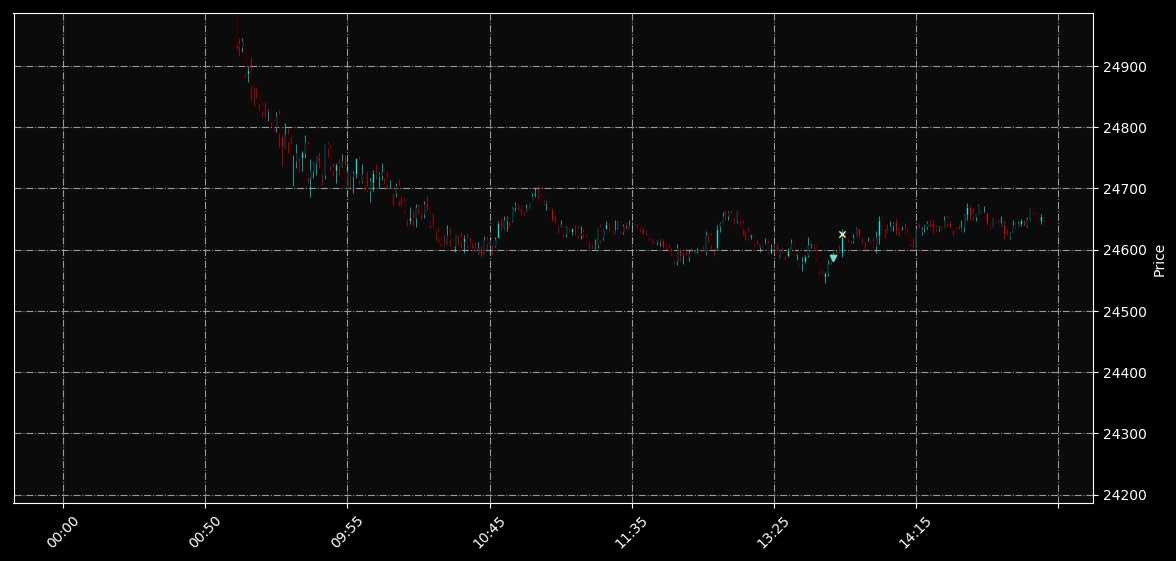

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
984        Buy              2       24923           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
984 2020-08-21 09:46:00     LExit             2      24883   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
984       -4120 2020-08-21 09:49:00                30     loss

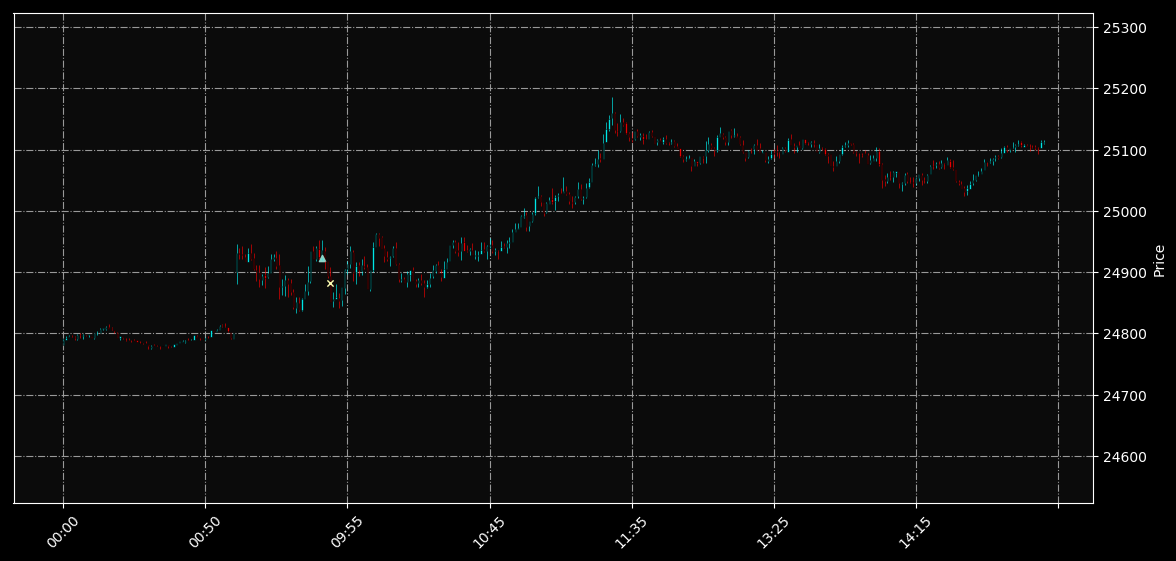

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
985        Buy              2       25074         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
985 2020-08-21 13:46:00     LExit             2      25034   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
985       -4120 2020-08-21 14:10:00                44     loss

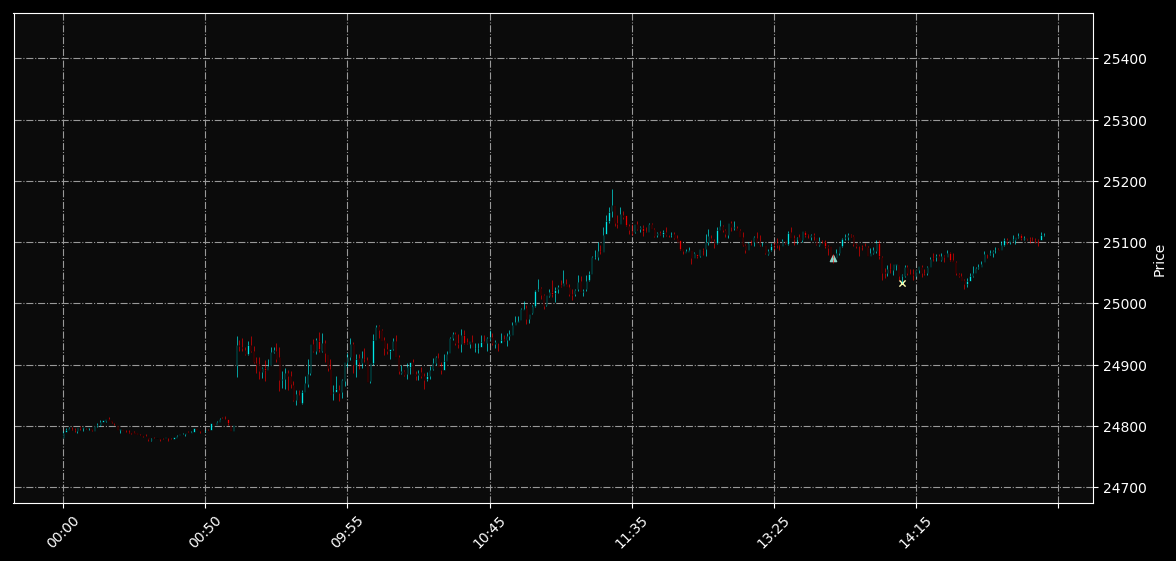

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
986        Buy              2       25427           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
986 2020-08-24 09:46:00     LExit             2      25489        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
986        6080 2020-08-24 10:01:00                81      win

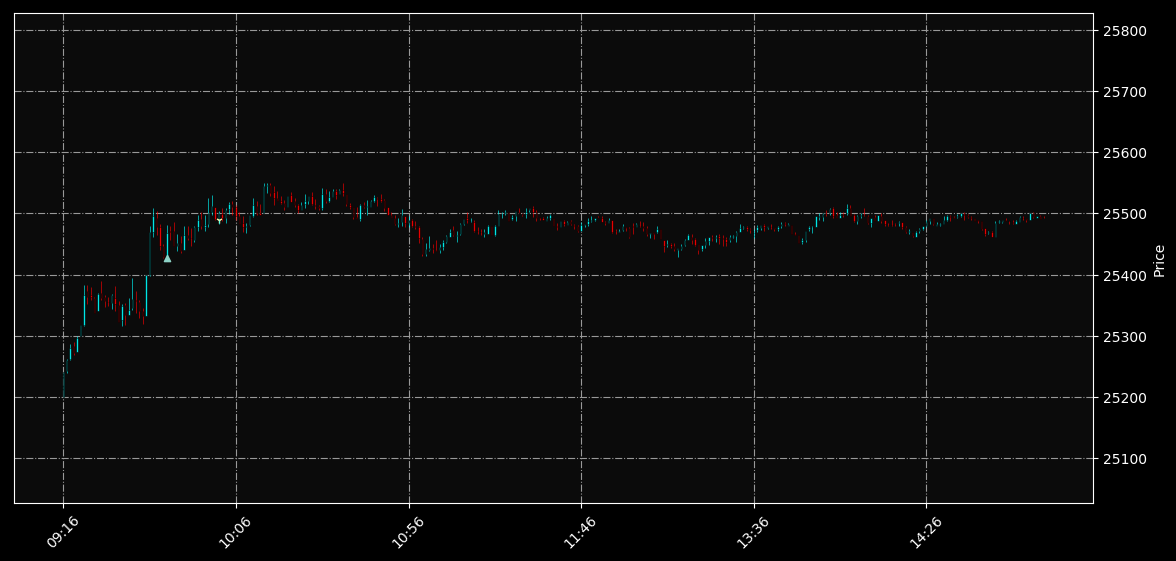

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
987        Buy              2       25480         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
987 2020-08-24 13:46:00     LExit             2      25539        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
987        5780 2020-08-24 20:29:00                 6      win

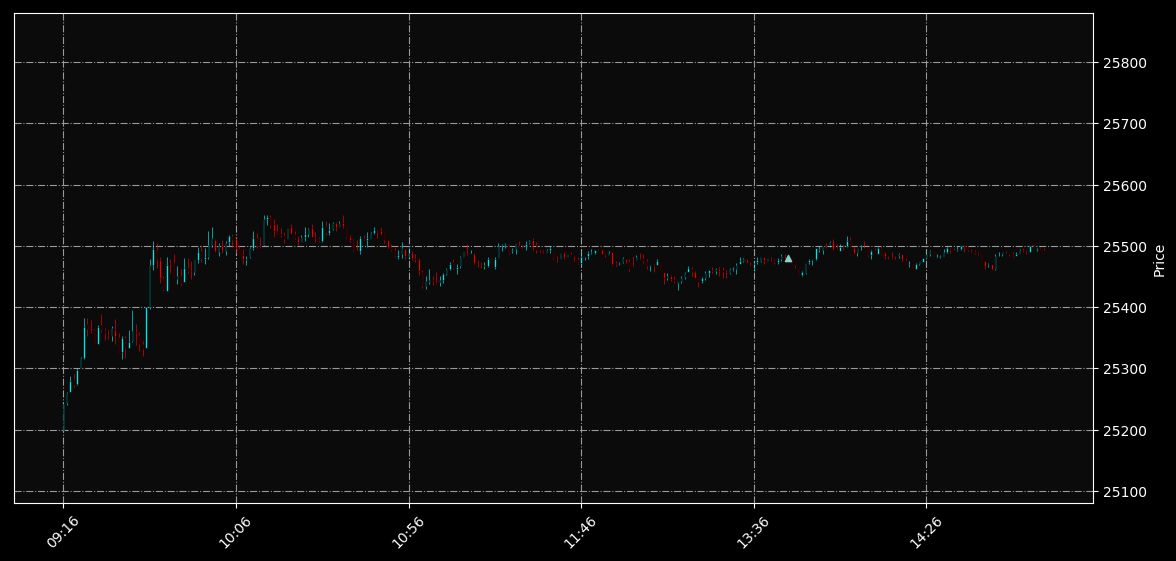

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
988        Buy              2       25527           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
988 2020-08-25 09:46:00     LExit             2      25487   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
988       -4120 2020-08-25 09:47:00                64     loss

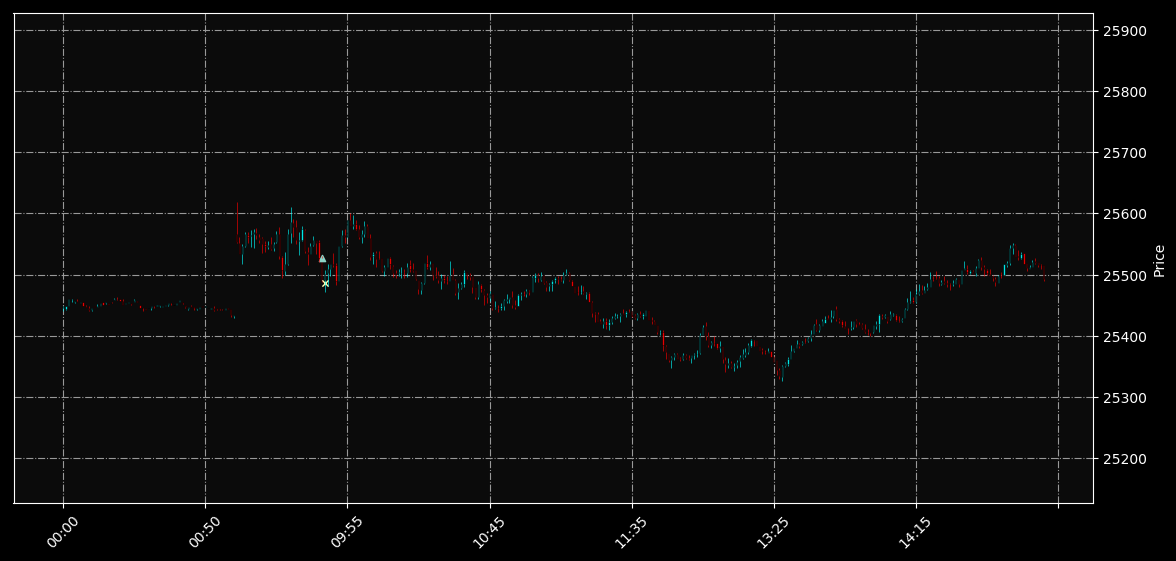

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
989       Sell              2       25432         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
989 2020-08-25 13:46:00     SExit             2      25472   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
989       -4120 2020-08-25 14:13:00                43     loss

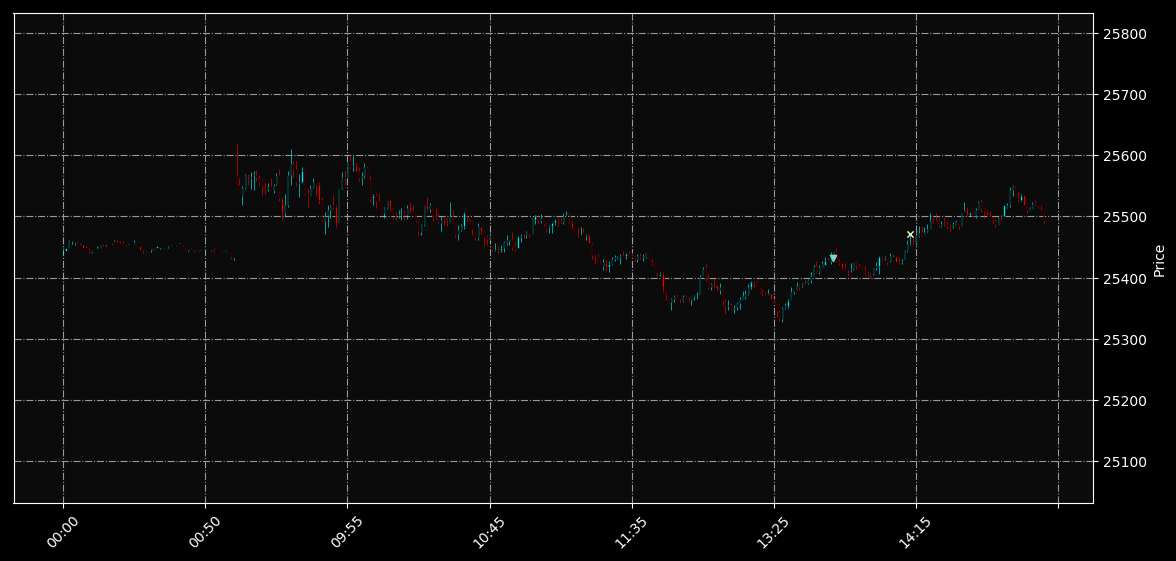

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
990        Buy              2       25509           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
990 2020-08-26 09:46:00     LExit             2      25562        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
990        5180 2020-08-26 09:55:00                44      win

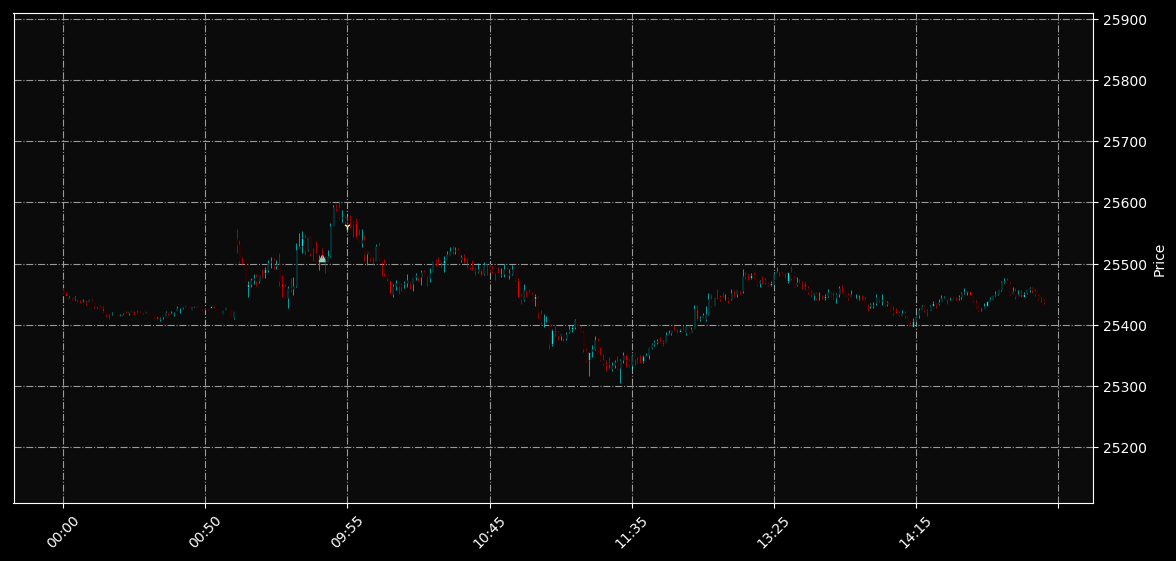

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
991       Sell              2       25447         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
991 2020-08-26 13:46:00     SExit             2      25487   Stop Loss   

    exit_Profit           exit_Time pullback_at_entry win_loss  
991       -4120 2020-08-26 23:43:00                 7     loss

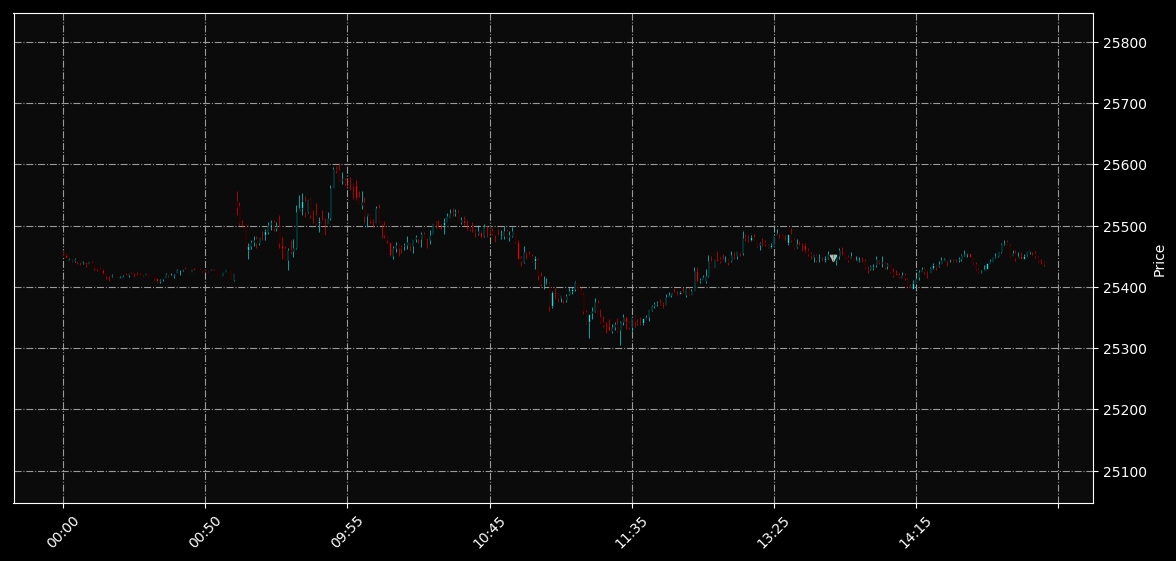

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
992       Sell              2       25256           SE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
992 2020-08-27 09:46:00     SExit             2      25204       Cover   

    exit_Profit           exit_Time pullback_at_entry win_loss  
992        5080 2020-08-27 09:57:00                44      win

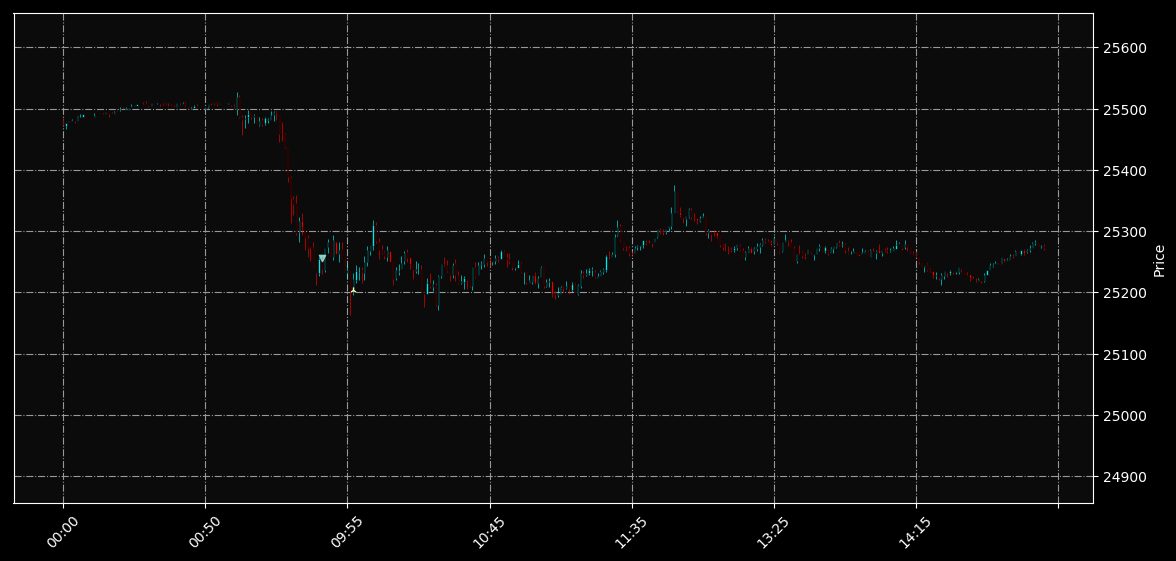

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
993       Sell              2       25271         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
993 2020-08-27 13:46:00     SExit             2      25206       Cover   

    exit_Profit           exit_Time pullback_at_entry win_loss  
993        6380 2020-08-27 17:37:00                18      win

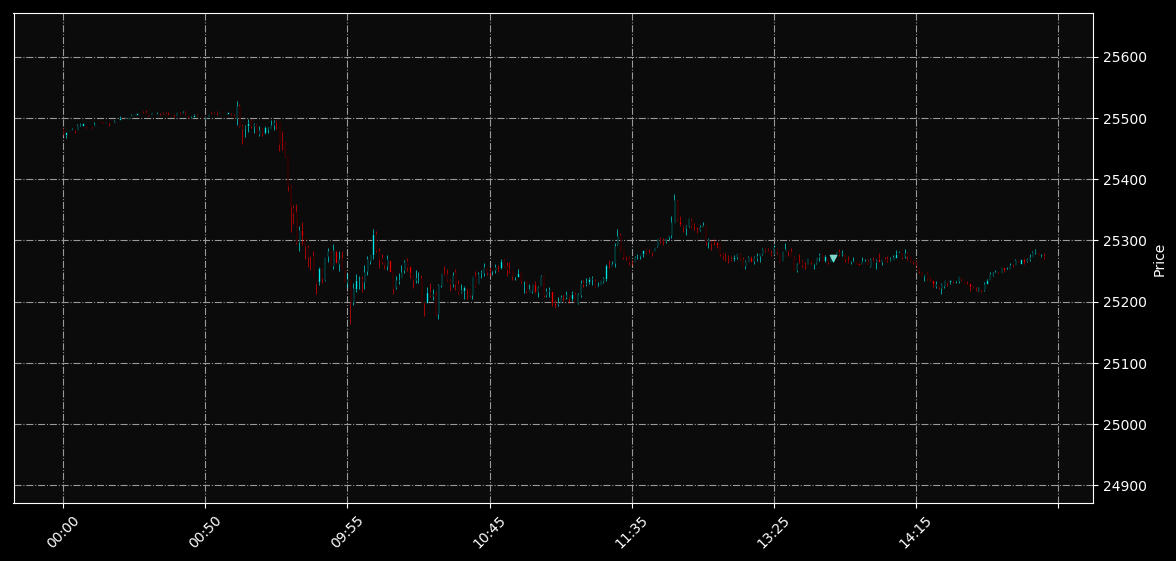

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
994        Buy              2       25295           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
994 2020-08-28 09:46:00     LExit             2      25443        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
994       14680 2020-08-28 11:10:00                37      win

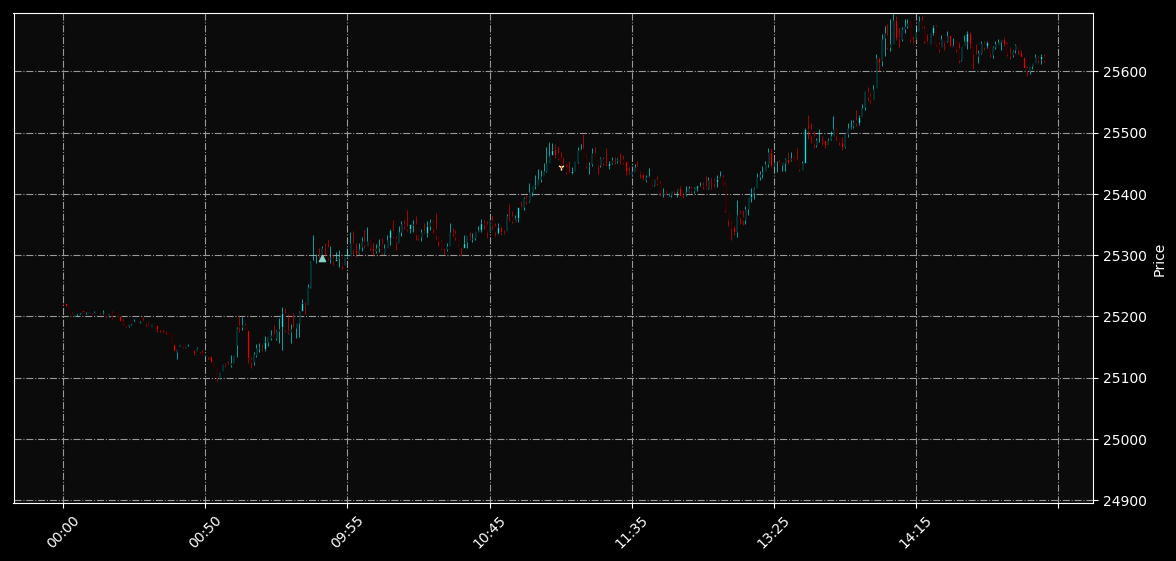

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
995        Buy              2       25494         LEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
995 2020-08-28 13:46:00     LExit             2      25636        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
995       14080 2020-08-28 14:06:00                34      win

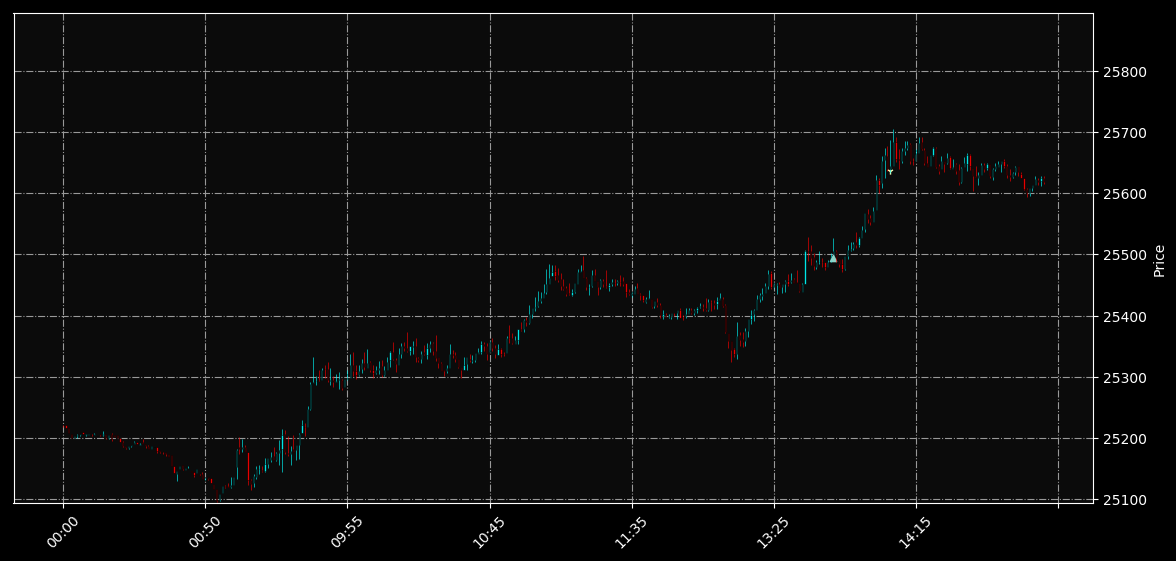

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
996        Buy              2       25695           LE          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
996 2020-08-31 09:46:00     LExit             2      25749        Sell   

    exit_Profit           exit_Time pullback_at_entry win_loss  
996        5280 2020-08-31 09:48:00                21      win

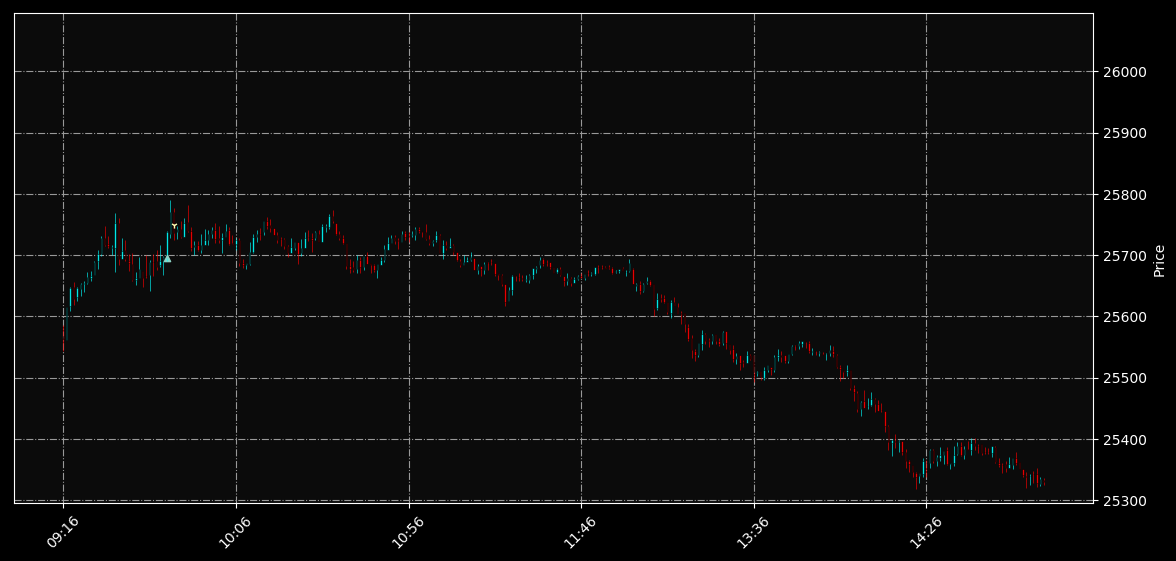

entry_Type entry_Quantity entry_Price entry_Signal entry_Profit  \
997       Sell              2       25527         SEpm          NaN   

             entry_Time exit_Type exit_Quantity exit_Price exit_Signal  \
997 2020-08-31 13:46:00     SExit             2      25478       Cover   

    exit_Profit           exit_Time pullback_at_entry win_loss  
997        4780 2020-08-31 14:08:00                35      win

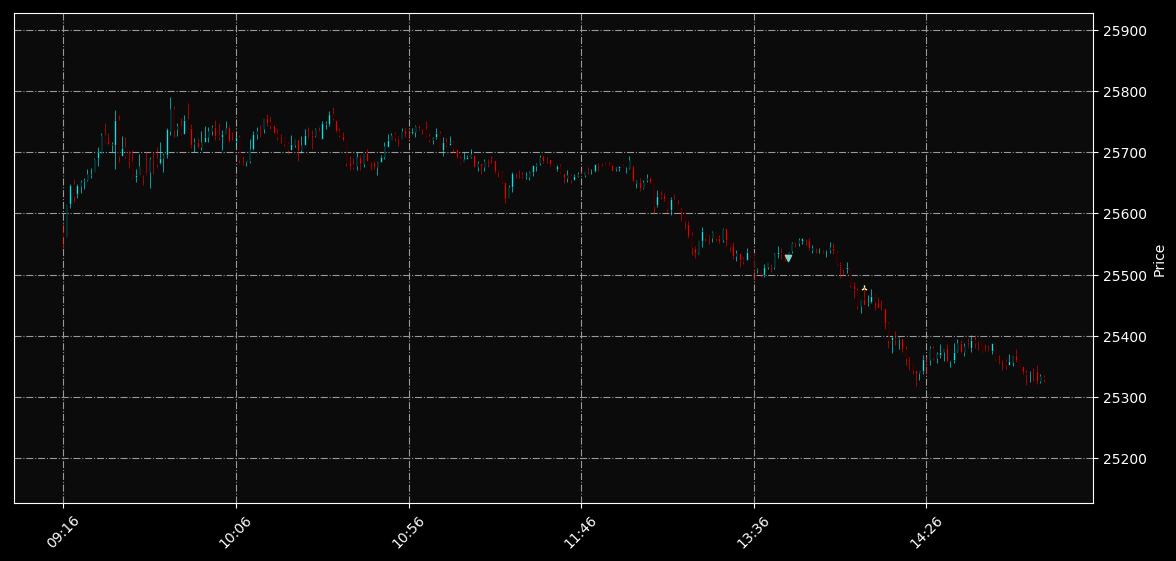

In [39]:
for i, trade in df_trades.query(str_202008).iterrows():
    plot_trade(trade, df_bar, my_style)

- From eyeballing the charts, seems like the winning trades happen more often when there were pullbacks in price and then the price continues in the direction of interest. Pullbacks seemed to happen more often in 2020-Aug and less in 2019-Jul.  

### Did winning trades happen more often when there were pullbacks ?

### 2019-Jul

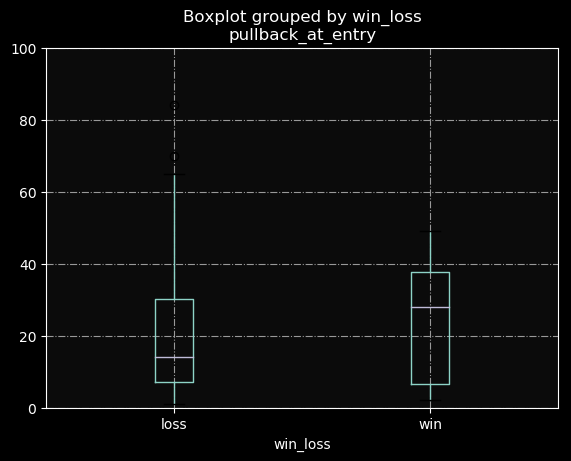

In [40]:
ax = df_trades.query(str_201907)[ df_trades.query(str_201907)['pullback_at_entry'].notna() ].boxplot(by='win_loss', column=['pullback_at_entry'] )
ax.set_ylim(0,100);

In [41]:
s_win  = df_trades.query(str_201907).query('win_loss=="win"')['pullback_at_entry']
s_loss = df_trades.query(str_201907).query('win_loss=="loss"')['pullback_at_entry']

In [42]:
stats.ttest_ind(s_win, s_loss)

Ttest_indResult(statistic=0.15101457923787331, pvalue=0.8807232422476323)

- 2019-Jul was a month with many loss trades and this month
- And the winning trades tend to have more pullbacks (~28 pts); however, the difference in pullback between win and loss trades is not statistically significant.

In [43]:
df_trades.query(str_201907).groupby('win_loss')['pullback_at_entry'].describe()

count        mean         std  min  25%   50%    75%    max
win_loss                                                             
loss       34.0  23.2941176  25.6745711  1.0  7.0  14.0  30.25  105.0
win         8.0  24.7500000  18.2189070  2.0  6.5  28.0  37.75   49.0

### 2020-Aug

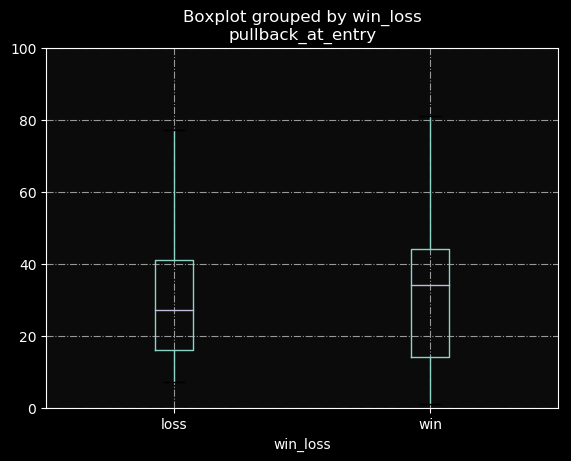

In [44]:
ax = df_trades.query(str_202008)[ df_trades.query(str_202008)['pullback_at_entry'].notna() ].boxplot(by='win_loss', column=['pullback_at_entry'] )
ax.set_ylim(0,100);

In [45]:
s_win  = df_trades.query(str_202008).query('win_loss=="win"')['pullback_at_entry']
s_loss = df_trades.query(str_202008).query('win_loss=="loss"')['pullback_at_entry']

In [46]:
stats.ttest_ind(s_win, s_loss)

Ttest_indResult(statistic=0.521713512059104, pvalue=0.6048976342244508)

- 2020-Aug was a month with many winning trades
- And the winning trades tend to have more pullback (~34 pts); however, the difference in pullback between win and loss trades is not statistically significant.

In [47]:
df_trades.query(str_202008).groupby('win_loss')['pullback_at_entry'].describe()

count        mean         std  min   25%   50%   75%   max
win_loss                                                            
loss       21.0  29.4761905  18.4136337  7.0  16.0  27.0  41.0  77.0
win        19.0  33.1052632  25.3418730  1.0  14.0  34.0  44.0  81.0

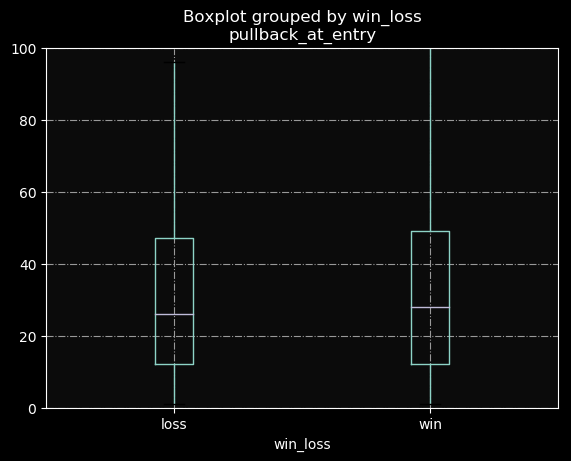

In [48]:
ax = df_trades[ df_trades['pullback_at_entry'].notna() ].boxplot(by='win_loss', column=['pullback_at_entry'] )
ax.set_ylim(0,100);

- Indeed the difference in pullback between win and loss trades is not apparent at all when looking at all the trades from 2018 to 2021-H1.

Note: the boxplot is cropped at the top in order to see the median. 

In [49]:
s_win  = df_trades[ df_trades['pullback_at_entry'].notna() ].query('win_loss=="win"')['pullback_at_entry']
s_loss = df_trades[ df_trades['pullback_at_entry'].notna() ].query('win_loss=="loss"')['pullback_at_entry']

In [50]:
stats.ttest_ind(s_win, s_loss)

Ttest_indResult(statistic=0.49609086468394875, pvalue=0.6199117229603801)

In [51]:
# ax = df_trades[ df_trades['first_pullback_at_entry'].notna() ].boxplot(by='win_loss', column=['first_pullback_at_entry'] )
# ax.set_ylim(0,100);

In [52]:
# ax = df_trades_201907[ df_trades_201907['first_pullback_at_entry'].notna() ].boxplot(by='win_loss', column=['first_pullback_at_entry'] )
# ax.set_ylim(0,100);

In [53]:
# ax = df_trades_202008[ df_trades_202008['first_pullback_at_entry'].notna() ].boxplot(by='win_loss', column=['first_pullback_at_entry'] )
# ax.set_ylim(0,100);

## Does more volatile market bring more profit ? 

In [54]:
def calc_range(bars):    
    return bars.High.max()-bars.Low.min()

def calc_morning_range(bars):
    b_ = bars[ bars.index[0] ]
    return

def is_morning(t):
    return t.time() < pd.Timestamp('13:45').time()

In [55]:
df_bar_ = df_bar.copy(True)
df_bar_['date'] = df_bar_.index.map(lambda x: x.date())

s_date_unique = pd.Series(df_bar_['date'].unique())
dict_prev_date = dict(zip(s_date_unique, s_date_unique.shift(1)))
dict_range = df_bar_.groupby('date').apply(calc_range).to_dict()

df_bar_['is_morning'] = df_bar_.index.map(is_morning)
dict_morning_range = df_bar_.query('is_morning==True').groupby('date').apply(calc_range).to_dict()

In [56]:
df_trades['date'] = df_trades['entry_Time'].apply(lambda x: pd.Timestamp(x).date() )
df_trades['today_range'] = df_trades['date'].map(dict_range)

df_trades['prev_date'] = df_trades['date'].map(dict_prev_date)
df_trades['prev_range']= df_trades['prev_date'].map(dict_range)

df_trades['morning_range'] = df_trades['date'].map( dict_morning_range )

In [57]:
df_trades.head()

entry_Type  entry_Quantity  entry_Price entry_Signal entry_Profit  \
0        Buy               2      28401.0           LE          NaN   
1        Buy               2      28634.0         LEpm          NaN   
2       Sell               2      28021.0           SE          NaN   
3       Sell               2      28189.0         SEpm          NaN   
4        Buy               2      28350.0           LE          NaN   

           entry_Time exit_Type  exit_Quantity  exit_Price exit_Signal  \
0 2018-06-29 09:46:00     LExit              2     28361.0   Stop Loss   
1 2018-06-29 13:46:00     LExit              2     28697.0        Sell   
2 2018-07-03 09:46:00     SExit              2     27941.0       Cover   
3 2018-07-03 13:46:00     SExit              2     28141.0       Cover   
4 2018-07-04 09:46:00     LExit              2     28310.0   Stop Loss   

   exit_Profit           exit_Time  pullback_at_entry win_loss        date  \
0      -4120.0 2018-06-29 09:49:00               29.0     loss  2018-06-29   
1       6180.0 2018-06-29 14:08:00               29.0      win  2018-06-29   
2       7880.0 2018-07-03 09:47:00               33.0      win  2018-07-03   
3       4680.0 2018-07-03 14:04:00               42.0      win  2018-07-03   
4      -4120.0 2018-07-04 09:58:00               96.0     loss  2018-07-04   

   today_range   prev_date  prev_range  morning_range  
0        571.0  2018-06-28       425.0          519.0  
1        571.0  2018-06-28       425.0          519.0  
2        712.0  2018-06-30        58.0          613.0  
3        712.0  2018-06-30        58.0          613.0  
4        518.0  2018-07-03       712.0          504.0

In [58]:
str_b4_2020H2 = '(entry_Time < datetime(2020,7,1,0,0,0))'
str_2020H2 = '(entry_Time >= datetime(2020,7,1,0,0,0)) & (entry_Time < datetime(2021,1,1,0,0,0))'

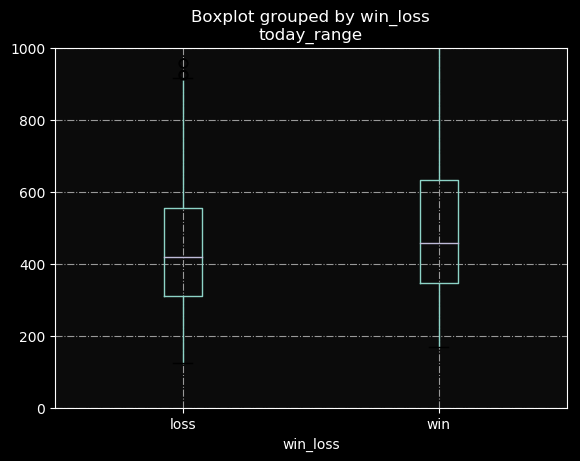

In [59]:
ax = df_trades.query(str_b4_2020H2).boxplot(by='win_loss', column=['today_range'] ) 
ax.set_ylim(0,1000);

- From 2018 to 2020-H1, the winning trades had higher volatility range and <span style="color:red">this result is statistically significant</span>.

In [60]:
s_win = df_trades.query(str_b4_2020H2).query('win_loss=="win"')['today_range']
s_loss= df_trades.query(str_b4_2020H2).query('win_loss=="loss"')['today_range']

In [61]:
stats.ttest_ind(s_win, s_loss)

Ttest_indResult(statistic=2.3151957484128523, pvalue=0.020822903723588537)

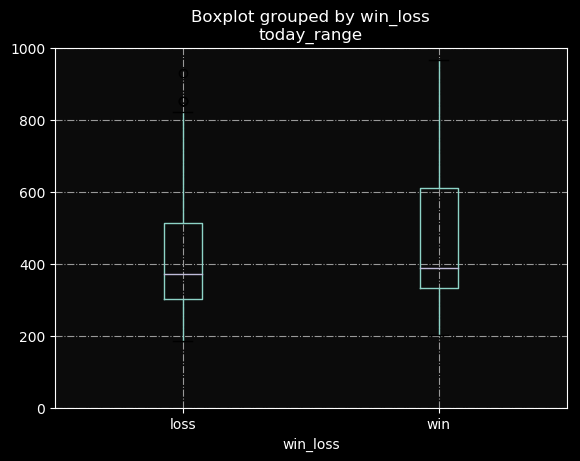

In [62]:
ax = df_trades.query(str_2020H2).boxplot(by='win_loss', column=['today_range'] ) 
ax.set_ylim(0,1000);

In [63]:
s_win = df_trades.query(str_2020H2).query('win_loss=="win"')['today_range']
s_loss= df_trades.query(str_2020H2).query('win_loss=="loss"')['today_range']

In [64]:
stats.ttest_ind(s_win, s_loss)

Ttest_indResult(statistic=1.8744573615759983, pvalue=0.06210274555759647)

- In 2020-H2, the winning trades had slightly higher volatility range; though this result is not statistically strong enough.

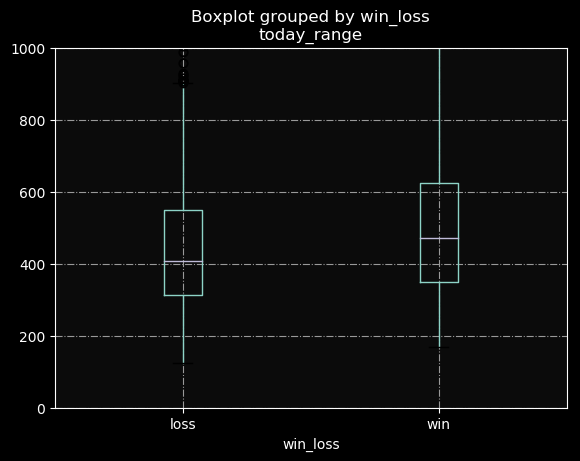

In [65]:
ax = df_trades.boxplot(by='win_loss', column=['today_range'] )
ax.set_ylim(0,1000);

In [66]:
s_win = df_trades.query('win_loss=="win"')['today_range']
s_loss= df_trades.query('win_loss=="loss"')['today_range']

In [67]:
stats.ttest_ind(s_win, s_loss)

Ttest_indResult(statistic=3.4224379407301497, pvalue=0.0006392140918165176)

- If volatility is high for the trading day then the strategy is more likely to win and this result is highly statistically significant

### Should we place a trade in the afternoon if the volatility in the morning was high?

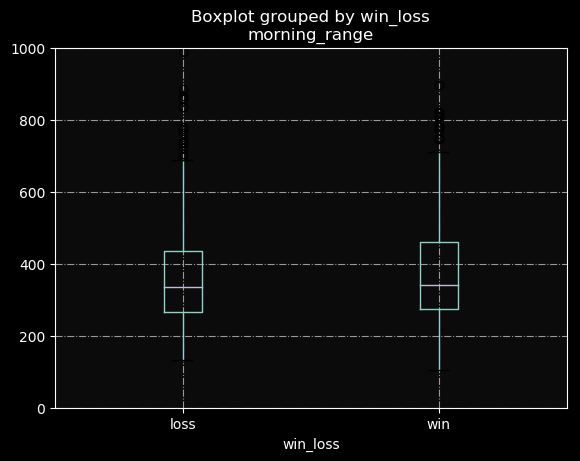

In [68]:
ax = df_trades.query('entry_Signal == "LEpm" | entry_Signal == "SEpm"').boxplot(by='win_loss', column=['morning_range'] )
ax.set_ylim(0,1000);

In [69]:
df_trades.query('entry_Signal == "LEpm" | entry_Signal == "SEpm"').groupby('win_loss')['morning_range'].describe()

count         mean          std    min    25%    50%    75%     max
win_loss                                                                     
loss      439.0  377.6059226  180.6913210  132.0  265.0  336.0  435.5  2059.0
win       248.0  383.3508065  167.6950973  104.0  273.5  340.0  459.0  1111.0

- unfortunately, high volatility in the morning session does not lead to better winnings in the afternoon.

In [79]:
s_win = df_trades.query('(entry_Signal == "LEpm" | entry_Signal == "SEpm") & (win_loss=="win")')['morning_range']
s_loss= df_trades.query('(entry_Signal == "LEpm" | entry_Signal == "SEpm") & (win_loss=="loss")')['morning_range']

In [95]:
stats.ttest_ind(s_win, s_loss)

Ttest_indResult(statistic=0.4106416065403708, pvalue=0.6814637667699426)

(0.9997286200523376, 0.7901570200920105)

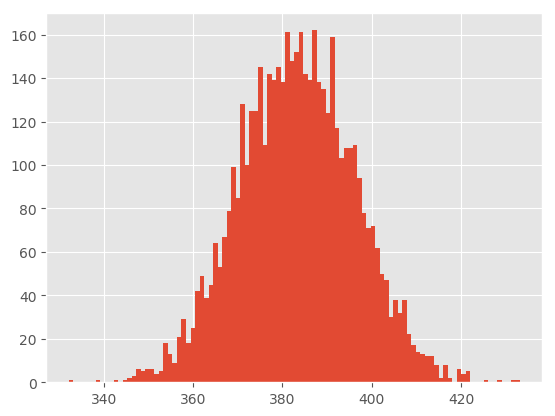

In [94]:
# Sanity check on the normality of the mean of the sample
l = [s_win.sample(100).mean() for i in range(1,5000)]
display(stats.shapiro(l))
pd.Series(l).hist(bins=100);

- The mean of the sample follows a normal distribution as shown in both the histogram and the Shapiro test with value near 1 and p-value > 0.05. 

## Does today's range correlate with previous day's range ? 


In [72]:
df_trades[['today_range','prev_range']].corr()

today_range  prev_range
today_range    1.0000000   0.3866026
prev_range     0.3866026   1.0000000

- There's only 38% correlation between today's volatility and previous day's volatility; not much at all.

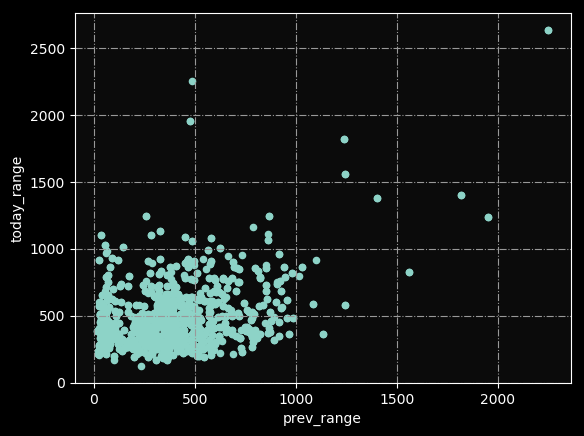

In [73]:
df_trades[['today_range','prev_range']].plot.scatter(x='prev_range', y='today_range');

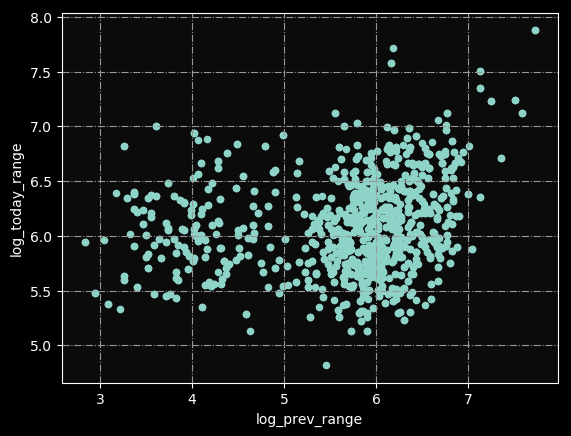

In [74]:
df_trades[['today_range','prev_range']].apply(lambda x: np.log(x)).add_prefix('log_').plot.scatter(x='log_prev_range', y='log_today_range');

## Does today's win/loss correlate with previous day's range ? 

In [75]:
df_ = pd.concat([
    df_trades.query('win_loss=="win"')['prev_range'].rename('win').reset_index(drop=True),
    df_trades.query('win_loss=="loss"')['prev_range'].rename('loss').reset_index(drop=True)
], join='outer', axis=1)

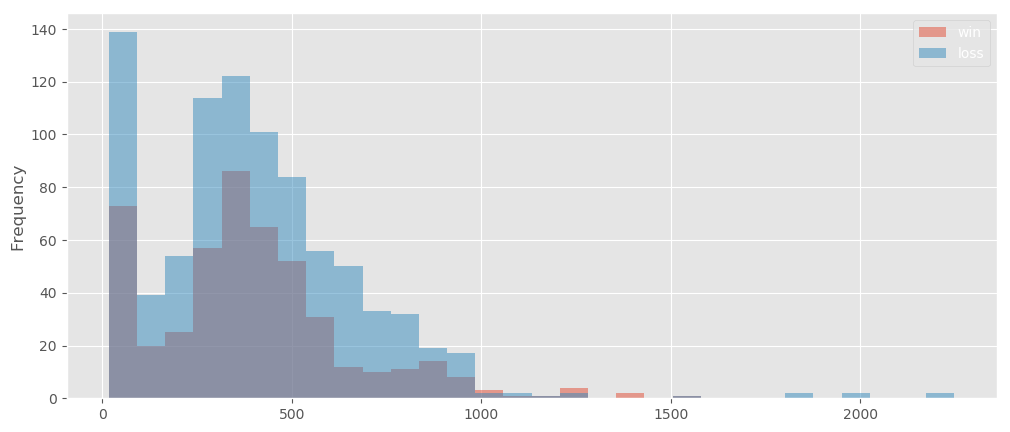

In [76]:
plt.style.use('ggplot')
df_.plot.hist(bins=30,alpha=0.5, figsize=(12,5));

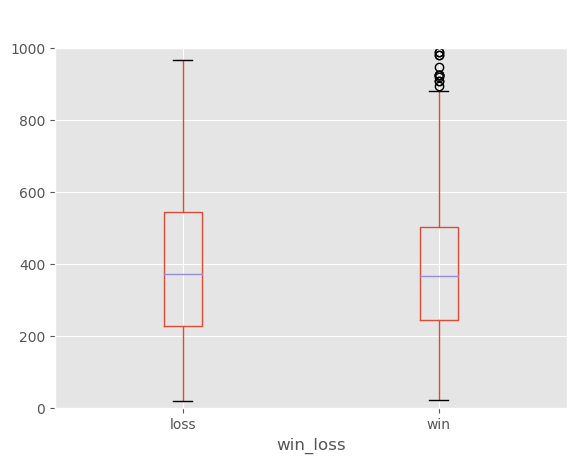

In [77]:
ax = df_trades.boxplot(by='win_loss', column=['prev_range'] )
ax.set_ylim(0,1000);

- Unfortunately, previous day's range does not correlate with next day's win loss of the strategy.

# Appendix

#### List of Trades with End of Day Exit

In [78]:
df_trade[ df_trade['Signal'] == 'End of Day Exit' ]

Type  Quantity    Price           Signal Profit                Time
81    LExit         2  28644.0  End of Day Exit    880 2018-07-30 16:00:00
685   LExit         2  29659.0  End of Day Exit   8380 2019-04-02 01:00:00
745   LExit         2  29818.0  End of Day Exit   -720 2019-04-29 16:00:00
883   LExit         2  28435.0  End of Day Exit   2380 2019-06-25 01:00:00
981   SExit         2  27757.0  End of Day Exit  -1520 2019-07-31 13:55:00
1115  SExit         2  26730.0  End of Day Exit   5680 2019-09-19 01:00:00
1201  LExit         2  26857.0  End of Day Exit   5980 2019-10-23 01:00:00
1361  SExit         2  27850.0  End of Day Exit   4780 2019-12-24 01:00:00
1363  SExit         2  27880.0  End of Day Exit  -2020 2019-12-24 12:30:00
1369  LExit         2  28348.0  End of Day Exit   -520 2019-12-30 16:00:00
1827  SExit         2  24302.0  End of Day Exit   -220 2020-06-29 16:00:00